In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import glob
import cv2
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
from tensorflow.keras.models import Model

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import scikitplot as skplt

import pickle
import dill

In [33]:
# filepath = 'session.pkl'
# dill.dump_session(filepath) # Save the session

In [34]:
info = pd.read_csv('data/info.csv', header=None)

In [35]:
# 20 annotation scores per frame for each video 
# each row is a new set of annotation scores of each video, with 20 rows per video
# scores are from 1-5
# 2 second long shot-level importance scores
annotations = pd.read_csv('data/annotations.csv', header=None)

In [36]:
# 20 videos
# 5 videos per category

# VT: Changing Vehicle Tire
# VU: Getting Vehicle Unstuck
# GA: Grooming an Animal
# MS: Making Sandwich
# PK: Parkour
# PR: Parade
# FM: Flash Mob Gathering
# BK: Bee Keeping
# BT: Attempting Bike Tricks
# DS: Dog Show

info = pd.read_csv('data/info.csv')

In [37]:
annotations.rename(columns={0: 'filename', 1: 'category', 2: 'annotations'}, inplace=True)

In [38]:
annotations.head()

filename category                                        annotations
0  AwmHb44_ouw       VT  4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...
1  AwmHb44_ouw       VT  2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...
2  AwmHb44_ouw       VT  3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...
3  AwmHb44_ouw       VT  4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...
4  AwmHb44_ouw       VT  2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...

In [39]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
filename       1000 non-null object
category       1000 non-null object
annotations    1000 non-null object
dtypes: object(3)
memory usage: 23.6+ KB


In [40]:
info.head()

category     video_id                                              title  \
0       VT  AwmHb44_ouw  #1306 How to change tires for off road vehicle...   
1       VT  98MoyGZKHXc        How to use a tyre repair kit - Which? guide   
2       VT  J0nA4VgnoCo                                   #0001: FLAT TIRE   
3       VT  gzDbaEs1Rlg                 ŠKODA Tips How to Repair Your Tyre   
4       VT  XzYM3PfTM4w                     When to Replace Your Tires GMC   

                                           url length  
0  https://www.youtube.com/watch?v=AwmHb44_ouw   5:54  
1  https://www.youtube.com/watch?v=98MoyGZKHXc   3:07  
2  https://www.youtube.com/watch?v=J0nA4VgnoCo   9:44  
3  https://www.youtube.com/watch?v=gzDbaEs1Rlg   4:48  
4  https://www.youtube.com/watch?v=XzYM3PfTM4w   1:51

In [41]:
annotations['annotations'] = annotations['annotations'].apply(lambda a: a.split(','))

In [42]:
avg_annotations = []
for fname in annotations.filename.unique():
    values = annotations[annotations['filename'] == fname]['annotations'].values
    float_conversion = np.array(list(values)).astype('float64') 
    avg = np.mean(float_conversion, axis=0)
    avg_annotations.append(avg)

In [43]:
average_scores = pd.DataFrame({'filename': annotations.filename.unique(), 'average_score': avg_annotations})

In [44]:
average_scores.sort_values(by='filename')

filename                                      average_score
49  -esJrBWj2d8  [1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.9...
12  0tmA_C6XwfM  [1.15, 1.15, 1.15, 1.15, 1.15, 1.15, 1.15, 1.1...
18  37rzWOQsNIw  [3.25, 3.25, 3.25, 3.25, 3.25, 3.25, 3.25, 3.2...
13  3eYKfiOEJNs  [1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, ...
29  4wU_LUjG5Ic  [1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.9...
25  91IHQYk1IQM  [1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, ...
1   98MoyGZKHXc  [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7...
0   AwmHb44_ouw  [2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ...
11  Bhxk-O1Y7Ho  [2.95, 2.95, 2.95, 2.95, 2.95, 2.95, 2.95, 2.9...
45  E11zDS9XGzg  [1.65, 1.65, 1.65, 1.65, 1.65, 1.65, 1.65, 1.6...
37  EE-bNr36nyA  [2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, ...
41  EYqVtI9YWJA  [1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, ...
23  GsAD1KT1xo8  [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7...
5   HT5vyqe0Xaw  [1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.2...
16  Hl-__g2gn_A  [1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...
2   J0nA4VgnoCo  [1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.3...
31  JKpqYvAdIsw  [2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.3...
43  JgHubY5Vw3Y  [1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, ...
19  LRw_obCPUt0  [2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.4...
46  NyBmCxDoHJU  [1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, ...
24  PJrm840pAUI  [1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, ...
26  RBCABdttQmI  [1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...
38  Se3oxnaPsz0  [1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, ...
30  VuWGsYPqAX8  [2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, ...
15  WG0MBPpPC6I  [1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.5...
35  WxtbjNsCQ8A  [1.45, 1.45, 1.45, 1.45, 1.45, 1.45, 1.45, 1.4...
22  XkqCExn6_Us  [1.65, 1.65, 1.65, 1.65, 1.65, 1.65, 1.65, 1.6...
4   XzYM3PfTM4w  [1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, ...
17  Yi4Ij2NM7U4  [1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...
34  _xMr-HKMfVA  [1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.3...
9   akI8YFjEmUw  [1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.3...
21  b626MiF1ew4  [2.55, 2.55, 2.55, 2.55, 2.55, 2.55, 2.55, 2.5...
33  byxOvuiIJV0  [2.15, 2.15, 2.15, 2.15, 2.15, 2.15, 2.15, 2.1...
20  cjibtmSLxQ4  [2.05, 2.05, 2.05, 2.05, 2.05, 2.05, 2.05, 2.0...
42  eQu1rNs0an0  [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7...
28  fWutDQy1nnY  [1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.2...
3   gzDbaEs1Rlg  [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, ...
10  i3wAGJaaktw  [1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.5...
44  iVt07TCkFM0  [2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.2...
48  jcoYJXDG9sw  [1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...
47  kLxoNp-UchI  [1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...
39  oDXZc0tZe04  [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, ...
40  qqR6AEXwxoQ  [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7...
6   sTEELN-vY30  [2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ...
36  uGu_10sucQo  [1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...
7   vdmoEJ5YbrQ  [2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, ...
32  xmEERLqJ2kU  [1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.3...
8   xwqBXPGE9pQ  [2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, ...
14  xxdtq8mxegs  [1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.2...
27  z_6gVvQb2d0  [1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...

In [45]:
info.columns

Index(['category', 'video_id', 'title', 'url', 'length'], dtype='object')

In [46]:
info[info['video_id'] == '-esJrBWj2d8']

category     video_id                     title  \
49       DS  -esJrBWj2d8  Will A Cat Eat Dog Food?   

                                            url length  
49  https://www.youtube.com/watch?v=-esJrBWj2d8   3:50

In [47]:
info.head()

category     video_id                                              title  \
0       VT  AwmHb44_ouw  #1306 How to change tires for off road vehicle...   
1       VT  98MoyGZKHXc        How to use a tyre repair kit - Which? guide   
2       VT  J0nA4VgnoCo                                   #0001: FLAT TIRE   
3       VT  gzDbaEs1Rlg                 ŠKODA Tips How to Repair Your Tyre   
4       VT  XzYM3PfTM4w                     When to Replace Your Tires GMC   

                                           url length  
0  https://www.youtube.com/watch?v=AwmHb44_ouw   5:54  
1  https://www.youtube.com/watch?v=98MoyGZKHXc   3:07  
2  https://www.youtube.com/watch?v=J0nA4VgnoCo   9:44  
3  https://www.youtube.com/watch?v=gzDbaEs1Rlg   4:48  
4  https://www.youtube.com/watch?v=XzYM3PfTM4w   1:51

In [48]:
full_df = pd.concat([info.set_index('video_id'), average_scores.set_index('filename')], axis=1, join='inner')

In [49]:
full_df = full_df.reset_index().rename(columns={'index': 'video_id'})

In [50]:
full_df

video_id category                                              title  \
0   AwmHb44_ouw       VT  #1306 How to change tires for off road vehicle...   
1   98MoyGZKHXc       VT        How to use a tyre repair kit - Which? guide   
2   J0nA4VgnoCo       VT                                   #0001: FLAT TIRE   
3   gzDbaEs1Rlg       VT                 ŠKODA Tips How to Repair Your Tyre   
4   XzYM3PfTM4w       VT                     When to Replace Your Tires GMC   
5   HT5vyqe0Xaw       VU  The stuck truck of Mark, The rut that filled a...   
6   sTEELN-vY30       VU                             BBC - Train crash 2013   
7   vdmoEJ5YbrQ       VU  #453 girl gets van stuck in the back fourty [D...   
8   xwqBXPGE9pQ       VU      Smart Electric Vehicle Balances on Two Wheels   
9   akI8YFjEmUw       VU              Electric cars making earth more green   
10  i3wAGJaaktw       GA  Pet Joy Spa Grooming Services | Brentwood, CA ...   
11  Bhxk-O1Y7Ho       GA  Vlog #509 I'M A PUPPY DOG GROOMER! September 1...   
12  0tmA_C6XwfM       GA     Nail clipper Gloria Pets professional grooming   
13  3eYKfiOEJNs       GA                       Dog Grooming in Buenos Aires   
14  xxdtq8mxegs       GA      How to Clean Your Dog's Ears - Vetoquinol USA   
15  WG0MBPpPC6I       MS              Mexican Fried Chicken Sandwich Recipe   
16  Hl-__g2gn_A       MS      Reuben Sandwich with Corned Beef & Sauerkraut   
17  Yi4Ij2NM7U4       MS           Poor Man's Meals: Spicy Sausage Sandwich   
18  37rzWOQsNIw       MS  Saigon Sandwich - Vietnamese Sandwiches in San...   
19  LRw_obCPUt0       MS  GoogaMooga Sneak Peek Joseph Leonard's Fried C...   
20  cjibtmSLxQ4       PK  David Belle | Fondateur du parkour | Reportage...   
21  b626MiF1ew4       PK        Charlotte Parkour | Charlotte Video Project   
22  XkqCExn6_Us       PK  Singapore Parkour Free Running | JC Boy Late f...   
23  GsAD1KT1xo8       PK                               Parkour Camp Leipzig   
24  PJrm840pAUI       PK           Vivencias: Jam Parkour Viña del Mar 2012   
25  91IHQYk1IQM       PR  Chinese New Year Parade 2012 New York City Chi...   
26  RBCABdttQmI       PR        2013 Alumnae Parade & Laurel Chain Ceremony   
27  z_6gVvQb2d0       PR         LA Kings Stanley Cup South Bay Parade 2014   
28  fWutDQy1nnY       PR                                   Chinatown Parade   
29  4wU_LUjG5Ic       PR  Southend-on-Sea and Kortrijk Bike Friendly Cit...   
30  VuWGsYPqAX8       FM  Flash mob protest for Syria | Sydney, Australi...   
31  JKpqYvAdIsw       FM  ICC World Twenty20 Bangladesh 2014 Flash Mob -...   
32  xmEERLqJ2kU       FM  Bluffton Teachers Flash Mob Dance (A Staff tha...   
33  byxOvuiIJV0       FM  ICC World Twenty 20 Bangladesh 2014, Flash Mob...   
34  _xMr-HKMfVA       FM  CASACL - Flashmob in Copenhagen underground - ...   
35  WxtbjNsCQ8A       BK                                  Beekeeping101.mov   
36  uGu_10sucQo       BK                               A Year of Beekeeping   
37  EE-bNr36nyA       BK            Paper Wasp Removal | From the Ground Up   
38  Se3oxnaPsz0       BK  9/15/11 Killer Bees Kill 1000-lb Hog in Bisbee AZ   
39  oDXZc0tZe04       BK              Apis Mellifera in a Vertical Log Hive   
40  qqR6AEXwxoQ       BT  Motocross Tips & Tricks : How to Whip a Motocr...   
41  EYqVtI9YWJA       BT                  Smage Bros. Motorcycle Stunt Show   
42  eQu1rNs0an0       BT                             How to stop your Fixie   
43  JgHubY5Vw3Y       BT              How to lock your bike. The RIGHT way!   
44  iVt07TCkFM0       BT                        Pure Fix TV: How to Wheelie   
45  E11zDS9XGzg       DS         German Shepherd Dog Show (KCI) | DoHangout   
46  NyBmCxDoHJU       DS                               The Dog Show HD 720p   
47  kLxoNp-UchI       DS                         Oliver's Show - Dog's tale   
48  jcoYJXDG9sw       DS  TODAY- Obie the obese dog works toward weight ...   
49  -esJrBWj2d8       DS                           Will A

In [51]:
avg_scores_sample = full_df[full_df['video_id'] == 'akI8YFjEmUw']['average_score'].values[0]

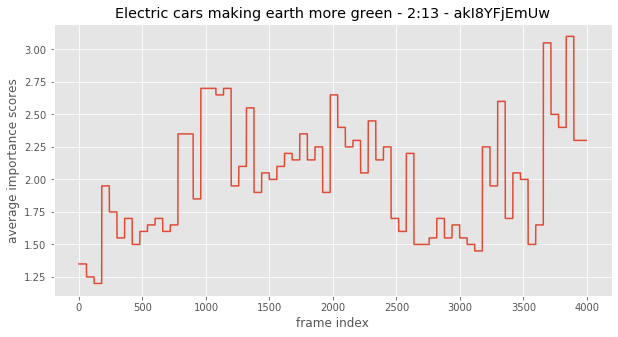

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(avg_scores_sample))
ax.set_xlabel('frame index')
ax.set_ylabel('average importance scores')
ax.set_title('Electric cars making earth more green - 2:13 - akI8YFjEmUw')
ax.plot(x, avg_scores_sample)

In [83]:
def plot_average_importance_scores(avg_scores, title):
  fig, ax = plt.subplots(figsize=(10, 5))
  x = range(len(avg_scores))
  ax.set_xlabel('frame index')
  ax.set_ylabel('average importance scores')
  ax.set_title(title)
  ax.plot(x, avg_scores)

In [53]:
def sort_frames(list_of_frames, video_id, data_set='train'):
    return sorted(list_of_frames, key=lambda x: int(x.split(f'data/frames/{data_set}/{video_id}/')[1].split('.jpg')[0]))

In [54]:
def rgb_features(image_list, bins):
    features = []
    for frame in image_list:
      cv_img = cv2.imread(frame)
      histr = cv2.calcHist([cv_img], [0, 1, 2], None, [
                           bins, bins, bins], [0, 256, 0, 256, 0, 256])
      cv2.normalize(hist, hist)
      features.append(histr.flatten())
    return features

In [55]:
def hsv_features(image_list, bins):
    features = []
    for frame in image_list:
      cv_img = cv2.imread(frame)
      img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2HSV)
      histr = cv2.calcHist([cv_img], [0, 1, 2], None, [
                           bins, bins, bins], [0, 256, 0, 256, 0, 256])
      cv2.normalize(hist, hist)
      features.append(histr.flatten())
    return features

In [56]:
def get_vgg_features(image_list):
  image_features = []
  base_model = VGG16(weights='imagenet', include_top=False)
  model = Model(inputs=base_model.input,
                outputs=base_model.get_layer('block5_conv3').output)

  for idx, frame in enumerate(image_list):
    img = image.load_img(frame, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg16_feature = model.predict(img_data)
    image_features.append(np.array(vgg16_feature).flatten())
    print(f'complete for {idx}')

  return image_features

In [57]:
def create_train_or_test_data_set_for_rgb(data_set='train'):
  X = 'first'
  y = 'first'
  for directory in glob.glob(f'data/frames/{data_set}/*'):
      frames = glob.glob(f'{directory}/*')
      video_id = directory.split(f'data/frames/{data_set}/')[1]
      sorted_frames = sort_frames(frames, video_id, data_set=data_set)
      if X == 'first':
          X = rgb_features(sorted_frames, 8)
      else:
          X = np.concatenate(
              (X, rgb_features(sorted_frames, 8)), axis=0)
      scores = average_scores[average_scores['filename'] ==
                              video_id]['average_score'].values[0].reshape(-1, 1)
      if y == 'first':
          y = scores
      else:
          y = np.concatenate((y, scores), axis=0)
      print(f'complete for {video_id}')
      print(np.array(X).shape, np.array(y).shape)
  X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
  return X, y

In [58]:
def create_train_or_test_data_set_for_hsv(data_set='train'):
  X = 'first'
  y = 'first'
  for directory in glob.glob(f'data/frames/{data_set}/*'):
      frames = glob.glob(f'{directory}/*')
      video_id = directory.split(f'data/frames/{data_set}/')[1]
      sorted_frames = sort_frames(frames, video_id, data_set=data_set)
      if X == 'first':
          X = hsv_features(sorted_frames, 8)
      else:
          X = np.concatenate(
              (X, rgb_features(sorted_frames, 8)), axis=0)
      scores = average_scores[average_scores['filename'] == video_id]['average_score'].values[0].reshape(-1, 1)
      if y == 'first':
          y = scores
      else:
          y = np.concatenate((y, scores), axis=0)
      print(f'complete for {video_id}')
      print(np.array(X).shape, np.array(y).shape)
  X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
  return X, y

In [59]:
def sort_frames(list_of_frames, video_id, data_set='train'):
    return sorted(list_of_frames, key=lambda x: int(x.split(f'data/frames/{data_set}/{video_id}/')[1].split('.jpg')[0]))

In [61]:
def create_train_set_for_vgg(data_set='train'):
  X = 'first'
  y = 'first'
  for directory in glob.glob(f'data/frames/{data_set}/*')[0:18]:
      frames = glob.glob(f'{directory}/*')
      video_id = directory.split(f'data/frames/{data_set}/')[1]
      sorted_frames = sort_frames(frames, video_id, data_set=data_set)
      if X == 'first':
          X = get_vgg_features(sorted_frames)
      else:
          X = np.concatenate((X, get_vgg_features(sorted_frames)))
      print(f'complete for {video_id}')
      print(np.array(X).shape, np.array(y).shape)
  X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
  return X

In [62]:
X_train_vgg = create_train_set_for_vgg(data_set='train')

complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete for 36
complete for 37
complete for 38
complete for 39
complete for 40
complete for 41
complete for 42
complete for 43
complete for 44
complete for 45
complete for 46
complete for 47
complete for 48
complete for 49
complete for 50
complete for 51
complete for 52
complete for 53
complete for 54
complete for 55
complete for 56
complete for 57
complete for 58
complete for 59
complete for 60
complete for 61
complete for 62
co

complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 522
complete for 523
complete for 524
complete for 525
complete for 526
complete for 527
complete for 528
complete for 529
complete for 530
complete for 531
complete for 532
complete for 533
complete for 534
complete for 535
complete for 536
complete for 537
complete for 538
complete for 539
complete for 540
complete for 541
complete for 542
complete for 543
complete for 544
complete for 545
complete for 546
complete for 547
complete for 5

complete for 972
complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete for 1005
complete for 1006
complete for 1007
complete for 1008
complete for 1009
complete for 1010
complete for 1011
complete for 1012
complete for 1013
complete for 1014
complete for 1015
complete for 1016
complete for 1017
complete for 1018
complete for 1019
complete for 1020
complete for 1021
complete for 1022
complete for 1023
complete for 1024
complete for 1025
complete for 1026
complete for 1027
complete for 1028
co

complete for 1429
complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete for 1462
complete for 1463
complete for 1464
complete for 1465
complete for 1466
complete for 1467
complete for 1468
complete for 1469
complete for 1470
complete for 1471
complete for 1472
complete for 1473
complete for 1474
complete for 1475
complete for 1476
complete for 1477
complete for 1478
complete for 1479
complete for 1480
complete for 1481
complete for 1482
complete for 1483
complete f

complete for 1885
complete for 1886
complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete for 1919
complete for 1920
complete for 1921
complete for 1922
complete for 1923
complete for 1924
complete for 1925
complete for 1926
complete for 1927
complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete for 1932
complete for 1933
complete for 1934
complete for 1935
complete for 1936
complete for 1937
complete for 1938
complete for 1939
complete f

complete for 2342
complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete for 2376
complete for 2377
complete for 2378
complete for 2379
complete for 2380
complete for 2381
complete for 2382
complete for 2383
complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete for 2388
complete for 2389
complete for 2390
complete for 2391
complete for 2392
complete for 2393
complete for 2394
complete for 2395
complete for 2396
complete f

complete for 2799
complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete for 2832
complete for 2833
complete for 2834
complete for 2835
complete for 2836
complete for 2837
complete for 2838
complete for 2839
complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete for 2845
complete for 2846
complete for 2847
complete for 2848
complete for 2849
complete for 2850
complete for 2851
complete for 2852
complete for 2853
complete f

complete for 3255
complete for 3256
complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete for 3289
complete for 3290
complete for 3291
complete for 3292
complete for 3293
complete for 3294
complete for 3295
complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete for 3302
complete for 3303
complete for 3304
complete for 3305
complete for 3306
complete for 3307
complete for 3308
complete for 3309
complete f

complete for 3711
complete for 3712
complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete for 3745
complete for 3746
complete for 3747
complete for 3748
complete for 3749
complete for 3750
complete for 3751
complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete for 3758
complete for 3759
complete for 3760
complete for 3761
complete for 3762
complete for 3763
complete for 3764
complete for 3765
complete f

complete for 4167
complete for 4168
complete for 4169
complete for 4170
complete for 4171
complete for 4172
complete for 4173
complete for 4174
complete for 4175
complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete for 4183
complete for 4184
complete for 4185
complete for 4186
complete for 4187
complete for 4188
complete for 4189
complete for 4190
complete for 4191
complete for 4192
complete for 4193
complete for 4194
complete for 4195
complete for 4196
complete for 4197
complete for 4198
complete for 4199
complete for 4200
complete for 4201
complete for 4202
complete for 4203
complete for 4204
complete for 4205
complete for 4206
complete for 4207
complete for 4208
complete for 4209
complete for 4210
complete for 4211
complete for 4212
complete for 4213
complete for 4214
complete for 4215
complete for 4216
complete for 4217
complete for 4218
complete for 4219
complete for 4220
complete for 4221
complete f

complete for 168
complete for 169
complete for 170
complete for 171
complete for 172
complete for 173
complete for 174
complete for 175
complete for 176
complete for 177
complete for 178
complete for 179
complete for 180
complete for 181
complete for 182
complete for 183
complete for 184
complete for 185
complete for 186
complete for 187
complete for 188
complete for 189
complete for 190
complete for 191
complete for 192
complete for 193
complete for 194
complete for 195
complete for 196
complete for 197
complete for 198
complete for 199
complete for 200
complete for 201
complete for 202
complete for 203
complete for 204
complete for 205
complete for 206
complete for 207
complete for 208
complete for 209
complete for 210
complete for 211
complete for 212
complete for 213
complete for 214
complete for 215
complete for 216
complete for 217
complete for 218
complete for 219
complete for 220
complete for 221
complete for 222
complete for 223
complete for 224
complete for 225
complete for 2

complete for 651
complete for 652
complete for 653
complete for 654
complete for 655
complete for 656
complete for 657
complete for 658
complete for 659
complete for 660
complete for 661
complete for 662
complete for 663
complete for 664
complete for 665
complete for 666
complete for 667
complete for 668
complete for 669
complete for 670
complete for 671
complete for 672
complete for 673
complete for 674
complete for 675
complete for 676
complete for 677
complete for 678
complete for 679
complete for 680
complete for 681
complete for 682
complete for 683
complete for 684
complete for 685
complete for 686
complete for 687
complete for 688
complete for 689
complete for 690
complete for 691
complete for 692
complete for 693
complete for 694
complete for 695
complete for 696
complete for 697
complete for 698
complete for 699
complete for 700
complete for 701
complete for 702
complete for 703
complete for 704
complete for 705
complete for 706
complete for 707
complete for 708
complete for 7

complete for 1127
complete for 1128
complete for 1129
complete for 1130
complete for 1131
complete for 1132
complete for 1133
complete for 1134
complete for 1135
complete for 1136
complete for 1137
complete for 1138
complete for 1139
complete for 1140
complete for 1141
complete for 1142
complete for 1143
complete for 1144
complete for 1145
complete for 1146
complete for 1147
complete for 1148
complete for 1149
complete for 1150
complete for 1151
complete for 1152
complete for 1153
complete for 1154
complete for 1155
complete for 1156
complete for 1157
complete for 1158
complete for 1159
complete for 1160
complete for 1161
complete for 1162
complete for 1163
complete for 1164
complete for 1165
complete for 1166
complete for 1167
complete for 1168
complete for 1169
complete for 1170
complete for 1171
complete for 1172
complete for 1173
complete for 1174
complete for 1175
complete for 1176
complete for 1177
complete for 1178
complete for 1179
complete for 1180
complete for 1181
complete f

complete for 1584
complete for 1585
complete for 1586
complete for 1587
complete for 1588
complete for 1589
complete for 1590
complete for 1591
complete for 1592
complete for 1593
complete for 1594
complete for 1595
complete for 1596
complete for 1597
complete for 1598
complete for 1599
complete for 1600
complete for 1601
complete for 1602
complete for 1603
complete for 1604
complete for 1605
complete for 1606
complete for 1607
complete for 1608
complete for 1609
complete for 1610
complete for 1611
complete for 1612
complete for 1613
complete for 1614
complete for 1615
complete for 1616
complete for 1617
complete for 1618
complete for 1619
complete for 1620
complete for 1621
complete for 1622
complete for 1623
complete for 1624
complete for 1625
complete for 1626
complete for 1627
complete for 1628
complete for 1629
complete for 1630
complete for 1631
complete for 1632
complete for 1633
complete for 1634
complete for 1635
complete for 1636
complete for 1637
complete for 1638
complete f

complete for 2040
complete for 2041
complete for 2042
complete for 2043
complete for 2044
complete for 2045
complete for 2046
complete for 2047
complete for 2048
complete for 2049
complete for 2050
complete for 2051
complete for 2052
complete for 2053
complete for 2054
complete for 2055
complete for 2056
complete for 2057
complete for 2058
complete for 2059
complete for 2060
complete for 2061
complete for 2062
complete for 2063
complete for 2064
complete for 2065
complete for 2066
complete for 2067
complete for 2068
complete for 2069
complete for 2070
complete for 2071
complete for 2072
complete for 2073
complete for 2074
complete for 2075
complete for 2076
complete for 2077
complete for 2078
complete for 2079
complete for 2080
complete for 2081
complete for 2082
complete for 2083
complete for 2084
complete for 2085
complete for 2086
complete for 2087
complete for 2088
complete for 2089
complete for 2090
complete for 2091
complete for 2092
complete for 2093
complete for 2094
complete f

complete for 2497
complete for 2498
complete for 2499
complete for 2500
complete for 2501
complete for 2502
complete for 2503
complete for 2504
complete for 2505
complete for 2506
complete for 2507
complete for 2508
complete for 2509
complete for 2510
complete for 2511
complete for 2512
complete for 2513
complete for 2514
complete for 2515
complete for 2516
complete for 2517
complete for 2518
complete for 2519
complete for 2520
complete for 2521
complete for 2522
complete for 2523
complete for 2524
complete for 2525
complete for 2526
complete for 2527
complete for 2528
complete for 2529
complete for 2530
complete for 2531
complete for 2532
complete for 2533
complete for 2534
complete for 2535
complete for 2536
complete for 2537
complete for 2538
complete for 2539
complete for 2540
complete for 2541
complete for 2542
complete for 2543
complete for 2544
complete for 2545
complete for 2546
complete for 2547
complete for 2548
complete for 2549
complete for 2550
complete for 2551
complete f

complete for 2954
complete for 2955
complete for 2956
complete for 2957
complete for 2958
complete for 2959
complete for 2960
complete for 2961
complete for 2962
complete for 2963
complete for 2964
complete for 2965
complete for 2966
complete for 2967
complete for 2968
complete for 2969
complete for 2970
complete for 2971
complete for 2972
complete for 2973
complete for 2974
complete for 2975
complete for 2976
complete for 2977
complete for 2978
complete for 2979
complete for 2980
complete for 2981
complete for 2982
complete for 2983
complete for 2984
complete for 2985
complete for 2986
complete for 2987
complete for 2988
complete for 2989
complete for 2990
complete for 2991
complete for 2992
complete for 2993
complete for 2994
complete for 2995
complete for 2996
complete for 2997
complete for 2998
complete for 2999
complete for 3000
complete for 3001
complete for 3002
complete for 3003
complete for 3004
complete for 3005
complete for 3006
complete for 3007
complete for 3008
complete f

complete for 3411
complete for 3412
complete for 3413
complete for 3414
complete for 3415
complete for 3416
complete for 3417
complete for 3418
complete for 3419
complete for 3420
complete for 3421
complete for 3422
complete for 3423
complete for 3424
complete for 3425
complete for 3426
complete for 3427
complete for 3428
complete for 3429
complete for 3430
complete for 3431
complete for 3432
complete for 3433
complete for 3434
complete for 3435
complete for 3436
complete for 3437
complete for 3438
complete for 3439
complete for 3440
complete for 3441
complete for 3442
complete for 3443
complete for 3444
complete for 3445
complete for 3446
complete for 3447
complete for 3448
complete for 3449
complete for 3450
complete for 3451
complete for 3452
complete for 3453
complete for 3454
complete for 3455
complete for 3456
complete for 3457
complete for 3458
complete for 3459
complete for 3460
complete for 3461
complete for 3462
complete for 3463
complete for 3464
complete for 3465
complete f

complete for 3867
complete for 3868
complete for 3869
complete for 3870
complete for 3871
complete for 3872
complete for 3873
complete for 3874
complete for 3875
complete for 3876
complete for 3877
complete for 3878
complete for 3879
complete for 3880
complete for 3881
complete for 3882
complete for 3883
complete for 3884
complete for 3885
complete for 3886
complete for 3887
complete for 3888
complete for 3889
complete for 3890
complete for 3891
complete for 3892
complete for 3893
complete for 3894
complete for 3895
complete for 3896
complete for 3897
complete for 3898
complete for 3899
complete for 3900
complete for 3901
complete for 3902
complete for 3903
complete for 3904
complete for 3905
complete for 3906
complete for 3907
complete for 3908
complete for 3909
complete for 3910
complete for 3911
complete for 3912
complete for 3913
complete for 3914
complete for 3915
complete for 3916
complete for 3917
complete for 3918
complete for 3919
complete for 3920
complete for 3921
complete f

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete for 36
complete for 37
complete for 38
complete for 39
complete for 40
complete for 41
complete for 42
complete for 43
complete for 44
complete for 45
complete for 46
complete for 47
complete for 48
complete for 49
complete for 50
complete for 51
complete for 52
complete for 53
complete for 54
complete for 55
complete for 56
complete for 57
complete for 58
complete for 59
complete for 60
complete for 61
complete for 62
co

complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 522
complete for 523
complete for 524
complete for 525
complete for 526
complete for 527
complete for 528
complete for 529
complete for 530
complete for 531
complete for 532
complete for 533
complete for 534
complete for 535
complete for 536
complete for 537
complete for 538
complete for 539
complete for 540
complete for 541
complete for 542
complete for 543
complete for 544
complete for 545
complete for 546
complete for 547
complete for 5

complete for 972
complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete for 1005
complete for 1006
complete for 1007
complete for 1008
complete for 1009
complete for 1010
complete for 1011
complete for 1012
complete for 1013
complete for 1014
complete for 1015
complete for 1016
complete for 1017
complete for 1018
complete for 1019
complete for 1020
complete for 1021
complete for 1022
complete for 1023
complete for 1024
complete for 1025
complete for 1026
complete for 1027
complete for 1028
co

complete for 1429
complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete for 1462
complete for 1463
complete for 1464
complete for 1465
complete for 1466
complete for 1467
complete for 1468
complete for 1469
complete for 1470
complete for 1471
complete for 1472
complete for 1473
complete for 1474
complete for 1475
complete for 1476
complete for 1477
complete for 1478
complete for 1479
complete for 1480
complete for 1481
complete for 1482
complete for 1483
complete f

complete for 1886
complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete for 1919
complete for 1920
complete for 1921
complete for 1922
complete for 1923
complete for 1924
complete for 1925
complete for 1926
complete for 1927
complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete for 1932
complete for 1933
complete for 1934
complete for 1935
complete for 1936
complete for 1937
complete for 1938
complete for 1939
complete for 1940
complete f

complete for 2342
complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete for 2376
complete for 2377
complete for 2378
complete for 2379
complete for 2380
complete for 2381
complete for 2382
complete for 2383
complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete for 2388
complete for 2389
complete for 2390
complete for 2391
complete for 2392
complete for 2393
complete for 2394
complete for 2395
complete for 2396
complete f

complete for 2799
complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete for 2832
complete for 2833
complete for 2834
complete for 2835
complete for 2836
complete for 2837
complete for 2838
complete for 2839
complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete for 2845
complete for 2846
complete for 2847
complete for 2848
complete for 2849
complete for 2850
complete for 2851
complete for 2852
complete for 2853
complete f

complete for 3256
complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete for 3289
complete for 3290
complete for 3291
complete for 3292
complete for 3293
complete for 3294
complete for 3295
complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete for 3302
complete for 3303
complete for 3304
complete for 3305
complete for 3306
complete for 3307
complete for 3308
complete for 3309
complete for 3310
complete f

complete for 3712
complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete for 3745
complete for 3746
complete for 3747
complete for 3748
complete for 3749
complete for 3750
complete for 3751
complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete for 3758
complete for 3759
complete for 3760
complete for 3761
complete for 3762
complete for 3763
complete for 3764
complete for 3765
complete for 3766
complete f

complete for 392
complete for 393
complete for 394
complete for 395
complete for 396
complete for 397
complete for 398
complete for 399
complete for 400
complete for 401
complete for 402
complete for 403
complete for 404
complete for 405
complete for 406
complete for 407
complete for 408
complete for 409
complete for 410
complete for 411
complete for 412
complete for 413
complete for 414
complete for 415
complete for 416
complete for 417
complete for 418
complete for 419
complete for 420
complete for 421
complete for 422
complete for 423
complete for 424
complete for 425
complete for 426
complete for 427
complete for 428
complete for 429
complete for 430
complete for 431
complete for 432
complete for 433
complete for 434
complete for 435
complete for 436
complete for 437
complete for 438
complete for 439
complete for 440
complete for 441
complete for 442
complete for 443
complete for 444
complete for 445
complete for 446
complete for 447
complete for 448
complete for 449
complete for 4

complete for 874
complete for 875
complete for 876
complete for 877
complete for 878
complete for 879
complete for 880
complete for 881
complete for 882
complete for 883
complete for 884
complete for 885
complete for 886
complete for 887
complete for 888
complete for 889
complete for 890
complete for 891
complete for 892
complete for 893
complete for 894
complete for 895
complete for 896
complete for 897
complete for 898
complete for 899
complete for 900
complete for 901
complete for 902
complete for 903
complete for 904
complete for 905
complete for 906
complete for 907
complete for 908
complete for 909
complete for 910
complete for 911
complete for 912
complete for 913
complete for 914
complete for 915
complete for 916
complete for 917
complete for 918
complete for 919
complete for 920
complete for 921
complete for 922
complete for 923
complete for 924
complete for 925
complete for 926
complete for 927
complete for 928
complete for 929
complete for 930
complete for 931
complete for 9

complete for 1338
complete for 1339
complete for 1340
complete for 1341
complete for 1342
complete for 1343
complete for 1344
complete for 1345
complete for 1346
complete for 1347
complete for 1348
complete for 1349
complete for 1350
complete for 1351
complete for 1352
complete for 1353
complete for 1354
complete for 1355
complete for 1356
complete for 1357
complete for 1358
complete for 1359
complete for 1360
complete for 1361
complete for 1362
complete for 1363
complete for 1364
complete for 1365
complete for 1366
complete for 1367
complete for 1368
complete for 1369
complete for 1370
complete for 1371
complete for 1372
complete for 1373
complete for 1374
complete for 1375
complete for 1376
complete for 1377
complete for 1378
complete for 1379
complete for 1380
complete for 1381
complete for 1382
complete for 1383
complete for 1384
complete for 1385
complete for 1386
complete for 1387
complete for 1388
complete for 1389
complete for 1390
complete for 1391
complete for 1392
complete f

complete for 1795
complete for 1796
complete for 1797
complete for 1798
complete for 1799
complete for 1800
complete for 1801
complete for 1802
complete for 1803
complete for 1804
complete for 1805
complete for 1806
complete for 1807
complete for 1808
complete for 1809
complete for 1810
complete for 1811
complete for 1812
complete for 1813
complete for 1814
complete for 1815
complete for 1816
complete for 1817
complete for 1818
complete for 1819
complete for 1820
complete for 1821
complete for 1822
complete for 1823
complete for 1824
complete for 1825
complete for 1826
complete for 1827
complete for 1828
complete for 1829
complete for 1830
complete for 1831
complete for 1832
complete for 1833
complete for 1834
complete for 1835
complete for 1836
complete for 1837
complete for 1838
complete for 1839
complete for 1840
complete for 1841
complete for 1842
complete for 1843
complete for 1844
complete for 1845
complete for 1846
complete for 1847
complete for 1848
complete for 1849
complete f

complete for 2252
complete for 2253
complete for 2254
complete for 2255
complete for 2256
complete for 2257
complete for 2258
complete for 2259
complete for 2260
complete for 2261
complete for 2262
complete for 2263
complete for 2264
complete for 2265
complete for 2266
complete for 2267
complete for 2268
complete for 2269
complete for 2270
complete for 2271
complete for 2272
complete for 2273
complete for 2274
complete for 2275
complete for 2276
complete for 2277
complete for 2278
complete for 2279
complete for 2280
complete for 2281
complete for 2282
complete for 2283
complete for 2284
complete for 2285
complete for 2286
complete for 2287
complete for 2288
complete for 2289
complete for 2290
complete for 2291
complete for 2292
complete for 2293
complete for 2294
complete for 2295
complete for 2296
complete for 2297
complete for 2298
complete for 2299
complete for 2300
complete for 2301
complete for 2302
complete for 2303
complete for 2304
complete for 2305
complete for 2306
complete f

complete for 2709
complete for 2710
complete for 2711
complete for 2712
complete for 2713
complete for 2714
complete for 2715
complete for 2716
complete for 2717
complete for 2718
complete for 2719
complete for 2720
complete for 2721
complete for 2722
complete for 2723
complete for 2724
complete for 2725
complete for 2726
complete for 2727
complete for 2728
complete for 2729
complete for 2730
complete for 2731
complete for 2732
complete for 2733
complete for 2734
complete for 2735
complete for 2736
complete for 2737
complete for 2738
complete for 2739
complete for 2740
complete for 2741
complete for 2742
complete for 2743
complete for 2744
complete for 2745
complete for 2746
complete for 2747
complete for 2748
complete for 2749
complete for 2750
complete for 2751
complete for 2752
complete for 2753
complete for 2754
complete for 2755
complete for 2756
complete for 2757
complete for 2758
complete for 2759
complete for 2760
complete for 2761
complete for 2762
complete for 2763
complete f

complete for 3166
complete for 3167
complete for 3168
complete for 3169
complete for 3170
complete for 3171
complete for 3172
complete for 3173
complete for 3174
complete for 3175
complete for 3176
complete for 3177
complete for 3178
complete for 3179
complete for 3180
complete for 3181
complete for 3182
complete for 3183
complete for 3184
complete for 3185
complete for 3186
complete for 3187
complete for 3188
complete for 3189
complete for 3190
complete for 3191
complete for 3192
complete for 3193
complete for 3194
complete for 3195
complete for 3196
complete for 3197
complete for 3198
complete for 3199
complete for 3200
complete for 3201
complete for 3202
complete for 3203
complete for 3204
complete for 3205
complete for 3206
complete for 3207
complete for 3208
complete for 3209
complete for 3210
complete for 3211
complete for 3212
complete for 3213
complete for 3214
complete for 3215
complete for 3216
complete for 3217
complete for 3218
complete for 3219
complete for 3220
complete f

complete for 3622
complete for 3623
complete for 3624
complete for 3625
complete for 3626
complete for 3627
complete for 3628
complete for 3629
complete for 3630
complete for 3631
complete for 3632
complete for 3633
complete for 3634
complete for 3635
complete for 3636
complete for 3637
complete for 3638
complete for 3639
complete for 3640
complete for 3641
complete for 3642
complete for 3643
complete for 3644
complete for 3645
complete for 3646
complete for 3647
complete for 3648
complete for 3649
complete for 3650
complete for 3651
complete for 3652
complete for 3653
complete for 3654
complete for 3655
complete for 3656
complete for 3657
complete for 3658
complete for 3659
complete for 3660
complete for 3661
complete for 3662
complete for 3663
complete for 3664
complete for 3665
complete for 3666
complete for 3667
complete for 3668
complete for 3669
complete for 3670
complete for 3671
complete for 3672
complete for 3673
complete for 3674
complete for 3675
complete for 3676
complete f

complete for 4079
complete for 4080
complete for 4081
complete for 4082
complete for 4083
complete for 4084
complete for 4085
complete for 4086
complete for 4087
complete for 4088
complete for 4089
complete for 4090
complete for 4091
complete for 4092
complete for 4093
complete for 4094
complete for 4095
complete for 4096
complete for 4097
complete for 4098
complete for 4099
complete for 4100
complete for 4101
complete for 4102
complete for 4103
complete for 4104
complete for 4105
complete for 4106
complete for 4107
complete for 4108
complete for 4109
complete for 4110
complete for 4111
complete for 4112
complete for 4113
complete for 4114
complete for 4115
complete for 4116
complete for 4117
complete for 4118
complete for 4119
complete for 4120
complete for 4121
complete for 4122
complete for 4123
complete for 4124
complete for 4125
complete for 4126
complete for 4127
complete for 4128
complete for 4129
complete for 4130
complete for 4131
complete for 4132
complete for 4133
complete f

complete for 193
complete for 194
complete for 195
complete for 196
complete for 197
complete for 198
complete for 199
complete for 200
complete for 201
complete for 202
complete for 203
complete for 204
complete for 205
complete for 206
complete for 207
complete for 208
complete for 209
complete for 210
complete for 211
complete for 212
complete for 213
complete for 214
complete for 215
complete for 216
complete for 217
complete for 218
complete for 219
complete for 220
complete for 221
complete for 222
complete for 223
complete for 224
complete for 225
complete for 226
complete for 227
complete for 228
complete for 229
complete for 230
complete for 231
complete for 232
complete for 233
complete for 234
complete for 235
complete for 236
complete for 237
complete for 238
complete for 239
complete for 240
complete for 241
complete for 242
complete for 243
complete for 244
complete for 245
complete for 246
complete for 247
complete for 248
complete for 249
complete for 250
complete for 2

complete for 675
complete for 676
complete for 677
complete for 678
complete for 679
complete for 680
complete for 681
complete for 682
complete for 683
complete for 684
complete for 685
complete for 686
complete for 687
complete for 688
complete for 689
complete for 690
complete for 691
complete for 692
complete for 693
complete for 694
complete for 695
complete for 696
complete for 697
complete for 698
complete for 699
complete for 700
complete for 701
complete for 702
complete for 703
complete for 704
complete for 705
complete for 706
complete for 707
complete for 708
complete for 709
complete for 710
complete for 711
complete for 712
complete for 713
complete for 714
complete for 715
complete for 716
complete for 717
complete for 718
complete for 719
complete for 720
complete for 721
complete for 722
complete for 723
complete for 724
complete for 725
complete for 726
complete for 727
complete for 728
complete for 729
complete for 730
complete for 731
complete for 732
complete for 7

complete for 1149
complete for 1150
complete for 1151
complete for 1152
complete for 1153
complete for 1154
complete for 1155
complete for 1156
complete for 1157
complete for 1158
complete for 1159
complete for 1160
complete for 1161
complete for 1162
complete for 1163
complete for 1164
complete for 1165
complete for 1166
complete for 1167
complete for 1168
complete for 1169
complete for 1170
complete for 1171
complete for 1172
complete for 1173
complete for 1174
complete for 1175
complete for 1176
complete for 1177
complete for 1178
complete for 1179
complete for 1180
complete for 1181
complete for 1182
complete for 1183
complete for 1184
complete for 1185
complete for 1186
complete for 1187
complete for 1188
complete for 1189
complete for 1190
complete for 1191
complete for 1192
complete for 1193
complete for 1194
complete for 1195
complete for 1196
complete for 1197
complete for 1198
complete for 1199
complete for 1200
complete for 1201
complete for 1202
complete for 1203
complete f

complete for 1606
complete for 1607
complete for 1608
complete for 1609
complete for 1610
complete for 1611
complete for 1612
complete for 1613
complete for 1614
complete for 1615
complete for 1616
complete for 1617
complete for 1618
complete for 1619
complete for 1620
complete for 1621
complete for 1622
complete for 1623
complete for 1624
complete for 1625
complete for 1626
complete for 1627
complete for 1628
complete for 1629
complete for 1630
complete for 1631
complete for 1632
complete for 1633
complete for 1634
complete for 1635
complete for 1636
complete for 1637
complete for 1638
complete for 1639
complete for 1640
complete for 1641
complete for 1642
complete for 1643
complete for 1644
complete for 1645
complete for 1646
complete for 1647
complete for 1648
complete for 1649
complete for 1650
complete for 1651
complete for 1652
complete for 1653
complete for 1654
complete for 1655
complete for 1656
complete for 1657
complete for 1658
complete for 1659
complete for 1660
complete f

complete for 2063
complete for 2064
complete for 2065
complete for 2066
complete for 2067
complete for 2068
complete for 2069
complete for 2070
complete for 2071
complete for 2072
complete for 2073
complete for 2074
complete for 2075
complete for 2076
complete for 2077
complete for 2078
complete for 2079
complete for 2080
complete for 2081
complete for 2082
complete for 2083
complete for 2084
complete for 2085
complete for 2086
complete for 2087
complete for 2088
complete for 2089
complete for 2090
complete for 2091
complete for 2092
complete for 2093
complete for 2094
complete for 2095
complete for 2096
complete for 2097
complete for 2098
complete for 2099
complete for 2100
complete for 2101
complete for 2102
complete for 2103
complete for 2104
complete for 2105
complete for 2106
complete for 2107
complete for 2108
complete for 2109
complete for 2110
complete for 2111
complete for 2112
complete for 2113
complete for 2114
complete for 2115
complete for 2116
complete for 2117
complete f

complete for 2520
complete for 2521
complete for 2522
complete for 2523
complete for 2524
complete for 2525
complete for 2526
complete for 2527
complete for 2528
complete for 2529
complete for 2530
complete for 2531
complete for 2532
complete for 2533
complete for 2534
complete for 2535
complete for 2536
complete for 2537
complete for 2538
complete for 2539
complete for 2540
complete for 2541
complete for 2542
complete for 2543
complete for 2544
complete for 2545
complete for 2546
complete for 2547
complete for 2548
complete for 2549
complete for 2550
complete for 2551
complete for 2552
complete for 2553
complete for 2554
complete for 2555
complete for 2556
complete for 2557
complete for 2558
complete for 2559
complete for 2560
complete for 2561
complete for 2562
complete for 2563
complete for 2564
complete for 2565
complete for 2566
complete for 2567
complete for 2568
complete for 2569
complete for 2570
complete for 2571
complete for 2572
complete for 2573
complete for 2574
complete f

complete for 2976
complete for 2977
complete for 2978
complete for 2979
complete for 2980
complete for 2981
complete for 2982
complete for 2983
complete for 2984
complete for 2985
complete for 2986
complete for 2987
complete for 2988
complete for 2989
complete for 2990
complete for 2991
complete for 2992
complete for 2993
complete for 2994
complete for 2995
complete for 2996
complete for 2997
complete for 2998
complete for 2999
complete for 3000
complete for 3001
complete for 3002
complete for 3003
complete for 3004
complete for 3005
complete for 3006
complete for 3007
complete for 3008
complete for 3009
complete for 3010
complete for 3011
complete for 3012
complete for 3013
complete for 3014
complete for 3015
complete for 3016
complete for 3017
complete for 3018
complete for 3019
complete for 3020
complete for 3021
complete for 3022
complete for 3023
complete for 3024
complete for 3025
complete for 3026
complete for 3027
complete for 3028
complete for 3029
complete for 3030
complete f

complete for 3432
complete for 3433
complete for 3434
complete for 3435
complete for 3436
complete for 3437
complete for 3438
complete for 3439
complete for 3440
complete for 3441
complete for 3442
complete for 3443
complete for 3444
complete for 3445
complete for 3446
complete for 3447
complete for 3448
complete for 3449
complete for 3450
complete for 3451
complete for 3452
complete for 3453
complete for 3454
complete for 3455
complete for 3456
complete for 3457
complete for 3458
complete for 3459
complete for 3460
complete for 3461
complete for 3462
complete for 3463
complete for 3464
complete for 3465
complete for 3466
complete for 3467
complete for 3468
complete for 3469
complete for 3470
complete for 3471
complete for 3472
complete for 3473
complete for 3474
complete for 3475
complete for 3476
complete for 3477
complete for 3478
complete for 3479
complete for 3480
complete for 3481
complete for 3482
complete for 3483
complete for 3484
complete for 3485
complete for 3486
complete f

complete for 3888
complete for 3889
complete for 3890
complete for 3891
complete for 3892
complete for 3893
complete for 3894
complete for 3895
complete for kLxoNp-UchI
(20531, 100352) ()
complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete for 36
complete for 37
complete for 38
complete for 39
complete for 40
complete for 41
complete for 42
complete for 43
complete for 44
complete for 45
complete for 46
complete for 47
complete for 48
complete for 49
complete for 50
comple

complete for 479
complete for 480
complete for 481
complete for 482
complete for 483
complete for 484
complete for 485
complete for 486
complete for 487
complete for 488
complete for 489
complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 522
complete for 523
complete for 524
complete for 525
complete for 526
complete for 527
complete for 528
complete for 529
complete for 530
complete for 531
complete for 532
complete for 533
complete for 534
complete for 535
complete for 536
complete for 5

complete for 961
complete for 962
complete for 963
complete for 964
complete for 965
complete for 966
complete for 967
complete for 968
complete for 969
complete for 970
complete for 971
complete for 972
complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete for 1005
complete for 1006
complete for 1007
complete for 1008
complete for 1009
complete for 1010
complete for 1011
complete for 1012
complete for 1013
complete for 1014
complete for 1015
complete for 1016
complete for 1017
complete for 

complete for 1420
complete for 1421
complete for 1422
complete for 1423
complete for 1424
complete for 1425
complete for 1426
complete for 1427
complete for 1428
complete for 1429
complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete for 1462
complete for 1463
complete for 1464
complete for 1465
complete for 1466
complete for 1467
complete for 1468
complete for 1469
complete for 1470
complete for 1471
complete for 1472
complete for 1473
complete for 1474
complete f

complete for 1877
complete for 1878
complete for 1879
complete for 1880
complete for 1881
complete for 1882
complete for 1883
complete for 1884
complete for 1885
complete for 1886
complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete for 1919
complete for 1920
complete for 1921
complete for 1922
complete for 1923
complete for 1924
complete for 1925
complete for 1926
complete for 1927
complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete f

complete for 2333
complete for 2334
complete for 2335
complete for 2336
complete for 2337
complete for 2338
complete for 2339
complete for 2340
complete for 2341
complete for 2342
complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete for 2376
complete for 2377
complete for 2378
complete for 2379
complete for 2380
complete for 2381
complete for 2382
complete for 2383
complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete f

complete for 2790
complete for 2791
complete for 2792
complete for 2793
complete for 2794
complete for 2795
complete for 2796
complete for 2797
complete for 2798
complete for 2799
complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete for 2832
complete for 2833
complete for 2834
complete for 2835
complete for 2836
complete for 2837
complete for 2838
complete for 2839
complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete f

complete for 3247
complete for 3248
complete for 3249
complete for 3250
complete for 3251
complete for 3252
complete for 3253
complete for 3254
complete for 3255
complete for 3256
complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete for 3289
complete for 3290
complete for 3291
complete for 3292
complete for 3293
complete for 3294
complete for 3295
complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete f

complete for 3703
complete for 3704
complete for 3705
complete for 3706
complete for 3707
complete for 3708
complete for 3709
complete for 3710
complete for 3711
complete for 3712
complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete for 3745
complete for 3746
complete for 3747
complete for 3748
complete for 3749
complete for 3750
complete for 3751
complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete f

complete for 4159
complete for 4160
complete for 4161
complete for 4162
complete for 4163
complete for 4164
complete for 4165
complete for 4166
complete for 4167
complete for 4168
complete for 4169
complete for 4170
complete for 4171
complete for 4172
complete for 4173
complete for 4174
complete for 4175
complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete for 4183
complete for 4184
complete for 4185
complete for 4186
complete for 4187
complete for 4188
complete for 4189
complete for 4190
complete for 4191
complete for 4192
complete for 4193
complete for 4194
complete for 4195
complete for 4196
complete for 4197
complete for 4198
complete for 4199
complete for 4200
complete for 4201
complete for 4202
complete for 4203
complete for 4204
complete for 4205
complete for 4206
complete for 4207
complete for 4208
complete for 4209
complete for 4210
complete for 4211
complete for 4212
complete for 4213
complete f

complete for 4616
complete for 4617
complete for 4618
complete for 4619
complete for 4620
complete for 4621
complete for 4622
complete for 4623
complete for 4624
complete for 4625
complete for 4626
complete for 4627
complete for 4628
complete for 4629
complete for 4630
complete for 4631
complete for 4632
complete for 4633
complete for 4634
complete for 4635
complete for 4636
complete for 4637
complete for 4638
complete for 4639
complete for 4640
complete for 4641
complete for 4642
complete for 4643
complete for 4644
complete for 4645
complete for 4646
complete for 4647
complete for 4648
complete for 4649
complete for 4650
complete for 4651
complete for 4652
complete for 4653
complete for 4654
complete for 4655
complete for 4656
complete for 4657
complete for 4658
complete for 4659
complete for 4660
complete for 4661
complete for 4662
complete for 4663
complete for 4664
complete for 4665
complete for 4666
complete for 4667
complete for 4668
complete for 4669
complete for 4670
complete f

complete for 154
complete for 155
complete for 156
complete for 157
complete for 158
complete for 159
complete for 160
complete for 161
complete for 162
complete for 163
complete for 164
complete for 165
complete for 166
complete for 167
complete for 168
complete for 169
complete for 170
complete for 171
complete for 172
complete for 173
complete for 174
complete for 175
complete for 176
complete for 177
complete for 178
complete for 179
complete for 180
complete for 181
complete for 182
complete for 183
complete for 184
complete for 185
complete for 186
complete for 187
complete for 188
complete for 189
complete for 190
complete for 191
complete for 192
complete for 193
complete for 194
complete for 195
complete for 196
complete for 197
complete for 198
complete for 199
complete for 200
complete for 201
complete for 202
complete for 203
complete for 204
complete for 205
complete for 206
complete for 207
complete for 208
complete for 209
complete for 210
complete for 211
complete for 2

complete for 637
complete for 638
complete for 639
complete for 640
complete for 641
complete for 642
complete for 643
complete for 644
complete for 645
complete for 646
complete for 647
complete for 648
complete for 649
complete for 650
complete for 651
complete for 652
complete for 653
complete for 654
complete for 655
complete for 656
complete for 657
complete for 658
complete for 659
complete for 660
complete for 661
complete for 662
complete for 663
complete for 664
complete for 665
complete for 666
complete for 667
complete for 668
complete for 669
complete for 670
complete for 671
complete for 672
complete for 673
complete for 674
complete for 675
complete for 676
complete for 677
complete for 678
complete for 679
complete for 680
complete for 681
complete for 682
complete for 683
complete for 684
complete for 685
complete for 686
complete for 687
complete for 688
complete for 689
complete for 690
complete for 691
complete for 692
complete for 693
complete for 694
complete for 6

complete for 1113
complete for 1114
complete for 1115
complete for 1116
complete for 1117
complete for 1118
complete for 1119
complete for 1120
complete for 1121
complete for 1122
complete for 1123
complete for 1124
complete for 1125
complete for 1126
complete for 1127
complete for 1128
complete for 1129
complete for 1130
complete for 1131
complete for 1132
complete for 1133
complete for 1134
complete for 1135
complete for 1136
complete for 1137
complete for 1138
complete for 1139
complete for 1140
complete for 1141
complete for 1142
complete for 1143
complete for 1144
complete for 1145
complete for 1146
complete for 1147
complete for 1148
complete for 1149
complete for 1150
complete for 1151
complete for 1152
complete for 1153
complete for 1154
complete for 1155
complete for 1156
complete for 1157
complete for 1158
complete for 1159
complete for 1160
complete for 1161
complete for 1162
complete for 1163
complete for 1164
complete for 1165
complete for 1166
complete for 1167
complete f

complete for 1569
complete for 1570
complete for 1571
complete for 1572
complete for 1573
complete for 1574
complete for 1575
complete for 1576
complete for 1577
complete for 1578
complete for 1579
complete for 1580
complete for 1581
complete for 1582
complete for 1583
complete for 1584
complete for 1585
complete for 1586
complete for 1587
complete for 1588
complete for 1589
complete for 1590
complete for 1591
complete for 1592
complete for 1593
complete for 1594
complete for 1595
complete for 1596
complete for 1597
complete for 1598
complete for 1599
complete for 1600
complete for 1601
complete for 1602
complete for 1603
complete for 1604
complete for 1605
complete for 1606
complete for 1607
complete for 1608
complete for 1609
complete for 1610
complete for 1611
complete for 1612
complete for 1613
complete for 1614
complete for 1615
complete for 1616
complete for 1617
complete for 1618
complete for 1619
complete for 1620
complete for 1621
complete for 1622
complete for 1623
complete f

complete for 2025
complete for 2026
complete for 2027
complete for 2028
complete for 2029
complete for 2030
complete for 2031
complete for 2032
complete for 2033
complete for 2034
complete for 2035
complete for 2036
complete for 2037
complete for 2038
complete for 2039
complete for 2040
complete for 2041
complete for 2042
complete for 2043
complete for 2044
complete for 2045
complete for 2046
complete for 2047
complete for 2048
complete for 2049
complete for 2050
complete for 2051
complete for 2052
complete for 2053
complete for 2054
complete for 2055
complete for 2056
complete for 2057
complete for 2058
complete for 2059
complete for 2060
complete for 2061
complete for 2062
complete for 2063
complete for 2064
complete for 2065
complete for 2066
complete for 2067
complete for 2068
complete for 2069
complete for 2070
complete for 2071
complete for 2072
complete for 2073
complete for 2074
complete for 2075
complete for 2076
complete for 2077
complete for 2078
complete for 2079
complete f

complete for 2482
complete for 2483
complete for 2484
complete for 2485
complete for 2486
complete for 2487
complete for 2488
complete for 2489
complete for 2490
complete for 2491
complete for 2492
complete for 2493
complete for 2494
complete for 2495
complete for 2496
complete for 2497
complete for 2498
complete for 2499
complete for 2500
complete for 2501
complete for 2502
complete for 2503
complete for 2504
complete for 2505
complete for 2506
complete for 2507
complete for 2508
complete for 2509
complete for 2510
complete for 2511
complete for 2512
complete for 2513
complete for 2514
complete for 2515
complete for 2516
complete for 2517
complete for 2518
complete for 2519
complete for 2520
complete for 2521
complete for 2522
complete for 2523
complete for 2524
complete for 2525
complete for 2526
complete for 2527
complete for 2528
complete for 2529
complete for 2530
complete for 2531
complete for 2532
complete for 2533
complete for 2534
complete for 2535
complete for 2536
complete f

complete for 2939
complete for 2940
complete for 2941
complete for 2942
complete for 2943
complete for 2944
complete for 2945
complete for 2946
complete for 2947
complete for 2948
complete for 2949
complete for 2950
complete for 2951
complete for 2952
complete for 2953
complete for 2954
complete for 2955
complete for 2956
complete for 2957
complete for 2958
complete for 2959
complete for 2960
complete for 2961
complete for 2962
complete for 2963
complete for 2964
complete for 2965
complete for 2966
complete for 2967
complete for 2968
complete for 2969
complete for 2970
complete for 2971
complete for 2972
complete for 2973
complete for 2974
complete for 2975
complete for 2976
complete for 2977
complete for 2978
complete for 2979
complete for 2980
complete for 2981
complete for 2982
complete for 2983
complete for 2984
complete for 2985
complete for 2986
complete for 2987
complete for 2988
complete for 2989
complete for 2990
complete for 2991
complete for 2992
complete for 2993
complete f

complete for 3395
complete for 3396
complete for 3397
complete for 3398
complete for 3399
complete for 3400
complete for 3401
complete for 3402
complete for 3403
complete for 3404
complete for 3405
complete for 3406
complete for 3407
complete for 3408
complete for 3409
complete for 3410
complete for 3411
complete for 3412
complete for 3413
complete for 3414
complete for 3415
complete for 3416
complete for 3417
complete for 3418
complete for 3419
complete for 3420
complete for 3421
complete for 3422
complete for 3423
complete for 3424
complete for 3425
complete for 3426
complete for 3427
complete for 3428
complete for 3429
complete for 3430
complete for 3431
complete for 3432
complete for 3433
complete for 3434
complete for 3435
complete for 3436
complete for 3437
complete for 3438
complete for 3439
complete for 3440
complete for 3441
complete for 3442
complete for 3443
complete for 3444
complete for 3445
complete for 3446
complete for 3447
complete for 3448
complete for 3449
complete f

complete for 3852
complete for 3853
complete for 3854
complete for 3855
complete for 3856
complete for 3857
complete for 3858
complete for 3859
complete for 3860
complete for 3861
complete for 3862
complete for 3863
complete for 3864
complete for 3865
complete for 3866
complete for 3867
complete for 3868
complete for 3869
complete for 3870
complete for 3871
complete for 3872
complete for 3873
complete for 3874
complete for 3875
complete for 3876
complete for 3877
complete for 3878
complete for 3879
complete for 3880
complete for 3881
complete for 3882
complete for 3883
complete for 3884
complete for 3885
complete for 3886
complete for 3887
complete for 3888
complete for 3889
complete for 3890
complete for 3891
complete for 3892
complete for 3893
complete for 3894
complete for 3895
complete for 3896
complete for 3897
complete for 3898
complete for 3899
complete for 3900
complete for 3901
complete for 3902
complete for 3903
complete for 3904
complete for 3905
complete for 3906
complete f

complete for 4309
complete for 4310
complete for 4311
complete for 4312
complete for 4313
complete for 4314
complete for 4315
complete for 4316
complete for 4317
complete for 4318
complete for 4319
complete for 4320
complete for 4321
complete for 4322
complete for 4323
complete for 4324
complete for 4325
complete for 4326
complete for 4327
complete for 4328
complete for 4329
complete for 4330
complete for 4331
complete for 4332
complete for 4333
complete for 4334
complete for 4335
complete for 4336
complete for 4337
complete for 4338
complete for 4339
complete for 4340
complete for 4341
complete for 4342
complete for 4343
complete for 4344
complete for 4345
complete for 4346
complete for 4347
complete for 4348
complete for 4349
complete for 4350
complete for 4351
complete for 4352
complete for 4353
complete for 4354
complete for 4355
complete for 4356
complete for 4357
complete for 4358
complete for 4359
complete for 4360
complete for 4361
complete for 4362
complete for 4363
complete f

complete for 4765
complete for 4766
complete for 4767
complete for 4768
complete for 4769
complete for 4770
complete for 4771
complete for 4772
complete for 4773
complete for 4774
complete for 4775
complete for 4776
complete for 4777
complete for 4778
complete for 4779
complete for 4780
complete for 4781
complete for 4782
complete for 4783
complete for 4784
complete for 4785
complete for 4786
complete for 4787
complete for 4788
complete for 4789
complete for 4790
complete for 4791
complete for 4792
complete for 4793
complete for 4794
complete for 4795
complete for 4796
complete for 4797
complete for 4798
complete for 4799
complete for 4800
complete for 4801
complete for 4802
complete for 4803
complete for 4804
complete for 4805
complete for 4806
complete for 4807
complete for 4808
complete for 4809
complete for 4810
complete for 4811
complete for 4812
complete for 4813
complete for 4814
complete for 4815
complete for 4816
complete for 4817
complete for 4818
complete for 4819
complete f

complete for 5222
complete for 5223
complete for 5224
complete for 5225
complete for 5226
complete for 5227
complete for 5228
complete for 5229
complete for 5230
complete for 5231
complete for 5232
complete for 5233
complete for 5234
complete for 5235
complete for 5236
complete for 5237
complete for 5238
complete for 5239
complete for 5240
complete for 5241
complete for 5242
complete for 5243
complete for 5244
complete for 5245
complete for 5246
complete for 5247
complete for 5248
complete for 5249
complete for 5250
complete for 5251
complete for 5252
complete for 5253
complete for 5254
complete for 5255
complete for 5256
complete for 5257
complete for 5258
complete for 5259
complete for 5260
complete for 5261
complete for 5262
complete for 5263
complete for 5264
complete for 5265
complete for 5266
complete for 5267
complete for 5268
complete for 5269
complete for 5270
complete for 5271
complete for 5272
complete for 5273
complete for 5274
complete for 5275
complete for 5276
complete f

complete for 5679
complete for 5680
complete for 5681
complete for 5682
complete for 5683
complete for 5684
complete for 5685
complete for 5686
complete for 5687
complete for 5688
complete for 5689
complete for 5690
complete for 5691
complete for 5692
complete for 5693
complete for 5694
complete for 5695
complete for 5696
complete for 5697
complete for 5698
complete for 5699
complete for 5700
complete for 5701
complete for 5702
complete for 5703
complete for 5704
complete for 5705
complete for 5706
complete for 5707
complete for 5708
complete for 5709
complete for 5710
complete for 5711
complete for 5712
complete for 5713
complete for 5714
complete for 5715
complete for 5716
complete for 5717
complete for 5718
complete for 5719
complete for 5720
complete for 5721
complete for 5722
complete for 5723
complete for 5724
complete for 5725
complete for 5726
complete for 5727
complete for 5728
complete for 5729
complete for 5730
complete for 5731
complete for 5732
complete for 5733
complete f

complete for 6136
complete for 6137
complete for 6138
complete for 6139
complete for 6140
complete for 6141
complete for 6142
complete for 6143
complete for 6144
complete for 6145
complete for 6146
complete for 6147
complete for 6148
complete for 6149
complete for 6150
complete for 6151
complete for 6152
complete for 6153
complete for 6154
complete for 6155
complete for 6156
complete for 6157
complete for 6158
complete for 6159
complete for 6160
complete for 6161
complete for 6162
complete for 6163
complete for 6164
complete for 6165
complete for 6166
complete for 6167
complete for 6168
complete for 6169
complete for 6170
complete for 6171
complete for 6172
complete for 6173
complete for 6174
complete for 6175
complete for 6176
complete for 6177
complete for 6178
complete for 6179
complete for 6180
complete for 6181
complete for 6182
complete for 6183
complete for 6184
complete for 6185
complete for 6186
complete for 6187
complete for 6188
complete for 6189
complete for 6190
complete f

complete for 375
complete for 376
complete for 377
complete for 378
complete for 379
complete for 380
complete for 381
complete for 382
complete for 383
complete for 384
complete for 385
complete for 386
complete for 387
complete for 388
complete for 389
complete for 390
complete for 391
complete for 392
complete for 393
complete for 394
complete for 395
complete for 396
complete for 397
complete for 398
complete for 399
complete for 400
complete for 401
complete for 402
complete for 403
complete for 404
complete for 405
complete for 406
complete for 407
complete for 408
complete for 409
complete for 410
complete for 411
complete for 412
complete for 413
complete for 414
complete for 415
complete for 416
complete for 417
complete for 418
complete for 419
complete for 420
complete for 421
complete for 422
complete for 423
complete for 424
complete for 425
complete for 426
complete for 427
complete for 428
complete for 429
complete for 430
complete for 431
complete for 432
complete for 4

complete for 858
complete for 859
complete for 860
complete for 861
complete for 862
complete for 863
complete for 864
complete for 865
complete for 866
complete for 867
complete for 868
complete for 869
complete for 870
complete for 871
complete for 872
complete for 873
complete for 874
complete for 875
complete for 876
complete for 877
complete for 878
complete for 879
complete for 880
complete for 881
complete for 882
complete for 883
complete for 884
complete for 885
complete for 886
complete for 887
complete for 888
complete for 889
complete for 890
complete for 891
complete for 892
complete for 893
complete for 894
complete for 895
complete for 896
complete for 897
complete for 898
complete for 899
complete for 900
complete for 901
complete for 902
complete for 903
complete for 904
complete for 905
complete for 906
complete for 907
complete for 908
complete for 909
complete for 910
complete for 911
complete for 912
complete for 913
complete for 914
complete for 915
complete for 9

complete for 1323
complete for 1324
complete for 1325
complete for 1326
complete for 1327
complete for 1328
complete for 1329
complete for 1330
complete for 1331
complete for 1332
complete for 1333
complete for 1334
complete for 1335
complete for 1336
complete for 1337
complete for 1338
complete for 1339
complete for 1340
complete for 1341
complete for 1342
complete for 1343
complete for 1344
complete for 1345
complete for 1346
complete for 1347
complete for 1348
complete for 1349
complete for 1350
complete for 1351
complete for 1352
complete for 1353
complete for 1354
complete for 1355
complete for 1356
complete for 1357
complete for 1358
complete for 1359
complete for 1360
complete for 1361
complete for 1362
complete for 1363
complete for 1364
complete for 1365
complete for 1366
complete for 1367
complete for 1368
complete for 1369
complete for 1370
complete for 1371
complete for 1372
complete for 1373
complete for 1374
complete for 1375
complete for 1376
complete for 1377
complete f

complete for 1779
complete for 1780
complete for 1781
complete for 1782
complete for 1783
complete for 1784
complete for 1785
complete for 1786
complete for 1787
complete for 1788
complete for 1789
complete for 1790
complete for 1791
complete for 1792
complete for 1793
complete for 1794
complete for 1795
complete for 1796
complete for 1797
complete for 1798
complete for 1799
complete for 1800
complete for 1801
complete for 1802
complete for 1803
complete for 1804
complete for 1805
complete for 1806
complete for 1807
complete for 1808
complete for 1809
complete for 1810
complete for 1811
complete for 1812
complete for 1813
complete for 1814
complete for 1815
complete for 1816
complete for 1817
complete for 1818
complete for 1819
complete for 1820
complete for 1821
complete for 1822
complete for 1823
complete for 1824
complete for 1825
complete for 1826
complete for 1827
complete for 1828
complete for 1829
complete for 1830
complete for 1831
complete for 1832
complete for 1833
complete f

complete for 2236
complete for 2237
complete for 2238
complete for 2239
complete for 2240
complete for 2241
complete for 2242
complete for 2243
complete for 2244
complete for 2245
complete for 2246
complete for 2247
complete for 2248
complete for 2249
complete for 2250
complete for 2251
complete for 2252
complete for 2253
complete for 2254
complete for 2255
complete for 2256
complete for 2257
complete for 2258
complete for 2259
complete for 2260
complete for 2261
complete for 2262
complete for 2263
complete for 2264
complete for 2265
complete for 2266
complete for 2267
complete for 2268
complete for 2269
complete for 2270
complete for 2271
complete for 2272
complete for 2273
complete for 2274
complete for 2275
complete for 2276
complete for 2277
complete for 2278
complete for 2279
complete for 2280
complete for 2281
complete for 2282
complete for 2283
complete for 2284
complete for 2285
complete for 2286
complete for 2287
complete for 2288
complete for 2289
complete for 2290
complete f

complete for 2693
complete for 2694
complete for 2695
complete for 2696
complete for 2697
complete for 2698
complete for 2699
complete for 2700
complete for 2701
complete for 2702
complete for 2703
complete for 2704
complete for 2705
complete for 2706
complete for 2707
complete for 2708
complete for 2709
complete for 2710
complete for 2711
complete for 2712
complete for 2713
complete for 2714
complete for 2715
complete for 2716
complete for 2717
complete for 2718
complete for 2719
complete for 2720
complete for 2721
complete for 2722
complete for 2723
complete for 2724
complete for 2725
complete for 2726
complete for 2727
complete for 2728
complete for 2729
complete for 2730
complete for 2731
complete for 2732
complete for 2733
complete for 2734
complete for 2735
complete for 2736
complete for 2737
complete for 2738
complete for 2739
complete for 2740
complete for 2741
complete for 2742
complete for 2743
complete for 2744
complete for 2745
complete for 2746
complete for 2747
complete f

complete for 3149
complete for 3150
complete for 3151
complete for 3152
complete for 3153
complete for 3154
complete for 3155
complete for 3156
complete for 3157
complete for 3158
complete for 3159
complete for 3160
complete for 3161
complete for 3162
complete for 3163
complete for 3164
complete for 3165
complete for 3166
complete for 3167
complete for 3168
complete for 3169
complete for 3170
complete for 3171
complete for 3172
complete for 3173
complete for 3174
complete for 3175
complete for 3176
complete for 3177
complete for 3178
complete for 3179
complete for 3180
complete for 3181
complete for 3182
complete for 3183
complete for 3184
complete for 3185
complete for 3186
complete for 3187
complete for 3188
complete for 3189
complete for 3190
complete for 3191
complete for 3192
complete for 3193
complete for 3194
complete for 3195
complete for 3196
complete for 3197
complete for 3198
complete for 3199
complete for 3200
complete for 3201
complete for 3202
complete for 3203
complete f

complete for 3606
complete for 3607
complete for 3608
complete for 3609
complete for 3610
complete for 3611
complete for 3612
complete for 3613
complete for 3614
complete for 3615
complete for 3616
complete for 3617
complete for 3618
complete for 3619
complete for 3620
complete for 3621
complete for 3622
complete for 3623
complete for 3624
complete for 3625
complete for 3626
complete for 3627
complete for 3628
complete for 3629
complete for 3630
complete for 3631
complete for 3632
complete for 3633
complete for 3634
complete for 3635
complete for 3636
complete for 3637
complete for 3638
complete for 3639
complete for 3640
complete for 3641
complete for 3642
complete for 3643
complete for 3644
complete for 3645
complete for 3646
complete for 3647
complete for 3648
complete for 3649
complete for 3650
complete for 3651
complete for 3652
complete for 3653
complete for 3654
complete for 3655
complete for 3656
complete for 3657
complete for 3658
complete for 3659
complete for 3660
complete f

complete for 4063
complete for 4064
complete for 4065
complete for 4066
complete for 4067
complete for 4068
complete for 4069
complete for 4070
complete for 4071
complete for 4072
complete for 4073
complete for 4074
complete for 4075
complete for 4076
complete for 4077
complete for 4078
complete for 4079
complete for 4080
complete for 4081
complete for 4082
complete for 4083
complete for 4084
complete for 4085
complete for 4086
complete for 4087
complete for 4088
complete for 4089
complete for 4090
complete for 4091
complete for 4092
complete for 4093
complete for 4094
complete for 4095
complete for 4096
complete for 4097
complete for 4098
complete for 4099
complete for 4100
complete for 4101
complete for 4102
complete for 4103
complete for 4104
complete for 4105
complete for 4106
complete for 4107
complete for 4108
complete for 4109
complete for 4110
complete for 4111
complete for 4112
complete for 4113
complete for 4114
complete for 4115
complete for 4116
complete for 4117
complete f

complete for 4519
complete for 4520
complete for 4521
complete for 4522
complete for 4523
complete for 4524
complete for 4525
complete for 4526
complete for 4527
complete for 4528
complete for 4529
complete for 4530
complete for 4531
complete for 4532
complete for 4533
complete for 4534
complete for 4535
complete for 4536
complete for 4537
complete for 4538
complete for 4539
complete for 4540
complete for 4541
complete for 4542
complete for 4543
complete for 4544
complete for 4545
complete for 4546
complete for 4547
complete for 4548
complete for 4549
complete for 4550
complete for 4551
complete for 4552
complete for 4553
complete for 4554
complete for 4555
complete for 4556
complete for 4557
complete for 4558
complete for 4559
complete for 4560
complete for 4561
complete for 4562
complete for 4563
complete for 4564
complete for 4565
complete for 4566
complete for 4567
complete for 4568
complete for 4569
complete for 4570
complete for 4571
complete for 4572
complete for 4573
complete f

complete for 4976
complete for 4977
complete for 4978
complete for 4979
complete for 4980
complete for 4981
complete for 4982
complete for 4983
complete for 4984
complete for 4985
complete for 4986
complete for 4987
complete for 4988
complete for 4989
complete for 4990
complete for 4991
complete for 4992
complete for 4993
complete for 4994
complete for 4995
complete for 4996
complete for 4997
complete for 4998
complete for 4999
complete for 5000
complete for 5001
complete for 5002
complete for 5003
complete for 5004
complete for 5005
complete for 5006
complete for 5007
complete for 5008
complete for 5009
complete for 5010
complete for 5011
complete for 5012
complete for 5013
complete for 5014
complete for 5015
complete for 5016
complete for 5017
complete for 5018
complete for 5019
complete for 5020
complete for 5021
complete for 5022
complete for 5023
complete for 5024
complete for 5025
complete for 5026
complete for 5027
complete for 5028
complete for 5029
complete for 5030
complete f

complete for 5433
complete for 5434
complete for 5435
complete for 5436
complete for 5437
complete for 5438
complete for 5439
complete for 5440
complete for 5441
complete for 5442
complete for 5443
complete for 5444
complete for 5445
complete for 5446
complete for 5447
complete for 5448
complete for 5449
complete for 5450
complete for 5451
complete for 5452
complete for 5453
complete for 5454
complete for 5455
complete for 5456
complete for 5457
complete for 5458
complete for 5459
complete for 5460
complete for 5461
complete for 5462
complete for 5463
complete for 5464
complete for 5465
complete for 5466
complete for 5467
complete for 5468
complete for 5469
complete for 5470
complete for 5471
complete for 5472
complete for 5473
complete for 5474
complete for 5475
complete for 5476
complete for 5477
complete for 5478
complete for 5479
complete for 5480
complete for 5481
complete for 5482
complete for 5483
complete for 5484
complete for 5485
complete for 5486
complete for 5487
complete f

complete for 5889
complete for 5890
complete for 5891
complete for 5892
complete for 5893
complete for 5894
complete for 5895
complete for 5896
complete for 5897
complete for 5898
complete for 5899
complete for 5900
complete for 5901
complete for 5902
complete for 5903
complete for 5904
complete for 5905
complete for 5906
complete for 5907
complete for 5908
complete for 5909
complete for 5910
complete for 5911
complete for 5912
complete for 5913
complete for 5914
complete for 5915
complete for 5916
complete for 5917
complete for 5918
complete for 5919
complete for 5920
complete for 5921
complete for 5922
complete for 5923
complete for 5924
complete for 5925
complete for 5926
complete for 5927
complete for 5928
complete for 5929
complete for 5930
complete for 5931
complete for 5932
complete for 5933
complete for 5934
complete for 5935
complete for 5936
complete for 5937
complete for 5938
complete for 5939
complete for 5940
complete for 5941
complete for 5942
complete for 5943
complete f

complete for 6346
complete for 6347
complete for 6348
complete for 6349
complete for 6350
complete for 6351
complete for 6352
complete for 6353
complete for 6354
complete for 6355
complete for 6356
complete for 6357
complete for 6358
complete for 6359
complete for 6360
complete for 6361
complete for 6362
complete for 6363
complete for 6364
complete for 6365
complete for 6366
complete for 6367
complete for 6368
complete for 6369
complete for 6370
complete for 6371
complete for 6372
complete for 6373
complete for 6374
complete for 6375
complete for 6376
complete for 6377
complete for 6378
complete for 6379
complete for 6380
complete for 6381
complete for 6382
complete for 6383
complete for 6384
complete for 6385
complete for 6386
complete for 6387
complete for 6388
complete for 6389
complete for 6390
complete for 6391
complete for 6392
complete for 6393
complete for 6394
complete for 6395
complete for 6396
complete for 6397
complete for 6398
complete for 6399
complete for 6400
complete f

complete for 6803
complete for 6804
complete for 6805
complete for 6806
complete for 6807
complete for 6808
complete for 6809
complete for 6810
complete for 6811
complete for 6812
complete for 6813
complete for 6814
complete for 6815
complete for 6816
complete for 6817
complete for 6818
complete for 6819
complete for 6820
complete for 6821
complete for 6822
complete for 6823
complete for 6824
complete for 6825
complete for 6826
complete for 6827
complete for 6828
complete for 6829
complete for 6830
complete for 6831
complete for 6832
complete for 6833
complete for 6834
complete for 6835
complete for 6836
complete for 6837
complete for 6838
complete for 6839
complete for 6840
complete for 6841
complete for 6842
complete for 6843
complete for 6844
complete for 6845
complete for 6846
complete for 6847
complete for 6848
complete for 6849
complete for 6850
complete for 6851
complete for 6852
complete for 6853
complete for 6854
complete for 6855
complete for 6856
complete for 6857
complete f

complete for 7260
complete for 7261
complete for 7262
complete for 7263
complete for 7264
complete for 7265
complete for 7266
complete for 7267
complete for 7268
complete for 7269
complete for 7270
complete for 7271
complete for 7272
complete for 7273
complete for 7274
complete for 7275
complete for 7276
complete for 7277
complete for 7278
complete for 7279
complete for 7280
complete for 7281
complete for 7282
complete for 7283
complete for 7284
complete for 7285
complete for 7286
complete for 7287
complete for 7288
complete for 7289
complete for 7290
complete for 7291
complete for 7292
complete for 7293
complete for 7294
complete for 7295
complete for 7296
complete for 7297
complete for 7298
complete for 7299
complete for 7300
complete for 7301
complete for 7302
complete for 7303
complete for 7304
complete for 7305
complete for 7306
complete for 7307
complete for 7308
complete for 7309
complete for 7310
complete for 7311
complete for 7312
complete for 7313
complete for 7314
complete f

complete for 7716
complete for 7717
complete for 7718
complete for 7719
complete for 7720
complete for 7721
complete for 7722
complete for 7723
complete for 7724
complete for 7725
complete for 7726
complete for 7727
complete for 7728
complete for 7729
complete for 7730
complete for 7731
complete for 7732
complete for 7733
complete for 7734
complete for 7735
complete for 7736
complete for 7737
complete for 7738
complete for 7739
complete for 7740
complete for 7741
complete for 7742
complete for 7743
complete for 7744
complete for 7745
complete for 7746
complete for 7747
complete for 7748
complete for 7749
complete for 7750
complete for 7751
complete for 7752
complete for 7753
complete for 7754
complete for 7755
complete for 7756
complete for 7757
complete for 7758
complete for 7759
complete for 7760
complete for 7761
complete for 7762
complete for 7763
complete for 7764
complete for 7765
complete for 7766
complete for 7767
complete for 7768
complete for 7769
complete for 7770
complete f

complete for 108
complete for 109
complete for 110
complete for 111
complete for 112
complete for 113
complete for 114
complete for 115
complete for 116
complete for 117
complete for 118
complete for 119
complete for 120
complete for 121
complete for 122
complete for 123
complete for 124
complete for 125
complete for 126
complete for 127
complete for 128
complete for 129
complete for 130
complete for 131
complete for 132
complete for 133
complete for 134
complete for 135
complete for 136
complete for 137
complete for 138
complete for 139
complete for 140
complete for 141
complete for 142
complete for 143
complete for 144
complete for 145
complete for 146
complete for 147
complete for 148
complete for 149
complete for 150
complete for 151
complete for 152
complete for 153
complete for 154
complete for 155
complete for 156
complete for 157
complete for 158
complete for 159
complete for 160
complete for 161
complete for 162
complete for 163
complete for 164
complete for 165
complete for 1

complete for 591
complete for 592
complete for 593
complete for 594
complete for 595
complete for 596
complete for 597
complete for 598
complete for 599
complete for 600
complete for 601
complete for 602
complete for 603
complete for 604
complete for 605
complete for 606
complete for 607
complete for 608
complete for 609
complete for 610
complete for 611
complete for 612
complete for 613
complete for 614
complete for 615
complete for 616
complete for 617
complete for 618
complete for 619
complete for 620
complete for 621
complete for 622
complete for 623
complete for 624
complete for 625
complete for 626
complete for 627
complete for 628
complete for 629
complete for 630
complete for 631
complete for 632
complete for 633
complete for 634
complete for 635
complete for 636
complete for 637
complete for 638
complete for 639
complete for 640
complete for 641
complete for 642
complete for 643
complete for 644
complete for 645
complete for 646
complete for 647
complete for 648
complete for 6

complete for 1069
complete for 1070
complete for 1071
complete for 1072
complete for 1073
complete for 1074
complete for 1075
complete for 1076
complete for 1077
complete for 1078
complete for 1079
complete for 1080
complete for 1081
complete for 1082
complete for 1083
complete for 1084
complete for 1085
complete for 1086
complete for 1087
complete for 1088
complete for 1089
complete for 1090
complete for 1091
complete for 1092
complete for 1093
complete for 1094
complete for 1095
complete for 1096
complete for 1097
complete for 1098
complete for 1099
complete for 1100
complete for 1101
complete for 1102
complete for 1103
complete for 1104
complete for 1105
complete for 1106
complete for 1107
complete for 1108
complete for 1109
complete for 1110
complete for 1111
complete for 1112
complete for 1113
complete for 1114
complete for 1115
complete for 1116
complete for 1117
complete for 1118
complete for 1119
complete for 1120
complete for 1121
complete for 1122
complete for 1123
complete f

complete for 1526
complete for 1527
complete for 1528
complete for 1529
complete for 1530
complete for 1531
complete for 1532
complete for 1533
complete for 1534
complete for 1535
complete for 1536
complete for 1537
complete for 1538
complete for 1539
complete for 1540
complete for 1541
complete for 1542
complete for 1543
complete for 1544
complete for 1545
complete for 1546
complete for 1547
complete for 1548
complete for 1549
complete for 1550
complete for 1551
complete for 1552
complete for 1553
complete for 1554
complete for 1555
complete for 1556
complete for 1557
complete for 1558
complete for 1559
complete for 1560
complete for 1561
complete for 1562
complete for 1563
complete for 1564
complete for 1565
complete for 1566
complete for 1567
complete for 1568
complete for 1569
complete for 1570
complete for 1571
complete for 1572
complete for 1573
complete for 1574
complete for 1575
complete for 1576
complete for 1577
complete for 1578
complete for 1579
complete for 1580
complete f

complete for 1983
complete for 1984
complete for 1985
complete for 1986
complete for 1987
complete for 1988
complete for 1989
complete for 1990
complete for 1991
complete for 1992
complete for 1993
complete for 1994
complete for 1995
complete for 1996
complete for 1997
complete for 1998
complete for 1999
complete for 2000
complete for 2001
complete for 2002
complete for 2003
complete for 2004
complete for 2005
complete for 2006
complete for 2007
complete for 2008
complete for 2009
complete for 2010
complete for 2011
complete for 2012
complete for 2013
complete for 2014
complete for 2015
complete for 2016
complete for 2017
complete for 2018
complete for 2019
complete for 2020
complete for 2021
complete for 2022
complete for 2023
complete for 2024
complete for 2025
complete for 2026
complete for 2027
complete for 2028
complete for 2029
complete for 2030
complete for 2031
complete for 2032
complete for 2033
complete for 2034
complete for 2035
complete for 2036
complete for 2037
complete f

complete for 2439
complete for 2440
complete for 2441
complete for 2442
complete for 2443
complete for 2444
complete for 2445
complete for 2446
complete for 2447
complete for 2448
complete for 2449
complete for 2450
complete for 2451
complete for 2452
complete for 2453
complete for 2454
complete for 2455
complete for 2456
complete for 2457
complete for 2458
complete for 2459
complete for 2460
complete for 2461
complete for 2462
complete for 2463
complete for 2464
complete for 2465
complete for 2466
complete for 2467
complete for 2468
complete for 2469
complete for 2470
complete for 2471
complete for 2472
complete for 2473
complete for 2474
complete for 2475
complete for 2476
complete for 2477
complete for 2478
complete for 2479
complete for 2480
complete for 2481
complete for 2482
complete for 2483
complete for 2484
complete for 2485
complete for 2486
complete for 2487
complete for 2488
complete for 2489
complete for 2490
complete for 2491
complete for 2492
complete for 2493
complete f

complete for 2896
complete for 2897
complete for 2898
complete for 2899
complete for 2900
complete for 2901
complete for 2902
complete for 2903
complete for 2904
complete for 2905
complete for 2906
complete for 2907
complete for 2908
complete for 2909
complete for 2910
complete for 2911
complete for 2912
complete for 2913
complete for 2914
complete for 2915
complete for 2916
complete for 2917
complete for 2918
complete for 2919
complete for 2920
complete for 2921
complete for 2922
complete for 2923
complete for 2924
complete for 2925
complete for 2926
complete for 2927
complete for 2928
complete for 2929
complete for 2930
complete for 2931
complete for 2932
complete for 2933
complete for 2934
complete for 2935
complete for 2936
complete for 2937
complete for 2938
complete for 2939
complete for 2940
complete for 2941
complete for 2942
complete for 2943
complete for 2944
complete for 2945
complete for 2946
complete for 2947
complete for 2948
complete for 2949
complete for 2950
complete f

complete for 3353
complete for 3354
complete for 3355
complete for 3356
complete for 3357
complete for 3358
complete for 3359
complete for 3360
complete for 3361
complete for 3362
complete for 3363
complete for 3364
complete for 3365
complete for 3366
complete for 3367
complete for 3368
complete for 3369
complete for 3370
complete for 3371
complete for 3372
complete for 3373
complete for 3374
complete for 3375
complete for 3376
complete for 3377
complete for 3378
complete for 3379
complete for 3380
complete for 3381
complete for 3382
complete for 3383
complete for 3384
complete for 3385
complete for 3386
complete for 3387
complete for 3388
complete for 3389
complete for 3390
complete for 3391
complete for 3392
complete for 3393
complete for 3394
complete for 3395
complete for 3396
complete for 3397
complete for 3398
complete for 3399
complete for 3400
complete for 3401
complete for 3402
complete for 3403
complete for 3404
complete for 3405
complete for 3406
complete for 3407
complete f

complete for 3809
complete for 3810
complete for 3811
complete for 3812
complete for 3813
complete for 3814
complete for 3815
complete for 3816
complete for 3817
complete for 3818
complete for 3819
complete for 3820
complete for 3821
complete for 3822
complete for 3823
complete for 3824
complete for 3825
complete for 3826
complete for 3827
complete for 3828
complete for 3829
complete for 3830
complete for 3831
complete for 3832
complete for 3833
complete for 3834
complete for 3835
complete for 3836
complete for 3837
complete for 3838
complete for 3839
complete for 3840
complete for 3841
complete for 3842
complete for 3843
complete for 3844
complete for 3845
complete for 3846
complete for 3847
complete for 3848
complete for 3849
complete for 3850
complete for 3851
complete for 3852
complete for 3853
complete for 3854
complete for 3855
complete for 3856
complete for 3857
complete for 3858
complete for 3859
complete for 3860
complete for 3861
complete for 3862
complete for 3863
complete f

complete for 4266
complete for 4267
complete for 4268
complete for 4269
complete for 4270
complete for 4271
complete for 4272
complete for 4273
complete for 4274
complete for 4275
complete for 4276
complete for 4277
complete for 4278
complete for 4279
complete for 4280
complete for 4281
complete for 4282
complete for 4283
complete for 4284
complete for 4285
complete for 4286
complete for 4287
complete for 4288
complete for 4289
complete for 4290
complete for 4291
complete for 4292
complete for 4293
complete for 4294
complete for 4295
complete for 4296
complete for 4297
complete for 4298
complete for 4299
complete for 4300
complete for 4301
complete for 4302
complete for 4303
complete for 4304
complete for 4305
complete for 4306
complete for 4307
complete for 4308
complete for 4309
complete for 4310
complete for 4311
complete for 4312
complete for 4313
complete for 4314
complete for 4315
complete for 4316
complete for 4317
complete for 4318
complete for 4319
complete for 4320
complete f

complete for 4723
complete for 4724
complete for 4725
complete for 4726
complete for 4727
complete for 4728
complete for 4729
complete for 4730
complete for 4731
complete for 4732
complete for 4733
complete for 4734
complete for 4735
complete for 4736
complete for 4737
complete for 4738
complete for 4739
complete for 4740
complete for 4741
complete for 4742
complete for 4743
complete for 4744
complete for 4745
complete for 4746
complete for 4747
complete for 4748
complete for 4749
complete for 4750
complete for 4751
complete for 4752
complete for 4753
complete for 4754
complete for 4755
complete for 4756
complete for 4757
complete for 4758
complete for 4759
complete for 4760
complete for 4761
complete for 4762
complete for 4763
complete for 4764
complete for 4765
complete for 4766
complete for 4767
complete for 4768
complete for 4769
complete for 4770
complete for 4771
complete for 4772
complete for 4773
complete for 4774
complete for 4775
complete for 4776
complete for 4777
complete f

complete for 5179
complete for 5180
complete for 5181
complete for 5182
complete for 5183
complete for 5184
complete for 5185
complete for 5186
complete for 5187
complete for 5188
complete for 5189
complete for 5190
complete for 5191
complete for 5192
complete for 5193
complete for 5194
complete for 5195
complete for 5196
complete for 5197
complete for 5198
complete for 5199
complete for 5200
complete for 5201
complete for 5202
complete for 5203
complete for 5204
complete for 5205
complete for 5206
complete for 5207
complete for 5208
complete for 5209
complete for 5210
complete for 5211
complete for 5212
complete for 5213
complete for 5214
complete for 5215
complete for 5216
complete for 5217
complete for 5218
complete for 5219
complete for 5220
complete for 5221
complete for 5222
complete for 5223
complete for 5224
complete for 5225
complete for 5226
complete for 5227
complete for 5228
complete for 5229
complete for 5230
complete for 5231
complete for 5232
complete for 5233
complete f

complete for 5635
complete for 5636
complete for 5637
complete for 5638
complete for 5639
complete for 5640
complete for 5641
complete for 5642
complete for 5643
complete for 5644
complete for 5645
complete for 5646
complete for 5647
complete for 5648
complete for 5649
complete for 5650
complete for 5651
complete for 5652
complete for 5653
complete for 5654
complete for 5655
complete for 5656
complete for 5657
complete for 5658
complete for 5659
complete for 5660
complete for 5661
complete for 5662
complete for 5663
complete for 5664
complete for 5665
complete for 5666
complete for 5667
complete for 5668
complete for 5669
complete for 5670
complete for 5671
complete for 5672
complete for 5673
complete for 5674
complete for 5675
complete for 5676
complete for 5677
complete for 5678
complete for 5679
complete for 5680
complete for 5681
complete for 5682
complete for 5683
complete for 5684
complete for 5685
complete for 5686
complete for 5687
complete for 5688
complete for 5689
complete f

complete for 132
complete for 133
complete for 134
complete for 135
complete for 136
complete for 137
complete for 138
complete for 139
complete for 140
complete for 141
complete for 142
complete for 143
complete for 144
complete for 145
complete for 146
complete for 147
complete for 148
complete for 149
complete for 150
complete for 151
complete for 152
complete for 153
complete for 154
complete for 155
complete for 156
complete for 157
complete for 158
complete for 159
complete for 160
complete for 161
complete for 162
complete for 163
complete for 164
complete for 165
complete for 166
complete for 167
complete for 168
complete for 169
complete for 170
complete for 171
complete for 172
complete for 173
complete for 174
complete for 175
complete for 176
complete for 177
complete for 178
complete for 179
complete for 180
complete for 181
complete for 182
complete for 183
complete for 184
complete for 185
complete for 186
complete for 187
complete for 188
complete for 189
complete for 1

complete for 614
complete for 615
complete for 616
complete for 617
complete for 618
complete for 619
complete for 620
complete for 621
complete for 622
complete for 623
complete for 624
complete for 625
complete for 626
complete for 627
complete for 628
complete for 629
complete for 630
complete for 631
complete for 632
complete for 633
complete for 634
complete for 635
complete for 636
complete for 637
complete for 638
complete for 639
complete for 640
complete for 641
complete for 642
complete for 643
complete for 644
complete for 645
complete for 646
complete for 647
complete for 648
complete for 649
complete for 650
complete for 651
complete for 652
complete for 653
complete for 654
complete for 655
complete for 656
complete for 657
complete for 658
complete for 659
complete for 660
complete for 661
complete for 662
complete for 663
complete for 664
complete for 665
complete for 666
complete for 667
complete for 668
complete for 669
complete for 670
complete for 671
complete for 6

complete for 1092
complete for 1093
complete for 1094
complete for 1095
complete for 1096
complete for 1097
complete for 1098
complete for 1099
complete for 1100
complete for 1101
complete for 1102
complete for 1103
complete for 1104
complete for 1105
complete for 1106
complete for 1107
complete for 1108
complete for 1109
complete for 1110
complete for 1111
complete for 1112
complete for 1113
complete for 1114
complete for 1115
complete for 1116
complete for 1117
complete for 1118
complete for 1119
complete for 1120
complete for 1121
complete for 1122
complete for 1123
complete for 1124
complete for 1125
complete for 1126
complete for 1127
complete for 1128
complete for 1129
complete for 1130
complete for 1131
complete for 1132
complete for 1133
complete for 1134
complete for 1135
complete for 1136
complete for 1137
complete for 1138
complete for 1139
complete for 1140
complete for 1141
complete for 1142
complete for 1143
complete for 1144
complete for 1145
complete for 1146
complete f

complete for 1549
complete for 1550
complete for 1551
complete for 1552
complete for 1553
complete for 1554
complete for 1555
complete for 1556
complete for 1557
complete for 1558
complete for 1559
complete for 1560
complete for 1561
complete for 1562
complete for 1563
complete for 1564
complete for 1565
complete for 1566
complete for 1567
complete for 1568
complete for 1569
complete for 1570
complete for 1571
complete for 1572
complete for 1573
complete for 1574
complete for 1575
complete for 1576
complete for 1577
complete for 1578
complete for 1579
complete for 1580
complete for 1581
complete for 1582
complete for 1583
complete for 1584
complete for 1585
complete for 1586
complete for 1587
complete for 1588
complete for 1589
complete for 1590
complete for 1591
complete for 1592
complete for 1593
complete for 1594
complete for 1595
complete for 1596
complete for 1597
complete for 1598
complete for 1599
complete for 1600
complete for 1601
complete for 1602
complete for 1603
complete f

complete for 2006
complete for 2007
complete for 2008
complete for 2009
complete for 2010
complete for 2011
complete for 2012
complete for 2013
complete for 2014
complete for 2015
complete for 2016
complete for 2017
complete for 2018
complete for 2019
complete for 2020
complete for 2021
complete for 2022
complete for 2023
complete for 2024
complete for 2025
complete for 2026
complete for 2027
complete for 2028
complete for 2029
complete for 2030
complete for 2031
complete for 2032
complete for 2033
complete for 2034
complete for 2035
complete for 2036
complete for 2037
complete for 2038
complete for 2039
complete for 2040
complete for 2041
complete for 2042
complete for 2043
complete for 2044
complete for 2045
complete for 2046
complete for 2047
complete for 2048
complete for 2049
complete for 2050
complete for 2051
complete for 2052
complete for 2053
complete for 2054
complete for 2055
complete for 2056
complete for 2057
complete for 2058
complete for 2059
complete for 2060
complete f

complete for 2462
complete for 2463
complete for 2464
complete for 2465
complete for 2466
complete for 2467
complete for 2468
complete for 2469
complete for 2470
complete for 2471
complete for 2472
complete for 2473
complete for 2474
complete for 2475
complete for 2476
complete for 2477
complete for 2478
complete for 2479
complete for 2480
complete for 2481
complete for 2482
complete for 2483
complete for 2484
complete for 2485
complete for 2486
complete for 2487
complete for 2488
complete for 2489
complete for 2490
complete for 2491
complete for 2492
complete for 2493
complete for 2494
complete for 2495
complete for 2496
complete for 2497
complete for 2498
complete for 2499
complete for 2500
complete for 2501
complete for 2502
complete for 2503
complete for 2504
complete for 2505
complete for 2506
complete for 2507
complete for 2508
complete for 2509
complete for 2510
complete for 2511
complete for 2512
complete for 2513
complete for 2514
complete for 2515
complete for 2516
complete f

complete for 2919
complete for 2920
complete for 2921
complete for 2922
complete for 2923
complete for 2924
complete for 2925
complete for 2926
complete for 2927
complete for 2928
complete for 2929
complete for 2930
complete for 2931
complete for 2932
complete for 2933
complete for 2934
complete for 2935
complete for 2936
complete for 2937
complete for 2938
complete for 2939
complete for 2940
complete for 2941
complete for 2942
complete for 2943
complete for 2944
complete for 2945
complete for 2946
complete for 2947
complete for 2948
complete for 2949
complete for 2950
complete for 2951
complete for 2952
complete for 2953
complete for 2954
complete for 2955
complete for 2956
complete for 2957
complete for 2958
complete for 2959
complete for 2960
complete for 2961
complete for 2962
complete for 2963
complete for 2964
complete for 2965
complete for 2966
complete for 2967
complete for 2968
complete for 2969
complete for 2970
complete for 2971
complete for 2972
complete for 2973
complete f

complete for 3376
complete for 3377
complete for 3378
complete for 3379
complete for 3380
complete for 3381
complete for 3382
complete for 3383
complete for 3384
complete for 3385
complete for 3386
complete for 3387
complete for 3388
complete for 3389
complete for 3390
complete for 3391
complete for 3392
complete for 3393
complete for 3394
complete for 3395
complete for 3396
complete for 3397
complete for 3398
complete for 3399
complete for 3400
complete for 3401
complete for 3402
complete for 3403
complete for 3404
complete for 3405
complete for 3406
complete for 3407
complete for 3408
complete for 3409
complete for 3410
complete for 3411
complete for 3412
complete for 3413
complete for 3414
complete for 3415
complete for 3416
complete for 3417
complete for 3418
complete for 3419
complete for 3420
complete for 3421
complete for 3422
complete for 3423
complete for 3424
complete for 3425
complete for 3426
complete for 3427
complete for 3428
complete for 3429
complete for 3430
complete f

complete for 3832
complete for 3833
complete for 3834
complete for 3835
complete for 3836
complete for 3837
complete for 3838
complete for 3839
complete for 3840
complete for 3841
complete for 3842
complete for 3843
complete for 3844
complete for 3845
complete for 3846
complete for 3847
complete for 3848
complete for 3849
complete for 3850
complete for 3851
complete for 3852
complete for 3853
complete for 3854
complete for 3855
complete for 3856
complete for 3857
complete for 3858
complete for 3859
complete for 3860
complete for 3861
complete for 3862
complete for 3863
complete for 3864
complete for 3865
complete for 3866
complete for 3867
complete for 3868
complete for 3869
complete for 3870
complete for 3871
complete for 3872
complete for 3873
complete for 3874
complete for 3875
complete for 3876
complete for 3877
complete for 3878
complete for 3879
complete for 3880
complete for 3881
complete for 3882
complete for 3883
complete for 3884
complete for 3885
complete for 3886
complete f

complete for 4289
complete for 4290
complete for 4291
complete for 4292
complete for 4293
complete for 4294
complete for 4295
complete for 4296
complete for 4297
complete for 4298
complete for 4299
complete for 4300
complete for 4301
complete for 4302
complete for 4303
complete for 4304
complete for 4305
complete for 4306
complete for 4307
complete for 4308
complete for 4309
complete for 4310
complete for 4311
complete for 4312
complete for 4313
complete for 4314
complete for 4315
complete for 4316
complete for 4317
complete for 4318
complete for 4319
complete for 4320
complete for 4321
complete for 4322
complete for 4323
complete for 4324
complete for 4325
complete for 4326
complete for 4327
complete for 4328
complete for 4329
complete for 4330
complete for 4331
complete for 4332
complete for 4333
complete for 4334
complete for 4335
complete for 4336
complete for 4337
complete for 4338
complete for 4339
complete for 4340
complete for 4341
complete for 4342
complete for 4343
complete f

complete for 4746
complete for 4747
complete for 4748
complete for 4749
complete for 4750
complete for 4751
complete for 4752
complete for 4753
complete for 4754
complete for 4755
complete for 4756
complete for 4757
complete for 4758
complete for 4759
complete for 4760
complete for 4761
complete for 4762
complete for 4763
complete for 4764
complete for 4765
complete for 4766
complete for 4767
complete for 4768
complete for 4769
complete for 4770
complete for 4771
complete for 4772
complete for 4773
complete for 4774
complete for 4775
complete for 4776
complete for 4777
complete for 4778
complete for 4779
complete for 4780
complete for 4781
complete for 4782
complete for 4783
complete for 4784
complete for 4785
complete for 4786
complete for 4787
complete for 4788
complete for 4789
complete for 4790
complete for 4791
complete for 4792
complete for 4793
complete for 4794
complete for 4795
complete for 4796
complete for 4797
complete for 4798
complete for 4799
complete for 4800
complete f

complete for 5202
complete for 5203
complete for 5204
complete for 5205
complete for 5206
complete for 5207
complete for 5208
complete for 5209
complete for 5210
complete for 5211
complete for 5212
complete for 5213
complete for 5214
complete for 5215
complete for 5216
complete for 5217
complete for 5218
complete for 5219
complete for 5220
complete for 5221
complete for 5222
complete for 5223
complete for 5224
complete for 5225
complete for 5226
complete for 5227
complete for 5228
complete for 5229
complete for 5230
complete for 5231
complete for 5232
complete for 5233
complete for 5234
complete for 5235
complete for 5236
complete for 5237
complete for 5238
complete for 5239
complete for 5240
complete for 5241
complete for 5242
complete for 5243
complete for 5244
complete for 5245
complete for 5246
complete for 5247
complete for 5248
complete for 5249
complete for 5250
complete for 5251
complete for 5252
complete for 5253
complete for 5254
complete for 5255
complete for 5256
complete f

complete for 5659
complete for 5660
complete for 5661
complete for 5662
complete for 5663
complete for 5664
complete for 5665
complete for 5666
complete for 5667
complete for 5668
complete for 5669
complete for 5670
complete for 5671
complete for 5672
complete for 5673
complete for 5674
complete for 5675
complete for 5676
complete for 5677
complete for 5678
complete for 5679
complete for 5680
complete for 5681
complete for 5682
complete for 5683
complete for 5684
complete for 5685
complete for 5686
complete for 5687
complete for 5688
complete for 5689
complete for 5690
complete for 5691
complete for 5692
complete for 5693
complete for 5694
complete for 5695
complete for 5696
complete for 5697
complete for 5698
complete for 5699
complete for 5700
complete for 5701
complete for 5702
complete for 5703
complete for 5704
complete for 5705
complete for 5706
complete for 5707
complete for 5708
complete for 5709
complete for 5710
complete for 5711
complete for 5712
complete for 5713
complete f

complete for 6116
complete for 6117
complete for 6118
complete for 6119
complete for 6120
complete for 6121
complete for 6122
complete for 6123
complete for 6124
complete for 6125
complete for 6126
complete for 6127
complete for 6128
complete for 6129
complete for 6130
complete for 6131
complete for 6132
complete for 6133
complete for 6134
complete for 6135
complete for 6136
complete for 6137
complete for 6138
complete for 6139
complete for 6140
complete for 6141
complete for 6142
complete for 6143
complete for 6144
complete for 6145
complete for 6146
complete for 6147
complete for 6148
complete for 6149
complete for 6150
complete for 6151
complete for 6152
complete for 6153
complete for 6154
complete for 6155
complete for 6156
complete for 6157
complete for 6158
complete for 6159
complete for 6160
complete for 6161
complete for 6162
complete for 6163
complete for 6164
complete for 6165
complete for 6166
complete for 6167
complete for 6168
complete for 6169
complete for 6170
complete f

complete for 6573
complete for 6574
complete for 6575
complete for 6576
complete for 6577
complete for 6578
complete for 6579
complete for 6580
complete for 6581
complete for 6582
complete for 6583
complete for 6584
complete for 6585
complete for 6586
complete for 6587
complete for 6588
complete for 6589
complete for 6590
complete for 6591
complete for 6592
complete for 6593
complete for 6594
complete for 6595
complete for 6596
complete for 6597
complete for 6598
complete for 6599
complete for 6600
complete for 6601
complete for 6602
complete for 6603
complete for 6604
complete for 6605
complete for 6606
complete for 6607
complete for 6608
complete for 6609
complete for 6610
complete for 6611
complete for 6612
complete for 6613
complete for 6614
complete for 6615
complete for 6616
complete for 6617
complete for 6618
complete for 6619
complete for 6620
complete for 6621
complete for 6622
complete for 6623
complete for 6624
complete for 6625
complete for 6626
complete for 6627
complete f

complete for 7029
complete for 7030
complete for 7031
complete for 7032
complete for 7033
complete for 7034
complete for 7035
complete for 7036
complete for 7037
complete for 7038
complete for 7039
complete for 7040
complete for 7041
complete for 7042
complete for 7043
complete for 7044
complete for 7045
complete for 7046
complete for 7047
complete for 7048
complete for 7049
complete for 7050
complete for 7051
complete for 7052
complete for 7053
complete for 7054
complete for 7055
complete for 7056
complete for 7057
complete for 7058
complete for 7059
complete for 7060
complete for 7061
complete for 7062
complete for 7063
complete for 7064
complete for 7065
complete for 7066
complete for 7067
complete for 7068
complete for 7069
complete for 7070
complete for 7071
complete for 7072
complete for 7073
complete for 7074
complete for 7075
complete for 7076
complete for 7077
complete for 7078
complete for 7079
complete for 7080
complete for 7081
complete for 7082
complete for 7083
complete f

complete for 295
complete for 296
complete for 297
complete for 298
complete for 299
complete for 300
complete for 301
complete for 302
complete for 303
complete for 304
complete for 305
complete for 306
complete for 307
complete for 308
complete for 309
complete for 310
complete for 311
complete for 312
complete for 313
complete for 314
complete for 315
complete for 316
complete for 317
complete for 318
complete for 319
complete for 320
complete for 321
complete for 322
complete for 323
complete for 324
complete for 325
complete for 326
complete for 327
complete for 328
complete for 329
complete for 330
complete for 331
complete for 332
complete for 333
complete for 334
complete for 335
complete for 336
complete for 337
complete for 338
complete for 339
complete for 340
complete for 341
complete for 342
complete for 343
complete for 344
complete for 345
complete for 346
complete for 347
complete for 348
complete for 349
complete for 350
complete for 351
complete for 352
complete for 3

complete for 777
complete for 778
complete for 779
complete for 780
complete for 781
complete for 782
complete for 783
complete for 784
complete for 785
complete for 786
complete for 787
complete for 788
complete for 789
complete for 790
complete for 791
complete for 792
complete for 793
complete for 794
complete for 795
complete for 796
complete for 797
complete for 798
complete for 799
complete for 800
complete for 801
complete for 802
complete for 803
complete for 804
complete for 805
complete for 806
complete for 807
complete for 808
complete for 809
complete for 810
complete for 811
complete for 812
complete for 813
complete for 814
complete for 815
complete for 816
complete for 817
complete for 818
complete for 819
complete for 820
complete for 821
complete for 822
complete for 823
complete for 824
complete for 825
complete for 826
complete for 827
complete for 828
complete for 829
complete for 830
complete for 831
complete for 832
complete for 833
complete for 834
complete for 8

complete for 1245
complete for 1246
complete for 1247
complete for 1248
complete for 1249
complete for 1250
complete for 1251
complete for 1252
complete for 1253
complete for 1254
complete for 1255
complete for 1256
complete for 1257
complete for 1258
complete for 1259
complete for 1260
complete for 1261
complete for 1262
complete for 1263
complete for 1264
complete for 1265
complete for 1266
complete for 1267
complete for 1268
complete for 1269
complete for 1270
complete for 1271
complete for 1272
complete for 1273
complete for 1274
complete for 1275
complete for 1276
complete for 1277
complete for 1278
complete for 1279
complete for 1280
complete for 1281
complete for 1282
complete for 1283
complete for 1284
complete for 1285
complete for 1286
complete for 1287
complete for 1288
complete for 1289
complete for 1290
complete for 1291
complete for 1292
complete for 1293
complete for 1294
complete for 1295
complete for 1296
complete for 1297
complete for 1298
complete for 1299
complete f

complete for 1702
complete for 1703
complete for 1704
complete for 1705
complete for 1706
complete for 1707
complete for 1708
complete for 1709
complete for 1710
complete for 1711
complete for 1712
complete for 1713
complete for 1714
complete for 1715
complete for 1716
complete for 1717
complete for 1718
complete for 1719
complete for 1720
complete for 1721
complete for 1722
complete for 1723
complete for 1724
complete for 1725
complete for 1726
complete for 1727
complete for 1728
complete for 1729
complete for 1730
complete for 1731
complete for 1732
complete for 1733
complete for 1734
complete for 1735
complete for 1736
complete for 1737
complete for 1738
complete for 1739
complete for 1740
complete for 1741
complete for 1742
complete for 1743
complete for 1744
complete for 1745
complete for 1746
complete for 1747
complete for 1748
complete for 1749
complete for 1750
complete for 1751
complete for 1752
complete for 1753
complete for 1754
complete for 1755
complete for 1756
complete f

complete for 2158
complete for 2159
complete for 2160
complete for 2161
complete for 2162
complete for 2163
complete for 2164
complete for 2165
complete for 2166
complete for 2167
complete for 2168
complete for 2169
complete for 2170
complete for 2171
complete for 2172
complete for 2173
complete for 2174
complete for 2175
complete for 2176
complete for 2177
complete for 2178
complete for 2179
complete for 2180
complete for 2181
complete for 2182
complete for 2183
complete for 2184
complete for 2185
complete for 2186
complete for 2187
complete for 2188
complete for 2189
complete for 2190
complete for 2191
complete for 2192
complete for 2193
complete for 2194
complete for 2195
complete for 2196
complete for 2197
complete for 2198
complete for 2199
complete for 2200
complete for 2201
complete for 2202
complete for 2203
complete for 2204
complete for 2205
complete for 2206
complete for 2207
complete for 2208
complete for 2209
complete for 2210
complete for 2211
complete for 2212
complete f

complete for 2615
complete for 2616
complete for 2617
complete for 2618
complete for 2619
complete for 2620
complete for 2621
complete for 2622
complete for 2623
complete for 2624
complete for 2625
complete for 2626
complete for 2627
complete for 2628
complete for 2629
complete for 2630
complete for 2631
complete for 2632
complete for 2633
complete for 2634
complete for 2635
complete for 2636
complete for 2637
complete for 2638
complete for 2639
complete for 2640
complete for 2641
complete for 2642
complete for 2643
complete for 2644
complete for 2645
complete for 2646
complete for 2647
complete for 2648
complete for 2649
complete for 2650
complete for 2651
complete for 2652
complete for 2653
complete for 2654
complete for 2655
complete for 2656
complete for 2657
complete for 2658
complete for 2659
complete for 2660
complete for 2661
complete for 2662
complete for 2663
complete for 2664
complete for 2665
complete for 2666
complete for 2667
complete for 2668
complete for 2669
complete f

complete for 3072
complete for 3073
complete for 3074
complete for 3075
complete for 3076
complete for 3077
complete for 3078
complete for 3079
complete for 3080
complete for 3081
complete for 3082
complete for 3083
complete for 3084
complete for 3085
complete for 3086
complete for 3087
complete for 3088
complete for 3089
complete for 3090
complete for 3091
complete for 3092
complete for 3093
complete for 3094
complete for 3095
complete for 3096
complete for 3097
complete for 3098
complete for 3099
complete for 3100
complete for 3101
complete for 3102
complete for 3103
complete for 3104
complete for 3105
complete for 3106
complete for 3107
complete for 3108
complete for 3109
complete for 3110
complete for 3111
complete for 3112
complete for 3113
complete for 3114
complete for 3115
complete for 3116
complete for 3117
complete for 3118
complete for 3119
complete for 3120
complete for 3121
complete for 3122
complete for 3123
complete for 3124
complete for 3125
complete for 3126
complete f

complete for 3528
complete for 3529
complete for 3530
complete for 3531
complete for 3532
complete for 3533
complete for 3534
complete for 3535
complete for 3536
complete for 3537
complete for 3538
complete for 3539
complete for 3540
complete for 3541
complete for 3542
complete for 3543
complete for 3544
complete for 3545
complete for 3546
complete for 3547
complete for 3548
complete for 3549
complete for 3550
complete for 3551
complete for 3552
complete for 3553
complete for 3554
complete for 3555
complete for 3556
complete for 3557
complete for 3558
complete for 3559
complete for 3560
complete for 3561
complete for 3562
complete for 3563
complete for 3564
complete for 3565
complete for 3566
complete for 3567
complete for 3568
complete for 3569
complete for 3570
complete for 3571
complete for 3572
complete for 3573
complete for 3574
complete for 3575
complete for 3576
complete for 3577
complete for 3578
complete for 3579
complete for 3580
complete for 3581
complete for 3582
complete f

complete for 3985
complete for 3986
complete for 3987
complete for 3988
complete for 3989
complete for 3990
complete for 3991
complete for 3992
complete for 3993
complete for 3994
complete for 3995
complete for 3996
complete for 3997
complete for 3998
complete for 3999
complete for 4000
complete for 4001
complete for 4002
complete for 4003
complete for 4004
complete for 4005
complete for 4006
complete for 4007
complete for 4008
complete for 4009
complete for 4010
complete for 4011
complete for 4012
complete for 4013
complete for 4014
complete for 4015
complete for 4016
complete for 4017
complete for 4018
complete for 4019
complete for 4020
complete for 4021
complete for 4022
complete for 4023
complete for 4024
complete for 4025
complete for 4026
complete for 4027
complete for 4028
complete for 4029
complete for 4030
complete for 4031
complete for 4032
complete for 4033
complete for 4034
complete for 4035
complete for 4036
complete for 4037
complete for 4038
complete for 4039
complete f

complete for 4442
complete for 4443
complete for 4444
complete for 4445
complete for 4446
complete for 4447
complete for 4448
complete for 4449
complete for 4450
complete for 4451
complete for 4452
complete for 4453
complete for 4454
complete for 4455
complete for 4456
complete for 4457
complete for 4458
complete for 4459
complete for 4460
complete for 4461
complete for 4462
complete for 4463
complete for 4464
complete for 4465
complete for 4466
complete for 4467
complete for 4468
complete for 4469
complete for 4470
complete for 4471
complete for 4472
complete for 4473
complete for 4474
complete for 4475
complete for 4476
complete for 4477
complete for 4478
complete for 4479
complete for 4480
complete for 4481
complete for 4482
complete for 4483
complete for 4484
complete for 4485
complete for 4486
complete for 4487
complete for 4488
complete for 4489
complete for 4490
complete for 4491
complete for 4492
complete for 4493
complete for 4494
complete for 4495
complete for 4496
complete f

complete for 4898
complete for 4899
complete for 4900
complete for 4901
complete for 4902
complete for 4903
complete for 4904
complete for 4905
complete for 4906
complete for 4907
complete for 4908
complete for 4909
complete for 4910
complete for 4911
complete for 4912
complete for 4913
complete for 4914
complete for 4915
complete for 4916
complete for 4917
complete for 4918
complete for 4919
complete for 4920
complete for 4921
complete for 4922
complete for 4923
complete for 4924
complete for 4925
complete for 4926
complete for 4927
complete for 4928
complete for 4929
complete for 4930
complete for 4931
complete for 4932
complete for 4933
complete for 4934
complete for 4935
complete for 4936
complete for 4937
complete for 4938
complete for 4939
complete for 4940
complete for 4941
complete for 4942
complete for 4943
complete for 4944
complete for 4945
complete for 4946
complete for 4947
complete for 4948
complete for 4949
complete for 4950
complete for 4951
complete for 4952
complete f

complete for 5355
complete for 5356
complete for 5357
complete for 5358
complete for 5359
complete for 5360
complete for 5361
complete for 5362
complete for 5363
complete for 5364
complete for 5365
complete for 5366
complete for 5367
complete for 5368
complete for 5369
complete for 5370
complete for 5371
complete for 5372
complete for 5373
complete for 5374
complete for 5375
complete for 5376
complete for 5377
complete for 5378
complete for 5379
complete for 5380
complete for 5381
complete for 5382
complete for 5383
complete for 5384
complete for 5385
complete for 5386
complete for 5387
complete for 5388
complete for 5389
complete for 5390
complete for 5391
complete for 5392
complete for 5393
complete for 5394
complete for 5395
complete for 5396
complete for 5397
complete for 5398
complete for 5399
complete for 5400
complete for 5401
complete for 5402
complete for 5403
complete for 5404
complete for 5405
complete for 5406
complete for 5407
complete for 5408
complete for 5409
complete f

complete for 5812
complete for 5813
complete for 5814
complete for 5815
complete for 5816
complete for 5817
complete for 5818
complete for 5819
complete for 5820
complete for 5821
complete for 5822
complete for 5823
complete for 5824
complete for 5825
complete for 5826
complete for 5827
complete for 5828
complete for 5829
complete for 5830
complete for 5831
complete for 5832
complete for 5833
complete for 5834
complete for 5835
complete for 5836
complete for 5837
complete for 5838
complete for 5839
complete for 5840
complete for 5841
complete for 5842
complete for 5843
complete for 5844
complete for 5845
complete for 5846
complete for 5847
complete for 5848
complete for 5849
complete for 5850
complete for 5851
complete for 5852
complete for 5853
complete for 5854
complete for 5855
complete for 5856
complete for 5857
complete for 5858
complete for 5859
complete for 5860
complete for 5861
complete for 5862
complete for 5863
complete for 5864
complete for 5865
complete for 5866
complete f

complete for 6268
complete for 6269
complete for 6270
complete for 6271
complete for 6272
complete for 6273
complete for 6274
complete for 6275
complete for 6276
complete for 6277
complete for 6278
complete for 6279
complete for 6280
complete for 6281
complete for 6282
complete for 6283
complete for 6284
complete for 6285
complete for 6286
complete for 6287
complete for 6288
complete for 6289
complete for 6290
complete for 6291
complete for 6292
complete for 6293
complete for 6294
complete for 6295
complete for 6296
complete for 6297
complete for 6298
complete for 6299
complete for 6300
complete for 6301
complete for 6302
complete for 6303
complete for 6304
complete for 6305
complete for 6306
complete for 6307
complete for 6308
complete for 6309
complete for 6310
complete for 6311
complete for 6312
complete for 6313
complete for 6314
complete for 6315
complete for 6316
complete for 6317
complete for 6318
complete for 6319
complete for 6320
complete for 6321
complete for 6322
complete f

complete for 6725
complete for 6726
complete for 6727
complete for 6728
complete for 6729
complete for 6730
complete for 6731
complete for 6732
complete for 6733
complete for 6734
complete for 6735
complete for 6736
complete for 6737
complete for 6738
complete for 6739
complete for 6740
complete for 6741
complete for 6742
complete for 6743
complete for 6744
complete for 6745
complete for 6746
complete for 6747
complete for 6748
complete for 6749
complete for 6750
complete for 6751
complete for 6752
complete for 6753
complete for 6754
complete for 6755
complete for 6756
complete for 6757
complete for 6758
complete for 6759
complete for 6760
complete for 6761
complete for 6762
complete for 6763
complete for 6764
complete for 6765
complete for 6766
complete for 6767
complete for 6768
complete for 6769
complete for 6770
complete for 6771
complete for 6772
complete for 6773
complete for 6774
complete for 6775
complete for 6776
complete for 6777
complete for 6778
complete for 6779
complete f

complete for 7182
complete for 7183
complete for 7184
complete for 7185
complete for 7186
complete for 7187
complete for 7188
complete for 7189
complete for 7190
complete for 7191
complete for 7192
complete for 7193
complete for 7194
complete for 7195
complete for 7196
complete for 7197
complete for 7198
complete for 7199
complete for 7200
complete for 7201
complete for 7202
complete for 7203
complete for 7204
complete for 7205
complete for 7206
complete for 7207
complete for 7208
complete for 7209
complete for 7210
complete for 7211
complete for 7212
complete for 7213
complete for 7214
complete for 7215
complete for 7216
complete for 7217
complete for 7218
complete for 7219
complete for 7220
complete for 7221
complete for 7222
complete for 7223
complete for 7224
complete for 7225
complete for 7226
complete for 7227
complete for 7228
complete for 7229
complete for 7230
complete for 7231
complete for 7232
complete for 7233
complete for 7234
complete for 7235
complete for 7236
complete f

complete for 7638
complete for 7639
complete for 7640
complete for 7641
complete for 7642
complete for 7643
complete for 7644
complete for 7645
complete for 7646
complete for 7647
complete for 7648
complete for 7649
complete for 7650
complete for 7651
complete for 7652
complete for 7653
complete for 7654
complete for 7655
complete for 7656
complete for 7657
complete for 7658
complete for 7659
complete for 7660
complete for 7661
complete for 7662
complete for 7663
complete for 7664
complete for 7665
complete for 7666
complete for 7667
complete for 7668
complete for 7669
complete for 7670
complete for 7671
complete for 7672
complete for 7673
complete for 7674
complete for 7675
complete for 7676
complete for 7677
complete for 7678
complete for 7679
complete for 7680
complete for 7681
complete for 7682
complete for 7683
complete for 7684
complete for 7685
complete for 7686
complete for 7687
complete for 7688
complete for 7689
complete for 7690
complete for 7691
complete for 7692
complete f

complete for 8095
complete for 8096
complete for 8097
complete for 8098
complete for 8099
complete for 8100
complete for 8101
complete for 8102
complete for 8103
complete for 8104
complete for 8105
complete for 8106
complete for 8107
complete for 8108
complete for 8109
complete for 8110
complete for 8111
complete for 8112
complete for 8113
complete for 8114
complete for 8115
complete for 8116
complete for 8117
complete for 8118
complete for 8119
complete for 8120
complete for 8121
complete for 8122
complete for 8123
complete for 8124
complete for 8125
complete for 8126
complete for 8127
complete for 8128
complete for 8129
complete for 8130
complete for 8131
complete for 8132
complete for 8133
complete for 8134
complete for 8135
complete for 8136
complete for 8137
complete for 8138
complete for 8139
complete for 8140
complete for 8141
complete for 8142
complete for 8143
complete for 8144
complete for 8145
complete for 8146
complete for 8147
complete for 8148
complete for 8149
complete f

complete for 8552
complete for 8553
complete for 8554
complete for 8555
complete for 8556
complete for 8557
complete for 8558
complete for 8559
complete for 8560
complete for 8561
complete for 8562
complete for 8563
complete for 8564
complete for 8565
complete for 8566
complete for 8567
complete for 8568
complete for 8569
complete for 8570
complete for 8571
complete for 8572
complete for 8573
complete for 8574
complete for 8575
complete for 8576
complete for 8577
complete for 8578
complete for 8579
complete for 8580
complete for 8581
complete for 8582
complete for 8583
complete for 8584
complete for 8585
complete for 8586
complete for 8587
complete for 8588
complete for 8589
complete for 8590
complete for 8591
complete for 8592
complete for 8593
complete for 8594
complete for 8595
complete for 8596
complete for 8597
complete for 8598
complete for 8599
complete for 8600
complete for 8601
complete for 8602
complete for 8603
complete for 8604
complete for 8605
complete for 8606
complete f

complete for 9008
complete for 9009
complete for 9010
complete for 9011
complete for 9012
complete for 9013
complete for 9014
complete for 9015
complete for 9016
complete for 9017
complete for 9018
complete for 9019
complete for 9020
complete for 9021
complete for 9022
complete for 9023
complete for 9024
complete for 9025
complete for 9026
complete for 9027
complete for 9028
complete for 9029
complete for 9030
complete for 9031
complete for 9032
complete for 9033
complete for 9034
complete for 9035
complete for 9036
complete for 9037
complete for 9038
complete for 9039
complete for 9040
complete for 9041
complete for 9042
complete for 9043
complete for 9044
complete for 9045
complete for 9046
complete for 9047
complete for 9048
complete for 9049
complete for 9050
complete for 9051
complete for 9052
complete for 9053
complete for 9054
complete for 9055
complete for 9056
complete for 9057
complete for 9058
complete for 9059
complete for 9060
complete for 9061
complete for 9062
complete f

complete for 9465
complete for 9466
complete for 9467
complete for 9468
complete for 9469
complete for 9470
complete for 9471
complete for 9472
complete for 9473
complete for 9474
complete for 9475
complete for 9476
complete for 9477
complete for 9478
complete for 9479
complete for 9480
complete for 9481
complete for 9482
complete for 9483
complete for 9484
complete for 9485
complete for 9486
complete for 9487
complete for 9488
complete for 9489
complete for 9490
complete for 9491
complete for 9492
complete for 9493
complete for 9494
complete for 9495
complete for 9496
complete for 9497
complete for 9498
complete for 9499
complete for 9500
complete for 9501
complete for 9502
complete for 9503
complete for 9504
complete for 9505
complete for 9506
complete for 9507
complete for 9508
complete for 9509
complete for 9510
complete for 9511
complete for 9512
complete for 9513
complete for 9514
complete for 9515
complete for 9516
complete for 9517
complete for 9518
complete for 9519
complete f

complete for 9922
complete for 9923
complete for 9924
complete for 9925
complete for 9926
complete for 9927
complete for 9928
complete for 9929
complete for 9930
complete for 9931
complete for 9932
complete for 9933
complete for 9934
complete for 9935
complete for 9936
complete for 9937
complete for 9938
complete for 9939
complete for 9940
complete for 9941
complete for 9942
complete for 9943
complete for 9944
complete for 9945
complete for 9946
complete for 9947
complete for 9948
complete for 9949
complete for 9950
complete for 9951
complete for 9952
complete for 9953
complete for 9954
complete for 9955
complete for 9956
complete for 9957
complete for 9958
complete for 9959
complete for 9960
complete for 9961
complete for 9962
complete for 9963
complete for 9964
complete for 9965
complete for 9966
complete for 9967
complete for 9968
complete for 9969
complete for 9970
complete for 9971
complete for 9972
complete for 9973
complete for 9974
complete for 9975
complete for 9976
complete f

complete for 10358
complete for 10359
complete for 10360
complete for 10361
complete for 10362
complete for 10363
complete for 10364
complete for 10365
complete for 10366
complete for 10367
complete for 10368
complete for 10369
complete for 10370
complete for 10371
complete for 10372
complete for 10373
complete for 10374
complete for 10375
complete for 10376
complete for 10377
complete for 10378
complete for 10379
complete for 10380
complete for 10381
complete for 10382
complete for 10383
complete for 10384
complete for 10385
complete for 10386
complete for 10387
complete for 10388
complete for 10389
complete for 10390
complete for 10391
complete for 10392
complete for 10393
complete for 10394
complete for 10395
complete for 10396
complete for 10397
complete for 10398
complete for 10399
complete for 10400
complete for 10401
complete for 10402
complete for 10403
complete for 10404
complete for 10405
complete for 10406
complete for 10407
complete for 10408
complete for 10409
complete for

complete for 10791
complete for 10792
complete for 10793
complete for 10794
complete for 10795
complete for 10796
complete for 10797
complete for 10798
complete for 10799
complete for 10800
complete for 10801
complete for 10802
complete for 10803
complete for 10804
complete for 10805
complete for 10806
complete for 10807
complete for 10808
complete for 10809
complete for 10810
complete for 10811
complete for 10812
complete for 10813
complete for 10814
complete for 10815
complete for 10816
complete for 10817
complete for 10818
complete for 10819
complete for 10820
complete for 10821
complete for 10822
complete for 10823
complete for 10824
complete for 10825
complete for 10826
complete for 10827
complete for 10828
complete for 10829
complete for 10830
complete for 10831
complete for 10832
complete for 10833
complete for 10834
complete for 10835
complete for 10836
complete for 10837
complete for 10838
complete for 10839
complete for 10840
complete for 10841
complete for 10842
complete for

complete for 11224
complete for 11225
complete for 11226
complete for 11227
complete for 11228
complete for 11229
complete for 11230
complete for 11231
complete for 11232
complete for 11233
complete for 11234
complete for 11235
complete for 11236
complete for 11237
complete for 11238
complete for 11239
complete for 11240
complete for 11241
complete for 11242
complete for 11243
complete for 11244
complete for 11245
complete for 11246
complete for 11247
complete for 11248
complete for 11249
complete for 11250
complete for 11251
complete for 11252
complete for 11253
complete for 11254
complete for 11255
complete for 11256
complete for 11257
complete for 11258
complete for 11259
complete for 11260
complete for 11261
complete for 11262
complete for 11263
complete for 11264
complete for 11265
complete for 11266
complete for 11267
complete for 11268
complete for 11269
complete for 11270
complete for 11271
complete for 11272
complete for 11273
complete for 11274
complete for 11275
complete for

complete for 11656
complete for 11657
complete for 11658
complete for 11659
complete for 11660
complete for 11661
complete for 11662
complete for 11663
complete for 11664
complete for 11665
complete for 11666
complete for 11667
complete for 11668
complete for 11669
complete for 11670
complete for 11671
complete for 11672
complete for 11673
complete for 11674
complete for 11675
complete for 11676
complete for 11677
complete for 11678
complete for 11679
complete for 11680
complete for 11681
complete for 11682
complete for 11683
complete for 11684
complete for 11685
complete for 11686
complete for 11687
complete for 11688
complete for 11689
complete for 11690
complete for 11691
complete for 11692
complete for 11693
complete for 11694
complete for 11695
complete for 11696
complete for 11697
complete for 11698
complete for 11699
complete for 11700
complete for 11701
complete for 11702
complete for 11703
complete for 11704
complete for 11705
complete for 11706
complete for 11707
complete for

complete for 12089
complete for 12090
complete for 12091
complete for 12092
complete for 12093
complete for 12094
complete for 12095
complete for 12096
complete for 12097
complete for 12098
complete for 12099
complete for 12100
complete for 12101
complete for 12102
complete for 12103
complete for 12104
complete for 12105
complete for 12106
complete for 12107
complete for 12108
complete for 12109
complete for 12110
complete for 12111
complete for 12112
complete for 12113
complete for 12114
complete for 12115
complete for 12116
complete for 12117
complete for 12118
complete for 12119
complete for 12120
complete for 12121
complete for 12122
complete for 12123
complete for 12124
complete for 12125
complete for 12126
complete for 12127
complete for 12128
complete for 12129
complete for 12130
complete for 12131
complete for 12132
complete for 12133
complete for 12134
complete for 12135
complete for 12136
complete for 12137
complete for 12138
complete for 12139
complete for 12140
complete for

complete for 12521
complete for 12522
complete for 12523
complete for 12524
complete for 12525
complete for 12526
complete for 12527
complete for 12528
complete for 12529
complete for 12530
complete for 12531
complete for 12532
complete for 12533
complete for 12534
complete for 12535
complete for 12536
complete for 12537
complete for 12538
complete for 12539
complete for 12540
complete for 12541
complete for 12542
complete for 12543
complete for 12544
complete for 12545
complete for 12546
complete for 12547
complete for 12548
complete for 12549
complete for 12550
complete for 12551
complete for 12552
complete for 12553
complete for 12554
complete for 12555
complete for 12556
complete for 12557
complete for 12558
complete for 12559
complete for 12560
complete for 12561
complete for 12562
complete for 12563
complete for 12564
complete for 12565
complete for 12566
complete for 12567
complete for 12568
complete for 12569
complete for 12570
complete for 12571
complete for 12572
complete for

complete for 12954
complete for 12955
complete for 12956
complete for 12957
complete for 12958
complete for 12959
complete for 12960
complete for 12961
complete for 12962
complete for 12963
complete for 12964
complete for 12965
complete for 12966
complete for 12967
complete for 12968
complete for 12969
complete for 12970
complete for 12971
complete for 12972
complete for 12973
complete for 12974
complete for 12975
complete for 12976
complete for 12977
complete for 12978
complete for 12979
complete for 12980
complete for 12981
complete for 12982
complete for 12983
complete for 12984
complete for 12985
complete for 12986
complete for 12987
complete for 12988
complete for 12989
complete for 12990
complete for 12991
complete for 12992
complete for 12993
complete for 12994
complete for 12995
complete for 12996
complete for 12997
complete for 12998
complete for 12999
complete for 13000
complete for 13001
complete for 13002
complete for 13003
complete for 13004
complete for 13005
complete for

complete for 13387
complete for 13388
complete for 13389
complete for 13390
complete for 13391
complete for 13392
complete for 13393
complete for 13394
complete for 13395
complete for 13396
complete for 13397
complete for 13398
complete for 13399
complete for 13400
complete for 13401
complete for 13402
complete for 13403
complete for 13404
complete for 13405
complete for 13406
complete for 13407
complete for 13408
complete for 13409
complete for 13410
complete for 13411
complete for 13412
complete for 13413
complete for 13414
complete for 13415
complete for 13416
complete for 13417
complete for 13418
complete for 13419
complete for 13420
complete for 13421
complete for 13422
complete for 13423
complete for 13424
complete for 13425
complete for 13426
complete for 13427
complete for 13428
complete for 13429
complete for 13430
complete for 13431
complete for 13432
complete for 13433
complete for 13434
complete for 13435
complete for 13436
complete for 13437
complete for 13438
complete for

complete for 13819
complete for 13820
complete for 13821
complete for 13822
complete for 13823
complete for 13824
complete for 13825
complete for 13826
complete for 13827
complete for 13828
complete for 13829
complete for 13830
complete for 13831
complete for 13832
complete for 13833
complete for 13834
complete for 13835
complete for 13836
complete for 13837
complete for 13838
complete for 13839
complete for 13840
complete for 13841
complete for 13842
complete for 13843
complete for 13844
complete for 13845
complete for 13846
complete for 13847
complete for 13848
complete for 13849
complete for 13850
complete for 13851
complete for 13852
complete for 13853
complete for 13854
complete for 13855
complete for 13856
complete for 13857
complete for 13858
complete for 13859
complete for 13860
complete for 13861
complete for 13862
complete for 13863
complete for 13864
complete for 13865
complete for 13866
complete for 13867
complete for 13868
complete for 13869
complete for 13870
complete for

complete for 14252
complete for 14253
complete for 14254
complete for 14255
complete for 14256
complete for 14257
complete for 14258
complete for 14259
complete for 14260
complete for 14261
complete for 14262
complete for 14263
complete for 14264
complete for 14265
complete for 14266
complete for 14267
complete for 14268
complete for 14269
complete for 14270
complete for 14271
complete for 14272
complete for 14273
complete for 14274
complete for 14275
complete for 14276
complete for 14277
complete for 14278
complete for 14279
complete for 14280
complete for 14281
complete for 14282
complete for 14283
complete for 14284
complete for 14285
complete for 14286
complete for 14287
complete for 14288
complete for 14289
complete for 14290
complete for 14291
complete for 14292
complete for 14293
complete for 14294
complete for 14295
complete for 14296
complete for 14297
complete for 14298
complete for 14299
complete for 14300
complete for 14301
complete for 14302
complete for 14303
complete for

complete for 14685
complete for 14686
complete for 14687
complete for 14688
complete for 14689
complete for 14690
complete for 14691
complete for 14692
complete for 14693
complete for 14694
complete for 14695
complete for 14696
complete for 14697
complete for 14698
complete for 14699
complete for 14700
complete for 14701
complete for 14702
complete for 14703
complete for 14704
complete for 14705
complete for 14706
complete for 14707
complete for 14708
complete for 14709
complete for 14710
complete for 14711
complete for 14712
complete for 14713
complete for 14714
complete for 14715
complete for 14716
complete for 14717
complete for 14718
complete for 14719
complete for 14720
complete for 14721
complete for 14722
complete for 14723
complete for 14724
complete for 14725
complete for 14726
complete for 14727
complete for 14728
complete for 14729
complete for 14730
complete for 14731
complete for 14732
complete for 14733
complete for 14734
complete for 14735
complete for 14736
complete for

complete for 15117
complete for 15118
complete for 15119
complete for 15120
complete for 15121
complete for 15122
complete for 15123
complete for 15124
complete for 15125
complete for 15126
complete for 15127
complete for 15128
complete for 15129
complete for 15130
complete for 15131
complete for 15132
complete for 15133
complete for 15134
complete for 15135
complete for 15136
complete for 15137
complete for 15138
complete for 15139
complete for 15140
complete for 15141
complete for 15142
complete for 15143
complete for 15144
complete for 15145
complete for 15146
complete for 15147
complete for 15148
complete for 15149
complete for 15150
complete for 15151
complete for 15152
complete for 15153
complete for 15154
complete for 15155
complete for 15156
complete for 15157
complete for 15158
complete for 15159
complete for 15160
complete for 15161
complete for 15162
complete for 15163
complete for 15164
complete for 15165
complete for 15166
complete for 15167
complete for 15168
complete for

complete for 15550
complete for 15551
complete for 15552
complete for 15553
complete for 15554
complete for 15555
complete for 15556
complete for 15557
complete for 15558
complete for 15559
complete for 15560
complete for 15561
complete for 15562
complete for 15563
complete for 15564
complete for 15565
complete for 15566
complete for 15567
complete for 15568
complete for 15569
complete for 15570
complete for 15571
complete for 15572
complete for 15573
complete for 15574
complete for 15575
complete for 15576
complete for 15577
complete for 15578
complete for 15579
complete for 15580
complete for 15581
complete for 15582
complete for 15583
complete for 15584
complete for 15585
complete for 15586
complete for 15587
complete for 15588
complete for 15589
complete for 15590
complete for 15591
complete for 15592
complete for 15593
complete for 15594
complete for 15595
complete for 15596
complete for 15597
complete for 15598
complete for 15599
complete for 15600
complete for 15601
complete for

complete for 15982
complete for 15983
complete for 15984
complete for 15985
complete for 15986
complete for 15987
complete for 15988
complete for 15989
complete for 15990
complete for 15991
complete for 15992
complete for 15993
complete for 15994
complete for 15995
complete for 15996
complete for 15997
complete for 15998
complete for 15999
complete for 16000
complete for 16001
complete for 16002
complete for 16003
complete for 16004
complete for 16005
complete for 16006
complete for 16007
complete for 16008
complete for 16009
complete for 16010
complete for 16011
complete for 16012
complete for 16013
complete for 16014
complete for 16015
complete for 16016
complete for 16017
complete for 16018
complete for 16019
complete for 16020
complete for 16021
complete for 16022
complete for 16023
complete for 16024
complete for 16025
complete for 16026
complete for 16027
complete for 16028
complete for 16029
complete for 16030
complete for 16031
complete for 16032
complete for 16033
complete for

complete for 16415
complete for 16416
complete for 16417
complete for 16418
complete for 16419
complete for 16420
complete for 16421
complete for 16422
complete for 16423
complete for 16424
complete for 16425
complete for 16426
complete for 16427
complete for 16428
complete for 16429
complete for 16430
complete for 16431
complete for 16432
complete for 16433
complete for 16434
complete for 16435
complete for 16436
complete for 16437
complete for 16438
complete for 16439
complete for 16440
complete for 16441
complete for 16442
complete for 16443
complete for 16444
complete for 16445
complete for 16446
complete for 16447
complete for 16448
complete for 16449
complete for 16450
complete for 16451
complete for 16452
complete for 16453
complete for 16454
complete for 16455
complete for 16456
complete for 16457
complete for 16458
complete for 16459
complete for 16460
complete for 16461
complete for 16462
complete for 16463
complete for 16464
complete for 16465
complete for 16466
complete for

complete for 16848
complete for 16849
complete for 16850
complete for 16851
complete for 16852
complete for 16853
complete for 16854
complete for 16855
complete for 16856
complete for 16857
complete for 16858
complete for 16859
complete for 16860
complete for 16861
complete for 16862
complete for 16863
complete for 16864
complete for 16865
complete for 16866
complete for 16867
complete for 16868
complete for 16869
complete for 16870
complete for 16871
complete for 16872
complete for 16873
complete for 16874
complete for 16875
complete for 16876
complete for 16877
complete for 16878
complete for 16879
complete for 16880
complete for 16881
complete for 16882
complete for 16883
complete for 16884
complete for 16885
complete for 16886
complete for 16887
complete for 16888
complete for 16889
complete for 16890
complete for 16891
complete for 16892
complete for 16893
complete for 16894
complete for 16895
complete for 16896
complete for 16897
complete for 16898
complete for 16899
complete for

complete for 17280
complete for 17281
complete for 17282
complete for 17283
complete for 17284
complete for 17285
complete for 17286
complete for 17287
complete for 17288
complete for 17289
complete for 17290
complete for 17291
complete for 17292
complete for 17293
complete for 17294
complete for 17295
complete for 17296
complete for 17297
complete for 17298
complete for 17299
complete for 17300
complete for 17301
complete for 17302
complete for 17303
complete for 17304
complete for 17305
complete for 17306
complete for 17307
complete for 17308
complete for 17309
complete for 17310
complete for 17311
complete for 17312
complete for 17313
complete for 17314
complete for 17315
complete for 17316
complete for 17317
complete for 17318
complete for 17319
complete for 17320
complete for 17321
complete for 17322
complete for 17323
complete for 17324
complete for 17325
complete for 17326
complete for 17327
complete for 17328
complete for 17329
complete for 17330
complete for 17331
complete for

complete for 210
complete for 211
complete for 212
complete for 213
complete for 214
complete for 215
complete for 216
complete for 217
complete for 218
complete for 219
complete for 220
complete for 221
complete for 222
complete for 223
complete for 224
complete for 225
complete for 226
complete for 227
complete for 228
complete for 229
complete for 230
complete for 231
complete for 232
complete for 233
complete for 234
complete for 235
complete for 236
complete for 237
complete for 238
complete for 239
complete for 240
complete for 241
complete for 242
complete for 243
complete for 244
complete for 245
complete for 246
complete for 247
complete for 248
complete for 249
complete for 250
complete for 251
complete for 252
complete for 253
complete for 254
complete for 255
complete for 256
complete for 257
complete for 258
complete for 259
complete for 260
complete for 261
complete for 262
complete for 263
complete for 264
complete for 265
complete for 266
complete for 267
complete for 2

complete for 692
complete for 693
complete for 694
complete for 695
complete for 696
complete for 697
complete for 698
complete for 699
complete for 700
complete for 701
complete for 702
complete for 703
complete for 704
complete for 705
complete for 706
complete for 707
complete for 708
complete for 709
complete for 710
complete for 711
complete for 712
complete for 713
complete for 714
complete for 715
complete for 716
complete for 717
complete for 718
complete for 719
complete for 720
complete for 721
complete for 722
complete for 723
complete for 724
complete for 725
complete for 726
complete for 727
complete for 728
complete for 729
complete for 730
complete for 731
complete for 732
complete for 733
complete for 734
complete for 735
complete for 736
complete for 737
complete for 738
complete for 739
complete for 740
complete for 741
complete for 742
complete for 743
complete for 744
complete for 745
complete for 746
complete for 747
complete for 748
complete for 749
complete for 7

complete for 1166
complete for 1167
complete for 1168
complete for 1169
complete for 1170
complete for 1171
complete for 1172
complete for 1173
complete for 1174
complete for 1175
complete for 1176
complete for 1177
complete for 1178
complete for 1179
complete for 1180
complete for 1181
complete for 1182
complete for 1183
complete for 1184
complete for 1185
complete for 1186
complete for 1187
complete for 1188
complete for 1189
complete for 1190
complete for 1191
complete for 1192
complete for 1193
complete for 1194
complete for 1195
complete for 1196
complete for 1197
complete for 1198
complete for 1199
complete for 1200
complete for 1201
complete for 1202
complete for 1203
complete for 1204
complete for 1205
complete for 1206
complete for 1207
complete for 1208
complete for 1209
complete for 1210
complete for 1211
complete for 1212
complete for 1213
complete for 1214
complete for 1215
complete for 1216
complete for 1217
complete for 1218
complete for 1219
complete for 1220
complete f

complete for 1622
complete for 1623
complete for 1624
complete for 1625
complete for 1626
complete for 1627
complete for 1628
complete for 1629
complete for 1630
complete for 1631
complete for 1632
complete for 1633
complete for 1634
complete for 1635
complete for 1636
complete for 1637
complete for 1638
complete for 1639
complete for 1640
complete for 1641
complete for 1642
complete for 1643
complete for 1644
complete for 1645
complete for 1646
complete for 1647
complete for 1648
complete for 1649
complete for 1650
complete for 1651
complete for 1652
complete for 1653
complete for 1654
complete for 1655
complete for 1656
complete for 1657
complete for 1658
complete for 1659
complete for 1660
complete for 1661
complete for 1662
complete for 1663
complete for 1664
complete for 1665
complete for 1666
complete for 1667
complete for 1668
complete for 1669
complete for 1670
complete for 1671
complete for 1672
complete for 1673
complete for 1674
complete for 1675
complete for 1676
complete f

complete for 2078
complete for 2079
complete for 2080
complete for 2081
complete for 2082
complete for 2083
complete for 2084
complete for 2085
complete for 2086
complete for 2087
complete for 2088
complete for 2089
complete for 2090
complete for 2091
complete for 2092
complete for 2093
complete for 2094
complete for 2095
complete for 2096
complete for 2097
complete for 2098
complete for 2099
complete for 2100
complete for 2101
complete for 2102
complete for 2103
complete for 2104
complete for 2105
complete for 2106
complete for 2107
complete for 2108
complete for 2109
complete for 2110
complete for 2111
complete for 2112
complete for 2113
complete for 2114
complete for 2115
complete for 2116
complete for 2117
complete for 2118
complete for 2119
complete for 2120
complete for 2121
complete for 2122
complete for 2123
complete for 2124
complete for 2125
complete for 2126
complete for 2127
complete for 2128
complete for 2129
complete for 2130
complete for 2131
complete for 2132
complete f

complete for 2534
complete for 2535
complete for 2536
complete for 2537
complete for 2538
complete for 2539
complete for 2540
complete for 2541
complete for 2542
complete for 2543
complete for 2544
complete for 2545
complete for 2546
complete for 2547
complete for 2548
complete for 2549
complete for 2550
complete for 2551
complete for 2552
complete for 2553
complete for 2554
complete for 2555
complete for 2556
complete for 2557
complete for 2558
complete for 2559
complete for 2560
complete for 2561
complete for 2562
complete for 2563
complete for 2564
complete for 2565
complete for 2566
complete for 2567
complete for 2568
complete for 2569
complete for 2570
complete for 2571
complete for 2572
complete for 2573
complete for 2574
complete for 2575
complete for 2576
complete for 2577
complete for 2578
complete for 2579
complete for 2580
complete for 2581
complete for 2582
complete for 2583
complete for 2584
complete for 2585
complete for 2586
complete for 2587
complete for 2588
complete f

complete for 2990
complete for 2991
complete for 2992
complete for 2993
complete for 2994
complete for 2995
complete for 2996
complete for 2997
complete for 2998
complete for 2999
complete for 3000
complete for 3001
complete for 3002
complete for 3003
complete for 3004
complete for 3005
complete for 3006
complete for 3007
complete for 3008
complete for 3009
complete for 3010
complete for 3011
complete for 3012
complete for 3013
complete for 3014
complete for 3015
complete for 3016
complete for 3017
complete for 3018
complete for 3019
complete for 3020
complete for 3021
complete for 3022
complete for 3023
complete for 3024
complete for 3025
complete for 3026
complete for 3027
complete for 3028
complete for 3029
complete for 3030
complete for 3031
complete for 3032
complete for 3033
complete for 3034
complete for 3035
complete for 3036
complete for 3037
complete for 3038
complete for 3039
complete for 3040
complete for 3041
complete for 3042
complete for 3043
complete for 3044
complete f

complete for 3446
complete for 3447
complete for 3448
complete for 3449
complete for 3450
complete for 3451
complete for 3452
complete for 3453
complete for 3454
complete for 3455
complete for 3456
complete for 3457
complete for 3458
complete for 3459
complete for 3460
complete for 3461
complete for 3462
complete for 3463
complete for 3464
complete for 3465
complete for 3466
complete for 3467
complete for 3468
complete for 3469
complete for 3470
complete for 3471
complete for 3472
complete for 3473
complete for 3474
complete for 3475
complete for 3476
complete for 3477
complete for 3478
complete for 3479
complete for 3480
complete for 3481
complete for 3482
complete for 3483
complete for 3484
complete for 3485
complete for 3486
complete for 3487
complete for 3488
complete for 3489
complete for 3490
complete for 3491
complete for 3492
complete for 3493
complete for 3494
complete for 3495
complete for 3496
complete for 3497
complete for 3498
complete for 3499
complete for 3500
complete f

complete for 3902
complete for 3903
complete for 3904
complete for 3905
complete for 3906
complete for 3907
complete for 3908
complete for 3909
complete for 3910
complete for 3911
complete for 3912
complete for 3913
complete for 3914
complete for 3915
complete for 3916
complete for 3917
complete for 3918
complete for 3919
complete for 3920
complete for 3921
complete for 3922
complete for 3923
complete for 3924
complete for 3925
complete for 3926
complete for 3927
complete for 3928
complete for 3929
complete for 3930
complete for 3931
complete for 3932
complete for 3933
complete for 3934
complete for 3935
complete for 3936
complete for 3937
complete for 3938
complete for 3939
complete for 3940
complete for 3941
complete for 3942
complete for 3943
complete for 3944
complete for 3945
complete for 3946
complete for 3947
complete for 3948
complete for 3949
complete for 3950
complete for 3951
complete for 3952
complete for 3953
complete for 3954
complete for 3955
complete for 3956
complete f

complete for 4359
complete for 4360
complete for 4361
complete for 4362
complete for 4363
complete for 4364
complete for 4365
complete for 4366
complete for 4367
complete for 4368
complete for 4369
complete for 4370
complete for 4371
complete for 4372
complete for 4373
complete for 4374
complete for 4375
complete for 4376
complete for 4377
complete for 4378
complete for 4379
complete for 4380
complete for 4381
complete for 4382
complete for 4383
complete for 4384
complete for 4385
complete for 4386
complete for 4387
complete for 4388
complete for 4389
complete for 4390
complete for 4391
complete for 4392
complete for 4393
complete for 4394
complete for 4395
complete for 4396
complete for 4397
complete for 4398
complete for 4399
complete for 4400
complete for 4401
complete for 4402
complete for 4403
complete for 4404
complete for 4405
complete for 4406
complete for 4407
complete for 4408
complete for 4409
complete for 4410
complete for 4411
complete for 4412
complete for 4413
complete f

complete for 376
complete for 377
complete for 378
complete for 379
complete for 380
complete for 381
complete for 382
complete for 383
complete for 384
complete for 385
complete for 386
complete for 387
complete for 388
complete for 389
complete for 390
complete for 391
complete for 392
complete for 393
complete for 394
complete for 395
complete for 396
complete for 397
complete for 398
complete for 399
complete for 400
complete for 401
complete for 402
complete for 403
complete for 404
complete for 405
complete for 406
complete for 407
complete for 408
complete for 409
complete for 410
complete for 411
complete for 412
complete for 413
complete for 414
complete for 415
complete for 416
complete for 417
complete for 418
complete for 419
complete for 420
complete for 421
complete for 422
complete for 423
complete for 424
complete for 425
complete for 426
complete for 427
complete for 428
complete for 429
complete for 430
complete for 431
complete for 432
complete for 433
complete for 4

complete for 858
complete for 859
complete for 860
complete for 861
complete for 862
complete for 863
complete for 864
complete for 865
complete for 866
complete for 867
complete for 868
complete for 869
complete for 870
complete for 871
complete for 872
complete for 873
complete for 874
complete for 875
complete for 876
complete for 877
complete for 878
complete for 879
complete for 880
complete for 881
complete for 882
complete for 883
complete for 884
complete for 885
complete for 886
complete for 887
complete for 888
complete for 889
complete for 890
complete for 891
complete for 892
complete for 893
complete for 894
complete for 895
complete for 896
complete for 897
complete for 898
complete for 899
complete for 900
complete for 901
complete for 902
complete for 903
complete for 904
complete for 905
complete for 906
complete for 907
complete for 908
complete for 909
complete for 910
complete for 911
complete for 912
complete for 913
complete for 914
complete for 915
complete for 9

complete for 1323
complete for 1324
complete for 1325
complete for 1326
complete for 1327
complete for 1328
complete for 1329
complete for 1330
complete for 1331
complete for 1332
complete for 1333
complete for 1334
complete for 1335
complete for 1336
complete for 1337
complete for 1338
complete for 1339
complete for 1340
complete for 1341
complete for 1342
complete for 1343
complete for 1344
complete for 1345
complete for 1346
complete for 1347
complete for 1348
complete for 1349
complete for 1350
complete for 1351
complete for 1352
complete for 1353
complete for 1354
complete for 1355
complete for 1356
complete for 1357
complete for 1358
complete for 1359
complete for 1360
complete for 1361
complete for 1362
complete for 1363
complete for 1364
complete for 1365
complete for 1366
complete for 1367
complete for 1368
complete for 1369
complete for 1370
complete for 1371
complete for 1372
complete for 1373
complete for 1374
complete for 1375
complete for 1376
complete for 1377
complete f

complete for 1780
complete for 1781
complete for 1782
complete for 1783
complete for 1784
complete for 1785
complete for 1786
complete for 1787
complete for 1788
complete for 1789
complete for 1790
complete for 1791
complete for 1792
complete for 1793
complete for 1794
complete for 1795
complete for 1796
complete for 1797
complete for 1798
complete for 1799
complete for 1800
complete for 1801
complete for 1802
complete for 1803
complete for 1804
complete for 1805
complete for 1806
complete for 1807
complete for 1808
complete for 1809
complete for 1810
complete for 1811
complete for 1812
complete for 1813
complete for 1814
complete for 1815
complete for 1816
complete for 1817
complete for 1818
complete for 1819
complete for 1820
complete for 1821
complete for 1822
complete for 1823
complete for 1824
complete for 1825
complete for 1826
complete for 1827
complete for 1828
complete for 1829
complete for 1830
complete for 1831
complete for 1832
complete for 1833
complete for 1834
complete f

complete for 2236
complete for 2237
complete for 2238
complete for 2239
complete for 2240
complete for 2241
complete for 2242
complete for 2243
complete for 2244
complete for 2245
complete for 2246
complete for 2247
complete for 2248
complete for 2249
complete for 2250
complete for 2251
complete for 2252
complete for 2253
complete for 2254
complete for 2255
complete for 2256
complete for 2257
complete for 2258
complete for 2259
complete for 2260
complete for 2261
complete for 2262
complete for 2263
complete for 2264
complete for 2265
complete for 2266
complete for 2267
complete for 2268
complete for 2269
complete for 2270
complete for 2271
complete for 2272
complete for 2273
complete for 2274
complete for 2275
complete for 2276
complete for 2277
complete for 2278
complete for 2279
complete for 2280
complete for 2281
complete for 2282
complete for 2283
complete for 2284
complete for 2285
complete for 2286
complete for 2287
complete for 2288
complete for 2289
complete for 2290
complete f

complete for 2693
complete for 2694
complete for 2695
complete for 2696
complete for 2697
complete for 2698
complete for 2699
complete for 2700
complete for 2701
complete for 2702
complete for 2703
complete for 2704
complete for 2705
complete for 2706
complete for 2707
complete for 2708
complete for 2709
complete for 2710
complete for 2711
complete for 2712
complete for 2713
complete for 2714
complete for 2715
complete for 2716
complete for 2717
complete for 2718
complete for 2719
complete for 2720
complete for 2721
complete for 2722
complete for 2723
complete for 2724
complete for 2725
complete for 2726
complete for 2727
complete for 2728
complete for 2729
complete for 2730
complete for 2731
complete for 2732
complete for 2733
complete for 2734
complete for 2735
complete for 2736
complete for 2737
complete for 2738
complete for 2739
complete for 2740
complete for 2741
complete for 2742
complete for 2743
complete for 2744
complete for 2745
complete for 2746
complete for 2747
complete f

complete for 3150
complete for 3151
complete for 3152
complete for 3153
complete for 3154
complete for 3155
complete for 3156
complete for 3157
complete for 3158
complete for 3159
complete for 3160
complete for 3161
complete for 3162
complete for 3163
complete for 3164
complete for 3165
complete for 3166
complete for 3167
complete for 3168
complete for 3169
complete for 3170
complete for 3171
complete for 3172
complete for 3173
complete for 3174
complete for 3175
complete for 3176
complete for 3177
complete for 3178
complete for 3179
complete for 3180
complete for 3181
complete for 3182
complete for 3183
complete for 3184
complete for 3185
complete for 3186
complete for 3187
complete for 3188
complete for 3189
complete for 3190
complete for 3191
complete for 3192
complete for 3193
complete for 3194
complete for 3195
complete for 3196
complete for 3197
complete for 3198
complete for 3199
complete for 3200
complete for 3201
complete for 3202
complete for 3203
complete for 3204
complete f

complete for 3606
complete for 3607
complete for 3608
complete for 3609
complete for 3610
complete for 3611
complete for 3612
complete for 3613
complete for 3614
complete for 3615
complete for 3616
complete for 3617
complete for 3618
complete for 3619
complete for 3620
complete for 3621
complete for 3622
complete for 3623
complete for 3624
complete for 3625
complete for 3626
complete for 3627
complete for 3628
complete for 3629
complete for 3630
complete for 3631
complete for 3632
complete for 3633
complete for 3634
complete for 3635
complete for 3636
complete for 3637
complete for 3638
complete for 3639
complete for 3640
complete for 3641
complete for 3642
complete for 3643
complete for 3644
complete for 3645
complete for 3646
complete for 3647
complete for 3648
complete for 3649
complete for 3650
complete for 3651
complete for 3652
complete for 3653
complete for 3654
complete for 3655
complete for 3656
complete for 3657
complete for 3658
complete for 3659
complete for 3660
complete f

complete for 4063
complete for 4064
complete for 4065
complete for 4066
complete for 4067
complete for 4068
complete for 4069
complete for 4070
complete for 4071
complete for 4072
complete for 4073
complete for 4074
complete for 4075
complete for 4076
complete for 4077
complete for 4078
complete for 4079
complete for 4080
complete for 4081
complete for 4082
complete for 4083
complete for 4084
complete for 4085
complete for 4086
complete for 4087
complete for 4088
complete for 4089
complete for 4090
complete for 4091
complete for 4092
complete for 4093
complete for 4094
complete for 4095
complete for 4096
complete for 4097
complete for 4098
complete for 4099
complete for 4100
complete for 4101
complete for 4102
complete for 4103
complete for 4104
complete for 4105
complete for 4106
complete for 4107
complete for 4108
complete for 4109
complete for 4110
complete for 4111
complete for 4112
complete for 4113
complete for 4114
complete for 4115
complete for 4116
complete for 4117
complete f

complete for 4520
complete for 4521
complete for 4522
complete for 4523
complete for 4524
complete for 4525
complete for 4526
complete for 4527
complete for 4528
complete for 4529
complete for 4530
complete for 4531
complete for 4532
complete for 4533
complete for 4534
complete for 4535
complete for 4536
complete for 4537
complete for 4538
complete for 4539
complete for 4540
complete for 4541
complete for 4542
complete for 4543
complete for 4544
complete for 4545
complete for 4546
complete for 4547
complete for 4548
complete for 4549
complete for 4550
complete for 4551
complete for 4552
complete for 4553
complete for 4554
complete for 4555
complete for 4556
complete for 4557
complete for 4558
complete for 4559
complete for 4560
complete for 4561
complete for 4562
complete for 4563
complete for 4564
complete for 4565
complete for 4566
complete for 4567
complete for 4568
complete for 4569
complete for 4570
complete for 4571
complete for 4572
complete for 4573
complete for 4574
complete f

complete for 254
complete for 255
complete for 256
complete for 257
complete for 258
complete for 259
complete for 260
complete for 261
complete for 262
complete for 263
complete for 264
complete for 265
complete for 266
complete for 267
complete for 268
complete for 269
complete for 270
complete for 271
complete for 272
complete for 273
complete for 274
complete for 275
complete for 276
complete for 277
complete for 278
complete for 279
complete for 280
complete for 281
complete for 282
complete for 283
complete for 284
complete for 285
complete for 286
complete for 287
complete for 288
complete for 289
complete for 290
complete for 291
complete for 292
complete for 293
complete for 294
complete for 295
complete for 296
complete for 297
complete for 298
complete for 299
complete for 300
complete for 301
complete for 302
complete for 303
complete for 304
complete for 305
complete for 306
complete for 307
complete for 308
complete for 309
complete for 310
complete for 311
complete for 3

complete for 737
complete for 738
complete for 739
complete for 740
complete for 741
complete for 742
complete for 743
complete for 744
complete for 745
complete for 746
complete for 747
complete for 748
complete for 749
complete for 750
complete for 751
complete for 752
complete for 753
complete for 754
complete for 755
complete for 756
complete for 757
complete for 758
complete for 759
complete for 760
complete for 761
complete for 762
complete for 763
complete for 764
complete for 765
complete for 766
complete for 767
complete for 768
complete for 769
complete for 770
complete for 771
complete for 772
complete for 773
complete for 774
complete for 775
complete for 776
complete for 777
complete for 778
complete for 779
complete for 780
complete for 781
complete for 782
complete for 783
complete for 784
complete for 785
complete for 786
complete for 787
complete for 788
complete for 789
complete for 790
complete for 791
complete for 792
complete for 793
complete for 794
complete for 7

complete for 1208
complete for 1209
complete for 1210
complete for 1211
complete for 1212
complete for 1213
complete for 1214
complete for 1215
complete for 1216
complete for 1217
complete for 1218
complete for 1219
complete for 1220
complete for 1221
complete for 1222
complete for 1223
complete for 1224
complete for 1225
complete for 1226
complete for 1227
complete for 1228
complete for 1229
complete for 1230
complete for 1231
complete for 1232
complete for 1233
complete for 1234
complete for 1235
complete for 1236
complete for 1237
complete for 1238
complete for 1239
complete for 1240
complete for 1241
complete for 1242
complete for 1243
complete for 1244
complete for 1245
complete for 1246
complete for 1247
complete for 1248
complete for 1249
complete for 1250
complete for 1251
complete for 1252
complete for 1253
complete for 1254
complete for 1255
complete for 1256
complete for 1257
complete for 1258
complete for 1259
complete for 1260
complete for 1261
complete for 1262
complete f

complete for 1664
complete for 1665
complete for 1666
complete for 1667
complete for 1668
complete for 1669
complete for 1670
complete for 1671
complete for 1672
complete for 1673
complete for 1674
complete for 1675
complete for 1676
complete for 1677
complete for 1678
complete for 1679
complete for 1680
complete for 1681
complete for 1682
complete for 1683
complete for 1684
complete for 1685
complete for 1686
complete for 1687
complete for 1688
complete for 1689
complete for 1690
complete for 1691
complete for 1692
complete for 1693
complete for 1694
complete for 1695
complete for 1696
complete for 1697
complete for 1698
complete for 1699
complete for 1700
complete for 1701
complete for 1702
complete for 1703
complete for 1704
complete for 1705
complete for 1706
complete for 1707
complete for 1708
complete for 1709
complete for 1710
complete for 1711
complete for 1712
complete for 1713
complete for 1714
complete for 1715
complete for 1716
complete for 1717
complete for 1718
complete f

complete for 2121
complete for 2122
complete for 2123
complete for 2124
complete for 2125
complete for 2126
complete for 2127
complete for 2128
complete for 2129
complete for 2130
complete for 2131
complete for 2132
complete for 2133
complete for 2134
complete for 2135
complete for 2136
complete for 2137
complete for 2138
complete for 2139
complete for 2140
complete for 2141
complete for 2142
complete for 2143
complete for 2144
complete for 2145
complete for 2146
complete for 2147
complete for 2148
complete for 2149
complete for 2150
complete for 2151
complete for 2152
complete for 2153
complete for 2154
complete for 2155
complete for 2156
complete for 2157
complete for 2158
complete for 2159
complete for 2160
complete for 2161
complete for 2162
complete for 2163
complete for 2164
complete for 2165
complete for 2166
complete for 2167
complete for 2168
complete for 2169
complete for 2170
complete for 2171
complete for 2172
complete for 2173
complete for 2174
complete for 2175
complete f

complete for 2578
complete for 2579
complete for 2580
complete for 2581
complete for 2582
complete for 2583
complete for 2584
complete for 2585
complete for 2586
complete for 2587
complete for 2588
complete for 2589
complete for 2590
complete for 2591
complete for 2592
complete for 2593
complete for 2594
complete for 2595
complete for 2596
complete for 2597
complete for 2598
complete for 2599
complete for 2600
complete for 2601
complete for 2602
complete for 2603
complete for 2604
complete for 2605
complete for 2606
complete for 2607
complete for 2608
complete for 2609
complete for 2610
complete for 2611
complete for 2612
complete for 2613
complete for 2614
complete for 2615
complete for 2616
complete for 2617
complete for 2618
complete for 2619
complete for 2620
complete for 2621
complete for 2622
complete for 2623
complete for 2624
complete for 2625
complete for 2626
complete for 2627
complete for 2628
complete for 2629
complete for 2630
complete for 2631
complete for 2632
complete f

complete for 3034
complete for 3035
complete for 3036
complete for 3037
complete for 3038
complete for 3039
complete for 3040
complete for 3041
complete for 3042
complete for 3043
complete for 3044
complete for 3045
complete for 3046
complete for 3047
complete for 3048
complete for 3049
complete for 3050
complete for 3051
complete for 3052
complete for 3053
complete for 3054
complete for 3055
complete for 3056
complete for 3057
complete for 3058
complete for 3059
complete for 3060
complete for 3061
complete for 3062
complete for 3063
complete for 3064
complete for 3065
complete for 3066
complete for 3067
complete for 3068
complete for 3069
complete for 3070
complete for 3071
complete for 3072
complete for 3073
complete for 3074
complete for 3075
complete for 3076
complete for 3077
complete for 3078
complete for 3079
complete for 3080
complete for 3081
complete for 3082
complete for 3083
complete for 3084
complete for 3085
complete for 3086
complete for 3087
complete for 3088
complete f

complete for 3491
complete for 3492
complete for 3493
complete for 3494
complete for 3495
complete for 3496
complete for 3497
complete for 3498
complete for 3499
complete for 3500
complete for 3501
complete for 3502
complete for 3503
complete for 3504
complete for 3505
complete for 3506
complete for 3507
complete for 3508
complete for 3509
complete for 3510
complete for 3511
complete for 3512
complete for 3513
complete for 3514
complete for 3515
complete for 3516
complete for 3517
complete for 3518
complete for 3519
complete for 3520
complete for 3521
complete for 3522
complete for 3523
complete for 3524
complete for 3525
complete for 3526
complete for 3527
complete for 3528
complete for 3529
complete for 3530
complete for 3531
complete for 3532
complete for 3533
complete for 3534
complete for 3535
complete for 3536
complete for 3537
complete for 3538
complete for 3539
complete for 3540
complete for 3541
complete for 3542
complete for 3543
complete for 3544
complete for 3545
complete f

complete for 3948
complete for 3949
complete for 3950
complete for 3951
complete for 3952
complete for 3953
complete for 3954
complete for 3955
complete for 3956
complete for 3957
complete for 3958
complete for 3959
complete for 3960
complete for 3961
complete for 3962
complete for 3963
complete for 3964
complete for 3965
complete for 3966
complete for 3967
complete for 3968
complete for 3969
complete for 3970
complete for 3971
complete for 3972
complete for 3973
complete for 3974
complete for 3975
complete for 3976
complete for 3977
complete for 3978
complete for 3979
complete for 3980
complete for 3981
complete for 3982
complete for 3983
complete for 3984
complete for 3985
complete for 3986
complete for 3987
complete for 3988
complete for 3989
complete for 3990
complete for 3991
complete for 3992
complete for 3993
complete for 3994
complete for 3995
complete for 3996
complete for 3997
complete for 3998
complete for 3999
complete for 4000
complete for 4001
complete for 4002
complete f

complete for 4404
complete for 4405
complete for 4406
complete for 4407
complete for 4408
complete for 4409
complete for 4410
complete for 4411
complete for 4412
complete for 4413
complete for 4414
complete for 4415
complete for 4416
complete for 4417
complete for 4418
complete for 4419
complete for 4420
complete for 4421
complete for 4422
complete for 4423
complete for 4424
complete for 4425
complete for 4426
complete for 4427
complete for 4428
complete for 4429
complete for 4430
complete for 4431
complete for 4432
complete for 4433
complete for 4434
complete for 4435
complete for 4436
complete for 4437
complete for 4438
complete for 4439
complete for 4440
complete for 4441
complete for 4442
complete for 4443
complete for 4444
complete for 4445
complete for 4446
complete for 4447
complete for 4448
complete for 4449
complete for 4450
complete for 4451
complete for 4452
complete for 4453
complete for 4454
complete for 4455
complete for 4456
complete for 4457
complete for 4458
complete f

complete for 4861
complete for 4862
complete for 4863
complete for 4864
complete for 4865
complete for 4866
complete for 4867
complete for 4868
complete for 4869
complete for 4870
complete for 4871
complete for 4872
complete for 4873
complete for 4874
complete for 4875
complete for 4876
complete for 4877
complete for 4878
complete for 4879
complete for 4880
complete for 4881
complete for 4882
complete for 4883
complete for 4884
complete for 4885
complete for 4886
complete for 4887
complete for 4888
complete for 4889
complete for 4890
complete for 4891
complete for 4892
complete for 4893
complete for 4894
complete for 4895
complete for 4896
complete for 4897
complete for 4898
complete for 4899
complete for 4900
complete for 4901
complete for 4902
complete for 4903
complete for 4904
complete for 4905
complete for 4906
complete for 4907
complete for 4908
complete for 4909
complete for 4910
complete for 4911
complete for 4912
complete for 4913
complete for 4914
complete for 4915
complete f

complete for 5318
complete for 5319
complete for 5320
complete for 5321
complete for 5322
complete for 5323
complete for 5324
complete for 5325
complete for 5326
complete for 5327
complete for 5328
complete for 5329
complete for 5330
complete for 5331
complete for 5332
complete for 5333
complete for 5334
complete for 5335
complete for 5336
complete for 5337
complete for 5338
complete for 5339
complete for 5340
complete for 5341
complete for 5342
complete for 5343
complete for 5344
complete for 5345
complete for 5346
complete for 5347
complete for 5348
complete for 5349
complete for 5350
complete for 5351
complete for 5352
complete for 5353
complete for 5354
complete for 5355
complete for 5356
complete for 5357
complete for 5358
complete for 5359
complete for 5360
complete for 5361
complete for 5362
complete for 5363
complete for 5364
complete for 5365
complete for 5366
complete for 5367
complete for 5368
complete for 5369
complete for 5370
complete for 5371
complete for 5372
complete f

complete for 5775
complete for 5776
complete for 5777
complete for 5778
complete for 5779
complete for 5780
complete for 5781
complete for 5782
complete for 5783
complete for 5784
complete for 5785
complete for 5786
complete for 5787
complete for 5788
complete for 5789
complete for 5790
complete for 5791
complete for 5792
complete for 5793
complete for 5794
complete for 5795
complete for 5796
complete for 5797
complete for 5798
complete for 5799
complete for 5800
complete for 5801
complete for 5802
complete for 5803
complete for 5804
complete for 5805
complete for 5806
complete for 5807
complete for 5808
complete for 5809
complete for 5810
complete for 5811
complete for 5812
complete for 5813
complete for 5814
complete for 5815
complete for 5816
complete for 5817
complete for 5818
complete for 5819
complete for 5820
complete for 5821
complete for 5822
complete for 5823
complete for 5824
complete for 5825
complete for 5826
complete for 5827
complete for 5828
complete for 5829
complete f

complete for 411
complete for 412
complete for 413
complete for 414
complete for 415
complete for 416
complete for 417
complete for 418
complete for 419
complete for 420
complete for 421
complete for 422
complete for 423
complete for 424
complete for 425
complete for 426
complete for 427
complete for 428
complete for 429
complete for 430
complete for 431
complete for 432
complete for 433
complete for 434
complete for 435
complete for 436
complete for 437
complete for 438
complete for 439
complete for 440
complete for 441
complete for 442
complete for 443
complete for 444
complete for 445
complete for 446
complete for 447
complete for 448
complete for 449
complete for 450
complete for 451
complete for 452
complete for 453
complete for 454
complete for 455
complete for 456
complete for 457
complete for 458
complete for 459
complete for 460
complete for 461
complete for 462
complete for 463
complete for 464
complete for 465
complete for 466
complete for 467
complete for 468
complete for 4

complete for 894
complete for 895
complete for 896
complete for 897
complete for 898
complete for 899
complete for 900
complete for 901
complete for 902
complete for 903
complete for 904
complete for 905
complete for 906
complete for 907
complete for 908
complete for 909
complete for 910
complete for 911
complete for 912
complete for 913
complete for 914
complete for 915
complete for 916
complete for 917
complete for 918
complete for 919
complete for 920
complete for 921
complete for 922
complete for 923
complete for 924
complete for 925
complete for 926
complete for 927
complete for 928
complete for 929
complete for 930
complete for 931
complete for 932
complete for 933
complete for 934
complete for 935
complete for 936
complete for 937
complete for 938
complete for 939
complete for 940
complete for 941
complete for 942
complete for 943
complete for 944
complete for 945
complete for 946
complete for 947
complete for 948
complete for 949
complete for 950
complete for 951
complete for 9

complete for 1356
complete for 1357
complete for 1358
complete for 1359
complete for 1360
complete for 1361
complete for 1362
complete for 1363
complete for 1364
complete for 1365
complete for 1366
complete for 1367
complete for 1368
complete for 1369
complete for 1370
complete for 1371
complete for 1372
complete for 1373
complete for 1374
complete for 1375
complete for 1376
complete for 1377
complete for 1378
complete for 1379
complete for 1380
complete for 1381
complete for 1382
complete for 1383
complete for 1384
complete for 1385
complete for 1386
complete for 1387
complete for 1388
complete for 1389
complete for 1390
complete for 1391
complete for 1392
complete for 1393
complete for 1394
complete for 1395
complete for 1396
complete for 1397
complete for 1398
complete for 1399
complete for 1400
complete for 1401
complete for 1402
complete for 1403
complete for 1404
complete for 1405
complete for 1406
complete for 1407
complete for 1408
complete for 1409
complete for 1410
complete f

complete for 1813
complete for 1814
complete for 1815
complete for 1816
complete for 1817
complete for 1818
complete for 1819
complete for 1820
complete for 1821
complete for 1822
complete for 1823
complete for 1824
complete for 1825
complete for 1826
complete for 1827
complete for 1828
complete for 1829
complete for 1830
complete for 1831
complete for 1832
complete for 1833
complete for 1834
complete for 1835
complete for 1836
complete for 1837
complete for 1838
complete for 1839
complete for 1840
complete for 1841
complete for 1842
complete for 1843
complete for 1844
complete for 1845
complete for 1846
complete for 1847
complete for 1848
complete for 1849
complete for 1850
complete for 1851
complete for 1852
complete for 1853
complete for 1854
complete for 1855
complete for 1856
complete for 1857
complete for 1858
complete for 1859
complete for 1860
complete for 1861
complete for 1862
complete for 1863
complete for 1864
complete for 1865
complete for 1866
complete for 1867
complete f

complete for 2270
complete for 2271
complete for 2272
complete for 2273
complete for 2274
complete for 2275
complete for 2276
complete for 2277
complete for 2278
complete for 2279
complete for 2280
complete for 2281
complete for 2282
complete for 2283
complete for 2284
complete for 2285
complete for 2286
complete for 2287
complete for 2288
complete for 2289
complete for 2290
complete for 2291
complete for 2292
complete for 2293
complete for 2294
complete for 2295
complete for 2296
complete for 2297
complete for 2298
complete for 2299
complete for 2300
complete for 2301
complete for 2302
complete for 2303
complete for 2304
complete for 2305
complete for 2306
complete for 2307
complete for 2308
complete for 2309
complete for 2310
complete for 2311
complete for 2312
complete for 2313
complete for 2314
complete for 2315
complete for 2316
complete for 2317
complete for 2318
complete for 2319
complete for 2320
complete for 2321
complete for 2322
complete for 2323
complete for 2324
complete f

complete for 2726
complete for 2727
complete for 2728
complete for 2729
complete for 2730
complete for 2731
complete for 2732
complete for 2733
complete for 2734
complete for 2735
complete for 2736
complete for 2737
complete for 2738
complete for 2739
complete for 2740
complete for 2741
complete for 2742
complete for 2743
complete for 2744
complete for 2745
complete for 2746
complete for 2747
complete for 2748
complete for 2749
complete for 2750
complete for 2751
complete for 2752
complete for 2753
complete for 2754
complete for 2755
complete for 2756
complete for 2757
complete for 2758
complete for 2759
complete for 2760
complete for 2761
complete for 2762
complete for 2763
complete for 2764
complete for 2765
complete for 2766
complete for 2767
complete for 2768
complete for 2769
complete for 2770
complete for 2771
complete for 2772
complete for 2773
complete for 2774
complete for 2775
complete for 2776
complete for 2777
complete for 2778
complete for 2779
complete for 2780
complete f

complete for 3183
complete for 3184
complete for 3185
complete for 3186
complete for 3187
complete for 3188
complete for 3189
complete for 3190
complete for 3191
complete for 3192
complete for 3193
complete for 3194
complete for 3195
complete for 3196
complete for 3197
complete for 3198
complete for 3199
complete for 3200
complete for 3201
complete for 3202
complete for 3203
complete for 3204
complete for 3205
complete for 3206
complete for 3207
complete for 3208
complete for 3209
complete for 3210
complete for 3211
complete for 3212
complete for 3213
complete for 3214
complete for 3215
complete for 3216
complete for 3217
complete for 3218
complete for 3219
complete for 3220
complete for 3221
complete for 3222
complete for 3223
complete for 3224
complete for 3225
complete for 3226
complete for 3227
complete for 3228
complete for 3229
complete for 3230
complete for 3231
complete for 3232
complete for 3233
complete for 3234
complete for 3235
complete for 3236
complete for 3237
complete f

complete for 3639
complete for 3640
complete for 3641
complete for 3642
complete for 3643
complete for 3644
complete for 3645
complete for 3646
complete for 3647
complete for 3648
complete for 3649
complete for 3650
complete for 3651
complete for 3652
complete for 3653
complete for 3654
complete for 3655
complete for 3656
complete for 3657
complete for 3658
complete for 3659
complete for 3660
complete for 3661
complete for 3662
complete for 3663
complete for 3664
complete for 3665
complete for 3666
complete for 3667
complete for 3668
complete for 3669
complete for 3670
complete for 3671
complete for 3672
complete for 3673
complete for 3674
complete for 3675
complete for 3676
complete for 3677
complete for 3678
complete for 3679
complete for 3680
complete for 3681
complete for 3682
complete for 3683
complete for 3684
complete for 3685
complete for 3686
complete for 3687
complete for 3688
complete for 3689
complete for 3690
complete for 3691
complete for 3692
complete for 3693
complete f

complete for 4096
complete for 4097
complete for 4098
complete for 4099
complete for 4100
complete for 4101
complete for 4102
complete for 4103
complete for 4104
complete for 4105
complete for 4106
complete for 4107
complete for 4108
complete for 4109
complete for 4110
complete for 4111
complete for 4112
complete for 4113
complete for 4114
complete for 4115
complete for 4116
complete for 4117
complete for 4118
complete for 4119
complete for 4120
complete for 4121
complete for 4122
complete for 4123
complete for 4124
complete for 4125
complete for 4126
complete for 4127
complete for 4128
complete for 4129
complete for 4130
complete for 4131
complete for 4132
complete for 4133
complete for 4134
complete for 4135
complete for 4136
complete for 4137
complete for 4138
complete for 4139
complete for 4140
complete for 4141
complete for 4142
complete for 4143
complete for 4144
complete for 4145
complete for 4146
complete for 4147
complete for 4148
complete for 4149
complete for 4150
complete f

complete for 4553
complete for 4554
complete for 4555
complete for 4556
complete for 4557
complete for 4558
complete for 4559
complete for 4560
complete for 4561
complete for 4562
complete for 4563
complete for 4564
complete for 4565
complete for 4566
complete for 4567
complete for 4568
complete for 4569
complete for 4570
complete for 4571
complete for 4572
complete for 4573
complete for 4574
complete for 4575
complete for 4576
complete for 4577
complete for 4578
complete for 4579
complete for 4580
complete for 4581
complete for 4582
complete for 4583
complete for 4584
complete for 4585
complete for 4586
complete for 4587
complete for 4588
complete for 4589
complete for 4590
complete for 4591
complete for 4592
complete for 4593
complete for 4594
complete for 4595
complete for 4596
complete for 4597
complete for 4598
complete for 4599
complete for 4600
complete for 4601
complete for 4602
complete for 4603
complete for 4604
complete for 4605
complete for 4606
complete for 4607
complete f

complete for 5009
complete for 5010
complete for 5011
complete for 5012
complete for 5013
complete for 5014
complete for 5015
complete for 5016
complete for 5017
complete for 5018
complete for 5019
complete for 5020
complete for 5021
complete for 5022
complete for 5023
complete for 5024
complete for 5025
complete for 5026
complete for 5027
complete for 5028
complete for 5029
complete for 5030
complete for 5031
complete for 5032
complete for 5033
complete for 5034
complete for 5035
complete for 5036
complete for 5037
complete for 5038
complete for 5039
complete for 5040
complete for 5041
complete for 5042
complete for 5043
complete for 5044
complete for 5045
complete for 5046
complete for 5047
complete for 5048
complete for 5049
complete for 5050
complete for 5051
complete for 5052
complete for 5053
complete for 5054
complete for 5055
complete for 5056
complete for 5057
complete for 5058
complete for 5059
complete for 5060
complete for 5061
complete for 5062
complete for 5063
complete f

complete for 5466
complete for 5467
complete for 5468
complete for 5469
complete for 5470
complete for 5471
complete for 5472
complete for 5473
complete for 5474
complete for 5475
complete for 5476
complete for 5477
complete for 5478
complete for 5479
complete for 5480
complete for 5481
complete for 5482
complete for 5483
complete for 5484
complete for 5485
complete for 5486
complete for 5487
complete for 5488
complete for 5489
complete for 5490
complete for 5491
complete for 5492
complete for 5493
complete for 5494
complete for 5495
complete for 5496
complete for 5497
complete for 5498
complete for 5499
complete for 5500
complete for 5501
complete for 5502
complete for 5503
complete for 5504
complete for 5505
complete for 5506
complete for 5507
complete for 5508
complete for 5509
complete for 5510
complete for 5511
complete for 5512
complete for 5513
complete for 5514
complete for 5515
complete for 5516
complete for 5517
complete for 5518
complete for 5519
complete for 5520
complete f

complete for 5923
complete for 5924
complete for 5925
complete for 5926
complete for 5927
complete for 5928
complete for 5929
complete for 5930
complete for 5931
complete for 5932
complete for 5933
complete for 5934
complete for 5935
complete for 5936
complete for 5937
complete for 5938
complete for 5939
complete for 5940
complete for 5941
complete for 5942
complete for 5943
complete for 5944
complete for 5945
complete for 5946
complete for 5947
complete for 5948
complete for 5949
complete for 5950
complete for 5951
complete for 5952
complete for 5953
complete for 5954
complete for 5955
complete for 5956
complete for 5957
complete for 5958
complete for 5959
complete for 5960
complete for 5961
complete for 5962
complete for 5963
complete for 5964
complete for 5965
complete for 5966
complete for 5967
complete for 5968
complete for 5969
complete for 5970
complete for 5971
complete for 5972
complete for 5973
complete for 5974
complete for 5975
complete for 5976
complete for 5977
complete f

complete for 6379
complete for 6380
complete for 6381
complete for 6382
complete for 6383
complete for 6384
complete for 6385
complete for 6386
complete for 6387
complete for 6388
complete for 6389
complete for 6390
complete for 6391
complete for 6392
complete for 6393
complete for 6394
complete for 6395
complete for 6396
complete for 6397
complete for 6398
complete for 6399
complete for 6400
complete for 6401
complete for 6402
complete for 6403
complete for 6404
complete for 6405
complete for 6406
complete for 6407
complete for 6408
complete for 6409
complete for 6410
complete for 6411
complete for 6412
complete for 6413
complete for 6414
complete for 6415
complete for 6416
complete for 6417
complete for 6418
complete for 6419
complete for 6420
complete for 6421
complete for 6422
complete for 6423
complete for 6424
complete for 6425
complete for 6426
complete for 6427
complete for 6428
complete for 6429
complete for 6430
complete for 6431
complete for 6432
complete for 6433
complete f

complete for 6836
complete for 6837
complete for 6838
complete for 6839
complete for 6840
complete for 6841
complete for 6842
complete for 6843
complete for 6844
complete for 6845
complete for 6846
complete for 6847
complete for 6848
complete for 6849
complete for 6850
complete for 6851
complete for 6852
complete for 6853
complete for 6854
complete for 6855
complete for 6856
complete for 6857
complete for 6858
complete for 6859
complete for 6860
complete for 6861
complete for 6862
complete for 6863
complete for 6864
complete for 6865
complete for 6866
complete for 6867
complete for 6868
complete for 6869
complete for 6870
complete for 6871
complete for 6872
complete for 6873
complete for 6874
complete for 6875
complete for 6876
complete for 6877
complete for 6878
complete for 6879
complete for 6880
complete for 6881
complete for 6882
complete for 6883
complete for 6884
complete for 6885
complete for 6886
complete for 6887
complete for 6888
complete for 6889
complete for 6890
complete f

complete for 7293
complete for 7294
complete for 7295
complete for 7296
complete for 7297
complete for 7298
complete for 7299
complete for 7300
complete for 7301
complete for 7302
complete for 7303
complete for 7304
complete for 7305
complete for 7306
complete for 7307
complete for 7308
complete for 7309
complete for 7310
complete for 7311
complete for 7312
complete for 7313
complete for 7314
complete for 7315
complete for 7316
complete for 7317
complete for 7318
complete for 7319
complete for 7320
complete for 7321
complete for 7322
complete for 7323
complete for 7324
complete for 7325
complete for 7326
complete for 7327
complete for 7328
complete for 7329
complete for 7330
complete for 7331
complete for 7332
complete for 7333
complete for 7334
complete for 7335
complete for 7336
complete for 7337
complete for 7338
complete for 7339
complete for 7340
complete for 7341
complete for 7342
complete for 7343
complete for 7344
complete for 7345
complete for 7346
complete for 7347
complete f

complete for 7749
complete for 7750
complete for 7751
complete for 7752
complete for 7753
complete for 7754
complete for 7755
complete for 7756
complete for 7757
complete for 7758
complete for 7759
complete for 7760
complete for 7761
complete for 7762
complete for 7763
complete for 7764
complete for 7765
complete for 7766
complete for 7767
complete for 7768
complete for 7769
complete for 7770
complete for 7771
complete for 7772
complete for 7773
complete for 7774
complete for 7775
complete for 7776
complete for 7777
complete for 7778
complete for 7779
complete for 7780
complete for 7781
complete for 7782
complete for 7783
complete for 7784
complete for 7785
complete for 7786
complete for 7787
complete for 7788
complete for 7789
complete for 7790
complete for 7791
complete for 7792
complete for 7793
complete for 7794
complete for 7795
complete for 7796
complete for 7797
complete for 7798
complete for 7799
complete for 7800
complete for 7801
complete for 7802
complete for 7803
complete f

complete for 8206
complete for 8207
complete for 8208
complete for 8209
complete for 8210
complete for 8211
complete for 8212
complete for 8213
complete for 8214
complete for 8215
complete for 8216
complete for 8217
complete for 8218
complete for 8219
complete for 8220
complete for 8221
complete for 8222
complete for 8223
complete for 8224
complete for 8225
complete for 8226
complete for 8227
complete for 8228
complete for 8229
complete for 8230
complete for 8231
complete for 8232
complete for 8233
complete for 8234
complete for 8235
complete for 8236
complete for 8237
complete for 8238
complete for 8239
complete for 8240
complete for 8241
complete for 8242
complete for 8243
complete for 8244
complete for 8245
complete for 8246
complete for 8247
complete for 8248
complete for 8249
complete for 8250
complete for 8251
complete for 8252
complete for 8253
complete for 8254
complete for 8255
complete for 8256
complete for 8257
complete for 8258
complete for 8259
complete for 8260
complete f

complete for 8663
complete for 8664
complete for 8665
complete for 8666
complete for 8667
complete for 8668
complete for 8669
complete for 8670
complete for 8671
complete for 8672
complete for 8673
complete for 8674
complete for 8675
complete for 8676
complete for 8677
complete for 8678
complete for 8679
complete for 8680
complete for 8681
complete for 8682
complete for 8683
complete for 8684
complete for 8685
complete for 8686
complete for 8687
complete for 8688
complete for 8689
complete for 8690
complete for 8691
complete for 8692
complete for 8693
complete for 8694
complete for 8695
complete for 8696
complete for 8697
complete for 8698
complete for 8699
complete for 8700
complete for 8701
complete for 8702
complete for 8703
complete for 8704
complete for 8705
complete for 8706
complete for 8707
complete for 8708
complete for 8709
complete for 8710
complete for 8711
complete for 8712
complete for 8713
complete for 8714
complete for 8715
complete for 8716
complete for 8717
complete f

complete for 9119
complete for 9120
complete for 9121
complete for 9122
complete for 9123
complete for 9124
complete for 9125
complete for 9126
complete for 9127
complete for 9128
complete for 9129
complete for 9130
complete for 9131
complete for 9132
complete for 9133
complete for 9134
complete for 9135
complete for 9136
complete for 9137
complete for 9138
complete for 9139
complete for 9140
complete for 9141
complete for 9142
complete for 9143
complete for 9144
complete for 9145
complete for 9146
complete for 9147
complete for 9148
complete for 9149
complete for 9150
complete for 9151
complete for 9152
complete for 9153
complete for 9154
complete for 9155
complete for 9156
complete for 9157
complete for 9158
complete for 9159
complete for 9160
complete for 9161
complete for 9162
complete for 9163
complete for 9164
complete for 9165
complete for 9166
complete for 9167
complete for 9168
complete for 9169
complete for 9170
complete for 9171
complete for 9172
complete for 9173
complete f

complete for 9576
complete for 9577
complete for 9578
complete for 9579
complete for 9580
complete for 9581
complete for 9582
complete for 9583
complete for 9584
complete for 9585
complete for 9586
complete for 9587
complete for 9588
complete for 9589
complete for 9590
complete for 9591
complete for 9592
complete for 9593
complete for 9594
complete for 9595
complete for 9596
complete for 9597
complete for 9598
complete for 9599
complete for 9600
complete for 9601
complete for 9602
complete for 9603
complete for 9604
complete for 9605
complete for 9606
complete for 9607
complete for 9608
complete for 9609
complete for 9610
complete for 9611
complete for 9612
complete for 9613
complete for 9614
complete for 9615
complete for 9616
complete for 9617
complete for 9618
complete for 9619
complete for 9620
complete for 9621
complete for 9622
complete for 9623
complete for 9624
complete for 9625
complete for 9626
complete for 9627
complete for 9628
complete for 9629
complete for 9630
complete f

complete for 10030
complete for 10031
complete for 10032
complete for 10033
complete for 10034
complete for 10035
complete for 10036
complete for 10037
complete for 10038
complete for 10039
complete for 10040
complete for 10041
complete for 10042
complete for 10043
complete for 10044
complete for 10045
complete for 10046
complete for 10047
complete for 10048
complete for 10049
complete for 10050
complete for 10051
complete for 10052
complete for 10053
complete for 10054
complete for 10055
complete for 10056
complete for 10057
complete for 10058
complete for 10059
complete for 10060
complete for 10061
complete for 10062
complete for 10063
complete for 10064
complete for 10065
complete for 10066
complete for 10067
complete for 10068
complete for 10069
complete for 10070
complete for 10071
complete for 10072
complete for 10073
complete for 10074
complete for 10075
complete for 10076
complete for 10077
complete for 10078
complete for 10079
complete for 10080
complete for 10081
complete for

complete for 10463
complete for 10464
complete for 10465
complete for 10466
complete for 10467
complete for 10468
complete for 10469
complete for 10470
complete for 10471
complete for 10472
complete for 10473
complete for 10474
complete for 10475
complete for 10476
complete for 10477
complete for 10478
complete for 10479
complete for 10480
complete for 10481
complete for 10482
complete for 10483
complete for 10484
complete for 10485
complete for 10486
complete for 10487
complete for 10488
complete for 10489
complete for 10490
complete for 10491
complete for 10492
complete for 10493
complete for 10494
complete for 10495
complete for 10496
complete for 10497
complete for 10498
complete for 10499
complete for 10500
complete for 10501
complete for 10502
complete for 10503
complete for 10504
complete for 10505
complete for 10506
complete for 10507
complete for 10508
complete for 10509
complete for 10510
complete for 10511
complete for 10512
complete for 10513
complete for 10514
complete for

complete for 10896
complete for 10897
complete for 10898
complete for 10899
complete for 10900
complete for 10901
complete for 10902
complete for 10903
complete for 10904
complete for 10905
complete for 10906
complete for 10907
complete for 10908
complete for 10909
complete for 10910
complete for 10911
complete for 10912
complete for 10913
complete for 10914
complete for 10915
complete for 10916
complete for 10917
complete for 10918
complete for 10919
complete for 10920
complete for 10921
complete for 10922
complete for 10923
complete for 10924
complete for 10925
complete for 10926
complete for 10927
complete for 10928
complete for 10929
complete for 10930
complete for 10931
complete for 10932
complete for 10933
complete for 10934
complete for 10935
complete for 10936
complete for 10937
complete for 10938
complete for 10939
complete for 10940
complete for 10941
complete for 10942
complete for 10943
complete for 10944
complete for 10945
complete for 10946
complete for 10947
complete for

complete for 11328
complete for 11329
complete for 11330
complete for 11331
complete for 11332
complete for 11333
complete for 11334
complete for 11335
complete for 11336
complete for 11337
complete for 11338
complete for 11339
complete for 11340
complete for 11341
complete for 11342
complete for 11343
complete for 11344
complete for 11345
complete for 11346
complete for 11347
complete for 11348
complete for 11349
complete for 11350
complete for 11351
complete for 11352
complete for 11353
complete for 11354
complete for 11355
complete for 11356
complete for 11357
complete for 11358
complete for 11359
complete for 11360
complete for 11361
complete for 11362
complete for 11363
complete for 11364
complete for 11365
complete for 11366
complete for 11367
complete for 11368
complete for 11369
complete for 11370
complete for 11371
complete for 11372
complete for 11373
complete for 11374
complete for 11375
complete for 11376
complete for 11377
complete for 11378
complete for 11379
complete for

complete for 11761
complete for 11762
complete for 11763
complete for 11764
complete for 11765
complete for 11766
complete for 11767
complete for 11768
complete for 11769
complete for 11770
complete for 11771
complete for 11772
complete for 11773
complete for 11774
complete for 11775
complete for 11776
complete for 11777
complete for 11778
complete for 11779
complete for 11780
complete for 11781
complete for 11782
complete for 11783
complete for 11784
complete for 11785
complete for 11786
complete for 11787
complete for 11788
complete for 11789
complete for 11790
complete for 11791
complete for 11792
complete for 11793
complete for 11794
complete for 11795
complete for 11796
complete for 11797
complete for 11798
complete for 11799
complete for 11800
complete for 11801
complete for 11802
complete for 11803
complete for 11804
complete for 11805
complete for 11806
complete for 11807
complete for 11808
complete for 11809
complete for 11810
complete for 11811
complete for 11812
complete for

complete for 12193
complete for 12194
complete for 12195
complete for 12196
complete for 12197
complete for 12198
complete for 12199
complete for 12200
complete for 12201
complete for 12202
complete for 12203
complete for 12204
complete for 12205
complete for 12206
complete for 12207
complete for 12208
complete for 12209
complete for 12210
complete for 12211
complete for 12212
complete for 12213
complete for 12214
complete for 12215
complete for 12216
complete for 12217
complete for 12218
complete for 12219
complete for 12220
complete for 12221
complete for 12222
complete for 12223
complete for 12224
complete for 12225
complete for 12226
complete for 12227
complete for 12228
complete for 12229
complete for 12230
complete for 12231
complete for 12232
complete for 12233
complete for 12234
complete for 12235
complete for 12236
complete for 12237
complete for 12238
complete for 12239
complete for 12240
complete for 12241
complete for 12242
complete for 12243
complete for 12244
complete for

complete for 12626
complete for 12627
complete for 12628
complete for 12629
complete for 12630
complete for 12631
complete for 12632
complete for 12633
complete for 12634
complete for 12635
complete for 12636
complete for 12637
complete for 12638
complete for 12639
complete for 12640
complete for 12641
complete for 12642
complete for 12643
complete for 12644
complete for 12645
complete for 12646
complete for 12647
complete for 12648
complete for 12649
complete for 12650
complete for 12651
complete for 12652
complete for 12653
complete for 12654
complete for 12655
complete for 12656
complete for 12657
complete for 12658
complete for 12659
complete for 12660
complete for 12661
complete for 12662
complete for 12663
complete for 12664
complete for 12665
complete for 12666
complete for 12667
complete for 12668
complete for 12669
complete for 12670
complete for 12671
complete for 12672
complete for 12673
complete for 12674
complete for 12675
complete for 12676
complete for 12677
complete for

complete for 13059
complete for 13060
complete for 13061
complete for 13062
complete for 13063
complete for 13064
complete for 13065
complete for 13066
complete for 13067
complete for 13068
complete for 13069
complete for 13070
complete for 13071
complete for 13072
complete for 13073
complete for 13074
complete for 13075
complete for 13076
complete for 13077
complete for 13078
complete for 13079
complete for 13080
complete for 13081
complete for 13082
complete for 13083
complete for 13084
complete for 13085
complete for 13086
complete for 13087
complete for 13088
complete for 13089
complete for 13090
complete for 13091
complete for 13092
complete for 13093
complete for 13094
complete for 13095
complete for 13096
complete for 13097
complete for 13098
complete for 13099
complete for 13100
complete for 13101
complete for 13102
complete for 13103
complete for 13104
complete for 13105
complete for 13106
complete for 13107
complete for 13108
complete for 13109
complete for 13110
complete for

complete for 13491
complete for 13492
complete for 13493
complete for 13494
complete for 13495
complete for 13496
complete for 13497
complete for 13498
complete for 13499
complete for 13500
complete for 13501
complete for 13502
complete for 13503
complete for 13504
complete for 13505
complete for 13506
complete for 13507
complete for 13508
complete for 13509
complete for 13510
complete for Bhxk-O1Y7Ho
(99044, 100352) ()
complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete f

complete for 464
complete for 465
complete for 466
complete for 467
complete for 468
complete for 469
complete for 470
complete for 471
complete for 472
complete for 473
complete for 474
complete for 475
complete for 476
complete for 477
complete for 478
complete for 479
complete for 480
complete for 481
complete for 482
complete for 483
complete for 484
complete for 485
complete for 486
complete for 487
complete for 488
complete for 489
complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 5

complete for 947
complete for 948
complete for 949
complete for 950
complete for 951
complete for 952
complete for 953
complete for 954
complete for 955
complete for 956
complete for 957
complete for 958
complete for 959
complete for 960
complete for 961
complete for 962
complete for 963
complete for 964
complete for 965
complete for 966
complete for 967
complete for 968
complete for 969
complete for 970
complete for 971
complete for 972
complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete 

complete for 1407
complete for 1408
complete for 1409
complete for 1410
complete for 1411
complete for 1412
complete for 1413
complete for 1414
complete for 1415
complete for 1416
complete for 1417
complete for 1418
complete for 1419
complete for 1420
complete for 1421
complete for 1422
complete for 1423
complete for 1424
complete for 1425
complete for 1426
complete for 1427
complete for 1428
complete for 1429
complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete f

complete for 1864
complete for 1865
complete for 1866
complete for 1867
complete for 1868
complete for 1869
complete for 1870
complete for 1871
complete for 1872
complete for 1873
complete for 1874
complete for 1875
complete for 1876
complete for 1877
complete for 1878
complete for 1879
complete for 1880
complete for 1881
complete for 1882
complete for 1883
complete for 1884
complete for 1885
complete for 1886
complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete f

complete for 2321
complete for 2322
complete for 2323
complete for 2324
complete for 2325
complete for 2326
complete for 2327
complete for 2328
complete for 2329
complete for 2330
complete for 2331
complete for 2332
complete for 2333
complete for 2334
complete for 2335
complete for 2336
complete for 2337
complete for 2338
complete for 2339
complete for 2340
complete for 2341
complete for 2342
complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete f

complete for 2777
complete for 2778
complete for 2779
complete for 2780
complete for 2781
complete for 2782
complete for 2783
complete for 2784
complete for 2785
complete for 2786
complete for 2787
complete for 2788
complete for 2789
complete for 2790
complete for 2791
complete for 2792
complete for 2793
complete for 2794
complete for 2795
complete for 2796
complete for 2797
complete for 2798
complete for 2799
complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete f

complete for 3234
complete for 3235
complete for 3236
complete for 3237
complete for 3238
complete for 3239
complete for 3240
complete for 3241
complete for 3242
complete for 3243
complete for 3244
complete for 3245
complete for 3246
complete for 3247
complete for 3248
complete for 3249
complete for 3250
complete for 3251
complete for 3252
complete for 3253
complete for 3254
complete for 3255
complete for 3256
complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete f

complete for 3690
complete for 3691
complete for 3692
complete for 3693
complete for 3694
complete for 3695
complete for 3696
complete for 3697
complete for 3698
complete for 3699
complete for 3700
complete for 3701
complete for 3702
complete for 3703
complete for 3704
complete for 3705
complete for 3706
complete for 3707
complete for 3708
complete for 3709
complete for 3710
complete for 3711
complete for 3712
complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete f

complete for 4147
complete for 4148
complete for 4149
complete for 4150
complete for 4151
complete for 4152
complete for 4153
complete for 4154
complete for 4155
complete for 4156
complete for 4157
complete for 4158
complete for 4159
complete for 4160
complete for 4161
complete for 4162
complete for 4163
complete for 4164
complete for 4165
complete for 4166
complete for 4167
complete for 4168
complete for 4169
complete for 4170
complete for 4171
complete for 4172
complete for 4173
complete for 4174
complete for 4175
complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete for 4183
complete for 4184
complete for 4185
complete for 4186
complete for 4187
complete for 4188
complete for 4189
complete for 4190
complete for 4191
complete for 4192
complete for 4193
complete for 4194
complete for 4195
complete for 4196
complete for 4197
complete for 4198
complete for 4199
complete for 4200
complete for 4201
complete f

complete for 4604
complete for 4605
complete for 4606
complete for 4607
complete for 4608
complete for 4609
complete for 4610
complete for 4611
complete for 4612
complete for 4613
complete for 4614
complete for 4615
complete for 4616
complete for 4617
complete for 4618
complete for 4619
complete for 4620
complete for 4621
complete for 4622
complete for 4623
complete for 4624
complete for 4625
complete for 4626
complete for 4627
complete for 4628
complete for 4629
complete for 4630
complete for 4631
complete for 4632
complete for 4633
complete for 4634
complete for 4635
complete for 4636
complete for 4637
complete for 4638
complete for 4639
complete for 4640
complete for 4641
complete for 4642
complete for 4643
complete for 4644
complete for 4645
complete for 4646
complete for 4647
complete for 4648
complete for 4649
complete for 4650
complete for 4651
complete for 4652
complete for 4653
complete for 4654
complete for 4655
complete for 4656
complete for 4657
complete for 4658
complete f

complete for 5060
complete for 5061
complete for 5062
complete for 5063
complete for 5064
complete for 5065
complete for 5066
complete for 5067
complete for 5068
complete for 5069
complete for 5070
complete for 5071
complete for 5072
complete for 5073
complete for 5074
complete for 5075
complete for 5076
complete for 5077
complete for 5078
complete for 5079
complete for 5080
complete for 5081
complete for 5082
complete for 5083
complete for 5084
complete for 5085
complete for 5086
complete for 5087
complete for 5088
complete for 5089
complete for 5090
complete for 5091
complete for 5092
complete for 5093
complete for 5094
complete for 5095
complete for 5096
complete for 5097
complete for 5098
complete for 5099
complete for 5100
complete for 5101
complete for 5102
complete for 5103
complete for 5104
complete for 5105
complete for 5106
complete for 5107
complete for 5108
complete for 5109
complete for 5110
complete for 5111
complete for 5112
complete for 5113
complete for 5114
complete f

complete for 5517
complete for 5518
complete for 5519
complete for 5520
complete for 5521
complete for 5522
complete for 5523
complete for 5524
complete for 5525
complete for 5526
complete for 5527
complete for 5528
complete for 5529
complete for 5530
complete for 5531
complete for 5532
complete for 5533
complete for 5534
complete for 5535
complete for 5536
complete for 5537
complete for 5538
complete for 5539
complete for 5540
complete for 5541
complete for 5542
complete for 5543
complete for 5544
complete for 5545
complete for 5546
complete for 5547
complete for 5548
complete for 5549
complete for 5550
complete for 5551
complete for 5552
complete for 5553
complete for 5554
complete for 5555
complete for 5556
complete for 5557
complete for 5558
complete for 5559
complete for 5560
complete for 5561
complete for 5562
complete for 5563
complete for 5564
complete for 5565
complete for 5566
complete for 5567
complete for 5568
complete for 5569
complete for 5570
complete for 5571
complete f

complete for 5974
complete for 5975
complete for 5976
complete for 5977
complete for 5978
complete for 5979
complete for 5980
complete for 5981
complete for 5982
complete for 5983
complete for 5984
complete for 5985
complete for 5986
complete for 5987
complete for 5988
complete for 5989
complete for 5990
complete for 5991
complete for 5992
complete for 5993
complete for 5994
complete for 5995
complete for 5996
complete for 5997
complete for 5998
complete for 5999
complete for 6000
complete for 6001
complete for 6002
complete for 6003
complete for 6004
complete for 6005
complete for 6006
complete for 6007
complete for 6008
complete for 6009
complete for 6010
complete for 6011
complete for 6012
complete for 6013
complete for 6014
complete for 6015
complete for 6016
complete for 6017
complete for 6018
complete for 6019
complete for 6020
complete for 6021
complete for 6022
complete for 6023
complete for 6024
complete for 6025
complete for 6026
complete for 6027
complete for 6028
complete f

complete for 6430
complete for 6431
complete for 6432
complete for 6433
complete for 6434
complete for 6435
complete for 6436
complete for 6437
complete for 6438
complete for 6439
complete for 6440
complete for 6441
complete for 6442
complete for 6443
complete for 6444
complete for 6445
complete for 6446
complete for 6447
complete for 6448
complete for 6449
complete for 6450
complete for 6451
complete for 6452
complete for 6453
complete for 6454
complete for 6455
complete for 6456
complete for 6457
complete for 6458
complete for 6459
complete for 6460
complete for 6461
complete for 6462
complete for 6463
complete for 6464
complete for 6465
complete for 6466
complete for 6467
complete for 6468
complete for 6469
complete for 6470
complete for 6471
complete for 6472
complete for 6473
complete for 6474
complete for 6475
complete for 6476
complete for 6477
complete for 6478
complete for 6479
complete for 6480
complete for 6481
complete for 6482
complete for 6483
complete for 6484
complete f

complete for 6887
complete for 6888
complete for 6889
complete for 6890
complete for 6891
complete for 6892
complete for 6893
complete for 6894
complete for 6895
complete for 6896
complete for 6897
complete for 6898
complete for 6899
complete for 6900
complete for 6901
complete for 6902
complete for 6903
complete for 6904
complete for 6905
complete for 6906
complete for 6907
complete for 6908
complete for 6909
complete for 6910
complete for 6911
complete for 6912
complete for 6913
complete for 6914
complete for 6915
complete for 6916
complete for 6917
complete for 6918
complete for 6919
complete for 6920
complete for 6921
complete for 6922
complete for 6923
complete for 6924
complete for 6925
complete for 6926
complete for 6927
complete for 6928
complete for 6929
complete for 6930
complete for 6931
complete for 6932
complete for 6933
complete for 6934
complete for 6935
complete for 6936
complete for 6937
complete for 6938
complete for 6939
complete for 6940
complete for 6941
complete f

complete for 7344
complete for 7345
complete for 7346
complete for 7347
complete for 7348
complete for 7349
complete for 7350
complete for 7351
complete for 7352
complete for 7353
complete for 7354
complete for 7355
complete for 7356
complete for 7357
complete for 7358
complete for 7359
complete for 7360
complete for 7361
complete for 7362
complete for 7363
complete for 7364
complete for 7365
complete for 7366
complete for 7367
complete for 7368
complete for 7369
complete for 7370
complete for 7371
complete for 7372
complete for 7373
complete for 7374
complete for 7375
complete for 7376
complete for 7377
complete for 7378
complete for 7379
complete for 7380
complete for 7381
complete for 7382
complete for 7383
complete for 7384
complete for 7385
complete for 7386
complete for 7387
complete for 7388
complete for 7389
complete for 7390
complete for 7391
complete for 7392
complete for 7393
complete for 7394
complete for 7395
complete for 7396
complete for 7397
complete for 7398
complete f

complete for 7800
complete for 7801
complete for 7802
complete for 7803
complete for 7804
complete for 7805
complete for 7806
complete for 7807
complete for 7808
complete for 7809
complete for 7810
complete for 7811
complete for 7812
complete for 7813
complete for 7814
complete for 7815
complete for 7816
complete for 7817
complete for 7818
complete for 7819
complete for 7820
complete for 7821
complete for 7822
complete for 7823
complete for 7824
complete for 7825
complete for 7826
complete for 7827
complete for 7828
complete for 7829
complete for 7830
complete for 7831
complete for 7832
complete for 7833
complete for 7834
complete for 7835
complete for 7836
complete for 7837
complete for 7838
complete for 7839
complete for 7840
complete for 7841
complete for 7842
complete for 7843
complete for 7844
complete for 7845
complete for 7846
complete for 7847
complete for 7848
complete for 7849
complete for 7850
complete for 7851
complete for 7852
complete for 7853
complete for 7854
complete f

complete for 8257
complete for 8258
complete for 8259
complete for 8260
complete for 8261
complete for 8262
complete for 8263
complete for 8264
complete for 8265
complete for 8266
complete for 8267
complete for 8268
complete for 8269
complete for 8270
complete for 8271
complete for 8272
complete for 8273
complete for 8274
complete for 8275
complete for 8276
complete for 8277
complete for 8278
complete for 8279
complete for 8280
complete for 8281
complete for 8282
complete for 8283
complete for 8284
complete for 8285
complete for 8286
complete for 8287
complete for 8288
complete for 8289
complete for 8290
complete for 8291
complete for 8292
complete for 8293
complete for 8294
complete for 8295
complete for 8296
complete for 8297
complete for 8298
complete for 8299
complete for 8300
complete for 8301
complete for 8302
complete for 8303
complete for 8304
complete for 8305
complete for 8306
complete for 8307
complete for 8308
complete for 8309
complete for 8310
complete for 8311
complete f

complete for 8713
complete for 8714
complete for 8715
complete for 8716
complete for 8717
complete for 8718
complete for 8719
complete for 8720
complete for 8721
complete for 8722
complete for 8723
complete for 8724
complete for 8725
complete for 8726
complete for 8727
complete for 8728
complete for 8729
complete for 8730
complete for 8731
complete for 8732
complete for 8733
complete for 8734
complete for 8735
complete for 8736
complete for 8737
complete for 8738
complete for 8739
complete for 8740
complete for 8741
complete for 8742
complete for 8743
complete for 8744
complete for 8745
complete for 8746
complete for 8747
complete for 8748
complete for 8749
complete for 8750
complete for 8751
complete for 8752
complete for 8753
complete for 8754
complete for 8755
complete for 8756
complete for 8757
complete for 8758
complete for 8759
complete for 8760
complete for 8761
complete for 8762
complete for 8763
complete for 8764
complete for 8765
complete for 8766
complete for 8767
complete f

complete for 9170
complete for 9171
complete for 9172
complete for 9173
complete for 9174
complete for 9175
complete for 9176
complete for 9177
complete for 9178
complete for 9179
complete for 9180
complete for 9181
complete for 9182
complete for 9183
complete for 9184
complete for 9185
complete for 9186
complete for 9187
complete for 9188
complete for 9189
complete for 9190
complete for 9191
complete for 9192
complete for 9193
complete for 9194
complete for 9195
complete for 9196
complete for 9197
complete for 9198
complete for 9199
complete for 9200
complete for 9201
complete for 9202
complete for 9203
complete for 9204
complete for 9205
complete for 9206
complete for 9207
complete for 9208
complete for 9209
complete for 9210
complete for 9211
complete for 9212
complete for 9213
complete for 9214
complete for 9215
complete for 9216
complete for 9217
complete for 9218
complete for 9219
complete for 9220
complete for 9221
complete for 9222
complete for 9223
complete for 9224
complete f

complete for 9627
complete for 9628
complete for 9629
complete for 9630
complete for 9631
complete for 9632
complete for 9633
complete for 9634
complete for 9635
complete for 9636
complete for 9637
complete for 9638
complete for 9639
complete for 9640
complete for 9641
complete for 9642
complete for 9643
complete for 9644
complete for 9645
complete for 9646
complete for 9647
complete for 9648
complete for 9649
complete for 9650
complete for 9651
complete for 9652
complete for 9653
complete for 9654
complete for 9655
complete for 9656
complete for 9657
complete for 9658
complete for 9659
complete for 9660
complete for 9661
complete for 9662
complete for 9663
complete for 9664
complete for 9665
complete for 9666
complete for 9667
complete for 9668
complete for 9669
complete for 9670
complete for 9671
complete for 9672
complete for 9673
complete for 9674
complete for 9675
complete for 9676
complete for 9677
complete for 9678
complete for 9679
complete for 9680
complete for 9681
complete f

complete for 10079
complete for 10080
complete for 10081
complete for 10082
complete for 10083
complete for 10084
complete for 10085
complete for 10086
complete for 10087
complete for 10088
complete for 10089
complete for 10090
complete for 10091
complete for 10092
complete for 10093
complete for 10094
complete for 10095
complete for 10096
complete for 10097
complete for 10098
complete for 10099
complete for 10100
complete for 10101
complete for 10102
complete for 10103
complete for 10104
complete for 10105
complete for 10106
complete for 10107
complete for 10108
complete for 10109
complete for 10110
complete for 10111
complete for 10112
complete for 10113
complete for 10114
complete for 10115
complete for 10116
complete for 10117
complete for 10118
complete for 10119
complete for 10120
complete for 10121
complete for 10122
complete for 10123
complete for 10124
complete for 10125
complete for 10126
complete for 10127
complete for 10128
complete for 10129
complete for 10130
complete for

complete for 10512
complete for 10513
complete for 10514
complete for 10515
complete for 10516
complete for 10517
complete for 10518
complete for 10519
complete for 10520
complete for 10521
complete for 10522
complete for 10523
complete for 10524
complete for 10525
complete for 10526
complete for 10527
complete for 10528
complete for 10529
complete for 10530
complete for 10531
complete for 10532
complete for 10533
complete for 10534
complete for 10535
complete for 10536
complete for 10537
complete for 10538
complete for 10539
complete for 10540
complete for 10541
complete for 10542
complete for 10543
complete for 10544
complete for 10545
complete for 10546
complete for 10547
complete for 10548
complete for 10549
complete for 10550
complete for 10551
complete for 10552
complete for 10553
complete for 10554
complete for 10555
complete for 10556
complete for 10557
complete for 10558
complete for 10559
complete for 10560
complete for 10561
complete for 10562
complete for 10563
complete for

complete for 10945
complete for 10946
complete for 10947
complete for 10948
complete for 10949
complete for 10950
complete for 10951
complete for 10952
complete for 10953
complete for 10954
complete for 10955
complete for 10956
complete for 10957
complete for 10958
complete for 10959
complete for 10960
complete for 10961
complete for 10962
complete for 10963
complete for 10964
complete for 10965
complete for 10966
complete for 10967
complete for 10968
complete for 10969
complete for 10970
complete for 10971
complete for 10972
complete for 10973
complete for 10974
complete for 10975
complete for 10976
complete for 10977
complete for 10978
complete for 10979
complete for 10980
complete for 10981
complete for 10982
complete for 10983
complete for 10984
complete for 10985
complete for 10986
complete for 10987
complete for 10988
complete for 10989
complete for 10990
complete for 10991
complete for 10992
complete for 10993
complete for 10994
complete for 10995
complete for 10996
complete for

complete for 11377
complete for 11378
complete for 11379
complete for 11380
complete for 11381
complete for 11382
complete for 11383
complete for 11384
complete for 11385
complete for 11386
complete for 11387
complete for 11388
complete for 11389
complete for 11390
complete for 11391
complete for 11392
complete for 11393
complete for 11394
complete for 11395
complete for 11396
complete for 11397
complete for 11398
complete for 11399
complete for 11400
complete for 11401
complete for 11402
complete for 11403
complete for 11404
complete for 11405
complete for 11406
complete for 11407
complete for 11408
complete for 11409
complete for 11410
complete for 11411
complete for 11412
complete for 11413
complete for oDXZc0tZe04
(110458, 100352) ()
complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
comple

complete for 446
complete for 447
complete for 448
complete for 449
complete for 450
complete for 451
complete for 452
complete for 453
complete for 454
complete for 455
complete for 456
complete for 457
complete for 458
complete for 459
complete for 460
complete for 461
complete for 462
complete for 463
complete for 464
complete for 465
complete for 466
complete for 467
complete for 468
complete for 469
complete for 470
complete for 471
complete for 472
complete for 473
complete for 474
complete for 475
complete for 476
complete for 477
complete for 478
complete for 479
complete for 480
complete for 481
complete for 482
complete for 483
complete for 484
complete for 485
complete for 486
complete for 487
complete for 488
complete for 489
complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 5

complete for 929
complete for 930
complete for 931
complete for 932
complete for 933
complete for 934
complete for 935
complete for 936
complete for 937
complete for 938
complete for 939
complete for 940
complete for 941
complete for 942
complete for 943
complete for 944
complete for 945
complete for 946
complete for 947
complete for 948
complete for 949
complete for 950
complete for 951
complete for 952
complete for 953
complete for 954
complete for 955
complete for 956
complete for 957
complete for 958
complete for 959
complete for 960
complete for 961
complete for 962
complete for 963
complete for 964
complete for 965
complete for 966
complete for 967
complete for 968
complete for 969
complete for 970
complete for 971
complete for 972
complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 9

complete for 1389
complete for 1390
complete for 1391
complete for 1392
complete for 1393
complete for 1394
complete for 1395
complete for 1396
complete for 1397
complete for 1398
complete for 1399
complete for 1400
complete for 1401
complete for 1402
complete for 1403
complete for 1404
complete for 1405
complete for 1406
complete for 1407
complete for 1408
complete for 1409
complete for 1410
complete for 1411
complete for 1412
complete for 1413
complete for 1414
complete for 1415
complete for 1416
complete for 1417
complete for 1418
complete for 1419
complete for 1420
complete for 1421
complete for 1422
complete for 1423
complete for 1424
complete for 1425
complete for 1426
complete for 1427
complete for 1428
complete for 1429
complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete f

complete for 1846
complete for 1847
complete for 1848
complete for 1849
complete for 1850
complete for 1851
complete for 1852
complete for 1853
complete for 1854
complete for 1855
complete for 1856
complete for 1857
complete for 1858
complete for 1859
complete for 1860
complete for 1861
complete for 1862
complete for 1863
complete for 1864
complete for 1865
complete for 1866
complete for 1867
complete for 1868
complete for 1869
complete for 1870
complete for 1871
complete for 1872
complete for 1873
complete for 1874
complete for 1875
complete for 1876
complete for 1877
complete for 1878
complete for 1879
complete for 1880
complete for 1881
complete for 1882
complete for 1883
complete for 1884
complete for 1885
complete for 1886
complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete f

complete for 2303
complete for 2304
complete for 2305
complete for 2306
complete for 2307
complete for 2308
complete for 2309
complete for 2310
complete for 2311
complete for 2312
complete for 2313
complete for 2314
complete for 2315
complete for 2316
complete for 2317
complete for 2318
complete for 2319
complete for 2320
complete for 2321
complete for 2322
complete for 2323
complete for 2324
complete for 2325
complete for 2326
complete for 2327
complete for 2328
complete for 2329
complete for 2330
complete for 2331
complete for 2332
complete for 2333
complete for 2334
complete for 2335
complete for 2336
complete for 2337
complete for 2338
complete for 2339
complete for 2340
complete for 2341
complete for 2342
complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete f

complete for 2759
complete for 2760
complete for 2761
complete for 2762
complete for 2763
complete for 2764
complete for 2765
complete for 2766
complete for 2767
complete for 2768
complete for 2769
complete for 2770
complete for 2771
complete for 2772
complete for 2773
complete for 2774
complete for 2775
complete for 2776
complete for 2777
complete for 2778
complete for 2779
complete for 2780
complete for 2781
complete for 2782
complete for 2783
complete for 2784
complete for 2785
complete for 2786
complete for 2787
complete for 2788
complete for 2789
complete for 2790
complete for 2791
complete for 2792
complete for 2793
complete for 2794
complete for 2795
complete for 2796
complete for 2797
complete for 2798
complete for 2799
complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete f

complete for 3216
complete for 3217
complete for 3218
complete for 3219
complete for 3220
complete for 3221
complete for 3222
complete for 3223
complete for 3224
complete for 3225
complete for 3226
complete for 3227
complete for 3228
complete for 3229
complete for 3230
complete for 3231
complete for 3232
complete for 3233
complete for 3234
complete for 3235
complete for 3236
complete for 3237
complete for 3238
complete for 3239
complete for 3240
complete for 3241
complete for 3242
complete for 3243
complete for 3244
complete for 3245
complete for 3246
complete for 3247
complete for 3248
complete for 3249
complete for 3250
complete for 3251
complete for 3252
complete for 3253
complete for 3254
complete for 3255
complete for 3256
complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete f

complete for 3672
complete for 3673
complete for 3674
complete for 3675
complete for 3676
complete for 3677
complete for 3678
complete for 3679
complete for 3680
complete for 3681
complete for 3682
complete for 3683
complete for 3684
complete for 3685
complete for 3686
complete for 3687
complete for 3688
complete for 3689
complete for 3690
complete for 3691
complete for 3692
complete for 3693
complete for 3694
complete for 3695
complete for 3696
complete for 3697
complete for 3698
complete for 3699
complete for 3700
complete for 3701
complete for 3702
complete for 3703
complete for 3704
complete for 3705
complete for 3706
complete for 3707
complete for 3708
complete for 3709
complete for 3710
complete for 3711
complete for 3712
complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete f

complete for 4129
complete for 4130
complete for 4131
complete for 4132
complete for 4133
complete for 4134
complete for 4135
complete for 4136
complete for 4137
complete for 4138
complete for 4139
complete for 4140
complete for 4141
complete for 4142
complete for 4143
complete for 4144
complete for 4145
complete for 4146
complete for 4147
complete for 4148
complete for 4149
complete for 4150
complete for 4151
complete for 4152
complete for 4153
complete for 4154
complete for 4155
complete for 4156
complete for 4157
complete for 4158
complete for 4159
complete for 4160
complete for 4161
complete for 4162
complete for 4163
complete for 4164
complete for 4165
complete for 4166
complete for 4167
complete for 4168
complete for 4169
complete for 4170
complete for 4171
complete for 4172
complete for 4173
complete for 4174
complete for 4175
complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete for 4183
complete f

complete for 4586
complete for 4587
complete for 4588
complete for 4589
complete for 4590
complete for 4591
complete for 4592
complete for 4593
complete for 4594
complete for 4595
complete for 4596
complete for 4597
complete for 4598
complete for 4599
complete for 4600
complete for 4601
complete for 4602
complete for 4603
complete for 4604
complete for 4605
complete for 4606
complete for 4607
complete for 4608
complete for 4609
complete for 4610
complete for 4611
complete for 4612
complete for 4613
complete for 4614
complete for 4615
complete for 4616
complete for 4617
complete for 4618
complete for 4619
complete for 4620
complete for 4621
complete for 4622
complete for 4623
complete for 4624
complete for 4625
complete for 4626
complete for 4627
complete for 4628
complete for 4629
complete for 4630
complete for 4631
complete for 4632
complete for 4633
complete for 4634
complete for 4635
complete for 4636
complete for 4637
complete for 4638
complete for 4639
complete for 4640
complete f

complete for 366
complete for 367
complete for 368
complete for 369
complete for 370
complete for 371
complete for 372
complete for 373
complete for 374
complete for 375
complete for 376
complete for 377
complete for 378
complete for 379
complete for 380
complete for 381
complete for 382
complete for 383
complete for 384
complete for 385
complete for 386
complete for 387
complete for 388
complete for 389
complete for 390
complete for 391
complete for 392
complete for 393
complete for 394
complete for 395
complete for 396
complete for 397
complete for 398
complete for 399
complete for 400
complete for 401
complete for 402
complete for 403
complete for 404
complete for 405
complete for 406
complete for 407
complete for 408
complete for 409
complete for 410
complete for 411
complete for 412
complete for 413
complete for 414
complete for 415
complete for 416
complete for 417
complete for 418
complete for 419
complete for 420
complete for 421
complete for 422
complete for 423
complete for 4

complete for 848
complete for 849
complete for 850
complete for 851
complete for 852
complete for 853
complete for 854
complete for 855
complete for 856
complete for 857
complete for 858
complete for 859
complete for 860
complete for 861
complete for 862
complete for 863
complete for 864
complete for 865
complete for 866
complete for 867
complete for 868
complete for 869
complete for 870
complete for 871
complete for 872
complete for 873
complete for 874
complete for 875
complete for 876
complete for 877
complete for 878
complete for 879
complete for 880
complete for 881
complete for 882
complete for 883
complete for 884
complete for 885
complete for 886
complete for 887
complete for 888
complete for 889
complete for 890
complete for 891
complete for 892
complete for 893
complete for 894
complete for 895
complete for 896
complete for 897
complete for 898
complete for 899
complete for 900
complete for 901
complete for 902
complete for 903
complete for 904
complete for 905
complete for 9

complete for 1312
complete for 1313
complete for 1314
complete for 1315
complete for 1316
complete for 1317
complete for 1318
complete for 1319
complete for 1320
complete for 1321
complete for 1322
complete for 1323
complete for 1324
complete for 1325
complete for 1326
complete for 1327
complete for 1328
complete for 1329
complete for 1330
complete for 1331
complete for 1332
complete for 1333
complete for 1334
complete for 1335
complete for 1336
complete for 1337
complete for 1338
complete for 1339
complete for 1340
complete for 1341
complete for 1342
complete for 1343
complete for 1344
complete for 1345
complete for 1346
complete for 1347
complete for 1348
complete for 1349
complete for 1350
complete for 1351
complete for 1352
complete for 1353
complete for 1354
complete for 1355
complete for 1356
complete for 1357
complete for 1358
complete for 1359
complete for 1360
complete for 1361
complete for 1362
complete for 1363
complete for 1364
complete for 1365
complete for 1366
complete f

complete for 1768
complete for 1769
complete for 1770
complete for 1771
complete for 1772
complete for 1773
complete for 1774
complete for 1775
complete for 1776
complete for 1777
complete for 1778
complete for 1779
complete for 1780
complete for 1781
complete for 1782
complete for 1783
complete for 1784
complete for 1785
complete for 1786
complete for 1787
complete for 1788
complete for 1789
complete for 1790
complete for 1791
complete for 1792
complete for 1793
complete for 1794
complete for 1795
complete for 1796
complete for 1797
complete for 1798
complete for 1799
complete for 1800
complete for 1801
complete for 1802
complete for 1803
complete for 1804
complete for 1805
complete for 1806
complete for 1807
complete for 1808
complete for 1809
complete for 1810
complete for 1811
complete for 1812
complete for 1813
complete for 1814
complete for 1815
complete for 1816
complete for 1817
complete for 1818
complete for 1819
complete for 1820
complete for 1821
complete for 1822
complete f

complete for 2225
complete for 2226
complete for 2227
complete for 2228
complete for 2229
complete for 2230
complete for 2231
complete for 2232
complete for 2233
complete for 2234
complete for 2235
complete for 2236
complete for 2237
complete for 2238
complete for 2239
complete for 2240
complete for 2241
complete for 2242
complete for 2243
complete for 2244
complete for 2245
complete for 2246
complete for 2247
complete for 2248
complete for 2249
complete for 2250
complete for 2251
complete for 2252
complete for 2253
complete for 2254
complete for 2255
complete for 2256
complete for 2257
complete for 2258
complete for 2259
complete for 2260
complete for 2261
complete for 2262
complete for 2263
complete for 2264
complete for 2265
complete for 2266
complete for 2267
complete for 2268
complete for 2269
complete for 2270
complete for 2271
complete for 2272
complete for 2273
complete for 2274
complete for 2275
complete for 2276
complete for 2277
complete for 2278
complete for 2279
complete f

complete for 2681
complete for 2682
complete for 2683
complete for 2684
complete for 2685
complete for 2686
complete for 2687
complete for 2688
complete for 2689
complete for 2690
complete for 2691
complete for 2692
complete for 2693
complete for 2694
complete for 2695
complete for 2696
complete for 2697
complete for 2698
complete for 2699
complete for 2700
complete for 2701
complete for 2702
complete for 2703
complete for 2704
complete for 2705
complete for 2706
complete for 2707
complete for 2708
complete for 2709
complete for 2710
complete for 2711
complete for 2712
complete for 2713
complete for 2714
complete for 2715
complete for 2716
complete for 2717
complete for 2718
complete for 2719
complete for 2720
complete for 2721
complete for 2722
complete for 2723
complete for 2724
complete for 2725
complete for 2726
complete for 2727
complete for 2728
complete for 2729
complete for 2730
complete for 2731
complete for 2732
complete for 2733
complete for 2734
complete for 2735
complete f

complete for 3138
complete for 3139
complete for 3140
complete for 3141
complete for 3142
complete for 3143
complete for 3144
complete for 3145
complete for 3146
complete for 3147
complete for 3148
complete for 3149
complete for 3150
complete for 3151
complete for 3152
complete for 3153
complete for 3154
complete for 3155
complete for 3156
complete for 3157
complete for 3158
complete for 3159
complete for 3160
complete for 3161
complete for 3162
complete for 3163
complete for 3164
complete for 3165
complete for 3166
complete for 3167
complete for 3168
complete for 3169
complete for 3170
complete for 3171
complete for 3172
complete for 3173
complete for 3174
complete for 3175
complete for 3176
complete for 3177
complete for 3178
complete for 3179
complete for 3180
complete for 3181
complete for 3182
complete for 3183
complete for 3184
complete for 3185
complete for 3186
complete for 3187
complete for 3188
complete for 3189
complete for 3190
complete for 3191
complete for 3192
complete f

complete for 3595
complete for 3596
complete for 3597
complete for 3598
complete for 3599
complete for 3600
complete for 3601
complete for 3602
complete for 3603
complete for 3604
complete for 3605
complete for 3606
complete for 3607
complete for 3608
complete for 3609
complete for 3610
complete for 3611
complete for 3612
complete for 3613
complete for 3614
complete for 3615
complete for 3616
complete for 3617
complete for 3618
complete for 3619
complete for 3620
complete for 3621
complete for 3622
complete for 3623
complete for 3624
complete for 3625
complete for 3626
complete for 3627
complete for 3628
complete for 3629
complete for 3630
complete for 3631
complete for 3632
complete for 3633
complete for 3634
complete for 3635
complete for 3636
complete for 3637
complete for 3638
complete for 3639
complete for 3640
complete for 3641
complete for 3642
complete for 3643
complete for 3644
complete for 3645
complete for 3646
complete for 3647
complete for 3648
complete for 3649
complete f

complete for 4051
complete for 4052
complete for 4053
complete for 4054
complete for 4055
complete for 4056
complete for 4057
complete for 4058
complete for 4059
complete for 4060
complete for 4061
complete for 4062
complete for 4063
complete for 4064
complete for 4065
complete for 4066
complete for 4067
complete for 4068
complete for 4069
complete for 4070
complete for 4071
complete for 4072
complete for 4073
complete for 4074
complete for 4075
complete for 4076
complete for 4077
complete for 4078
complete for 4079
complete for 4080
complete for 4081
complete for 4082
complete for 4083
complete for 4084
complete for 4085
complete for 4086
complete for 4087
complete for 4088
complete for 4089
complete for 4090
complete for 4091
complete for 4092
complete for 4093
complete for 4094
complete for 4095
complete for 4096
complete for 4097
complete for 4098
complete for 4099
complete for 4100
complete for 4101
complete for 4102
complete for 4103
complete for 4104
complete for 4105
complete f

complete for 4508
complete for 4509
complete for 4510
complete for 4511
complete for 4512
complete for 4513
complete for 4514
complete for 4515
complete for 4516
complete for 4517
complete for 4518
complete for 4519
complete for 4520
complete for 4521
complete for 4522
complete for 4523
complete for 4524
complete for 4525
complete for 4526
complete for 4527
complete for 4528
complete for 4529
complete for 4530
complete for 4531
complete for 4532
complete for 4533
complete for 4534
complete for 4535
complete for 4536
complete for 4537
complete for 4538
complete for 4539
complete for 4540
complete for 4541
complete for 4542
complete for 4543
complete for 4544
complete for 4545
complete for 4546
complete for 4547
complete for 4548
complete for 4549
complete for 4550
complete for 4551
complete for 4552
complete for 4553
complete for 4554
complete for 4555
complete for 4556
complete for 4557
complete for 4558
complete for 4559
complete for 4560
complete for 4561
complete for 4562
complete f

In [64]:
def create_test_set_for_vgg(data_set='test'):
  X = 'first'
  y = 'first'
  for directory in glob.glob(f'data/frames/{data_set}/*'):
      frames = glob.glob(f'{directory}/*')
      video_id = directory.split(f'data/frames/{data_set}/')[1]
      sorted_frames = sort_frames(frames, video_id, data_set=data_set)
      if X == 'first':
          X = get_vgg_features(sorted_frames)
      else:
          X = np.concatenate((X, get_vgg_features(sorted_frames)))
      print(f'complete for {video_id}')
      print(np.array(X).shape, np.array(y).shape)
  X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
  return X

In [65]:
X_test_vgg = create_test_set_for_vgg(data_set='test')

complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete for 36
complete for 37
complete for 38
complete for 39
complete for 40
complete for 41
complete for 42
complete for 43
complete for 44
complete for 45
complete for 46
complete for 47
complete for 48
complete for 49
complete for 50
complete for 51
complete for 52
complete for 53
complete for 54
complete for 55
complete for 56
complete for 57
complete for 58
complete for 59
complete for 60
complete for 61
complete for 62
co

complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 522
complete for 523
complete for 524
complete for 525
complete for 526
complete for 527
complete for 528
complete for 529
complete for 530
complete for 531
complete for 532
complete for 533
complete for 534
complete for 535
complete for 536
complete for 537
complete for 538
complete for 539
complete for 540
complete for 541
complete for 542
complete for 543
complete for 544
complete for 545
complete for 546
complete for 547
complete for 5

complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete for 1005
complete for 1006
complete for 1007
complete for 1008
complete for 1009
complete for 1010
complete for 1011
complete for 1012
complete for 1013
complete for 1014
complete for 1015
complete for 1016
complete for 1017
complete for 1018
complete for 1019
complete for 1020
complete for 1021
complete for 1022
complete for 1023
complete for 1024
complete for 1025
complete for 1026
complete for 1027
complete for 1028
complete for 1029
c

complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete for 1462
complete for 1463
complete for 1464
complete for 1465
complete for 1466
complete for 1467
complete for 1468
complete for 1469
complete for 1470
complete for 1471
complete for 1472
complete for 1473
complete for 1474
complete for 1475
complete for 1476
complete for 1477
complete for 1478
complete for 1479
complete for 1480
complete for 1481
complete for 1482
complete for 1483
complete for 1484
complete for 1485
complete f

complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete for 1919
complete for 1920
complete for 1921
complete for 1922
complete for 1923
complete for 1924
complete for 1925
complete for 1926
complete for 1927
complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete for 1932
complete for 1933
complete for 1934
complete for 1935
complete for 1936
complete for 1937
complete for 1938
complete for 1939
complete for 1940
complete for 1941
complete for 1942
complete f

complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete for 2376
complete for 2377
complete for 2378
complete for 2379
complete for 2380
complete for 2381
complete for 2382
complete for 2383
complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete for 2388
complete for 2389
complete for 2390
complete for 2391
complete for 2392
complete for 2393
complete for 2394
complete for 2395
complete for 2396
complete for 2397
complete for 2398
complete f

complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete for 2832
complete for 2833
complete for 2834
complete for 2835
complete for 2836
complete for 2837
complete for 2838
complete for 2839
complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete for 2845
complete for 2846
complete for 2847
complete for 2848
complete for 2849
complete for 2850
complete for 2851
complete for 2852
complete for 2853
complete for 2854
complete for 2855
complete f

complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete for 3289
complete for 3290
complete for 3291
complete for 3292
complete for 3293
complete for 3294
complete for 3295
complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete for 3302
complete for 3303
complete for 3304
complete for 3305
complete for 3306
complete for 3307
complete for 3308
complete for 3309
complete for 3310
complete for 3311
complete for 3312
complete f

complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete for 3745
complete for 3746
complete for 3747
complete for 3748
complete for 3749
complete for 3750
complete for 3751
complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete for 3758
complete for 3759
complete for 3760
complete for 3761
complete for 3762
complete for 3763
complete for 3764
complete for 3765
complete for 3766
complete for 3767
complete for 3768
complete f

complete for 4171
complete for 4172
complete for 4173
complete for 4174
complete for 4175
complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete for 4183
complete for 4184
complete for 4185
complete for 4186
complete for 4187
complete for 4188
complete for 4189
complete for 4190
complete for 4191
complete for 4192
complete for 4193
complete for 4194
complete for 4195
complete for 4196
complete for 4197
complete for 4198
complete for 4199
complete for 4200
complete for 4201
complete for 4202
complete for 4203
complete for 4204
complete for 4205
complete for 4206
complete for 4207
complete for 4208
complete for 4209
complete for 4210
complete for 4211
complete for 4212
complete for 4213
complete for 4214
complete for 4215
complete for 4216
complete for 4217
complete for 4218
complete for 4219
complete for 4220
complete for 4221
complete for 4222
complete for 4223
complete for 4224
complete for 4225
complete f

complete for 4628
complete for 4629
complete for 4630
complete for 4631
complete for 4632
complete for 4633
complete for 4634
complete for 4635
complete for 4636
complete for 4637
complete for 4638
complete for 4639
complete for 4640
complete for 4641
complete for 4642
complete for 4643
complete for 4644
complete for 4645
complete for 4646
complete for 4647
complete for 4648
complete for 4649
complete for 4650
complete for 4651
complete for 4652
complete for 4653
complete for 4654
complete for 4655
complete for 4656
complete for 4657
complete for 4658
complete for 4659
complete for 4660
complete for 4661
complete for 4662
complete for 4663
complete for 4664
complete for 4665
complete for 4666
complete for 4667
complete for 4668
complete for 4669
complete for 4670
complete for 4671
complete for 4672
complete for 4673
complete for 4674
complete for 4675
complete for 4676
complete for 4677
complete for 4678
complete for 4679
complete for 4680
complete for 4681
complete for 4682
complete f

complete for 5084
complete for 5085
complete for 5086
complete for 5087
complete for 5088
complete for 5089
complete for 5090
complete for 5091
complete for 5092
complete for 5093
complete for 5094
complete for 5095
complete for 5096
complete for 5097
complete for 5098
complete for 5099
complete for 5100
complete for 5101
complete for 5102
complete for 5103
complete for 5104
complete for 5105
complete for 5106
complete for 5107
complete for 5108
complete for 5109
complete for 5110
complete for 5111
complete for 5112
complete for 5113
complete for 5114
complete for 5115
complete for 5116
complete for 5117
complete for 5118
complete for 5119
complete for 5120
complete for 5121
complete for 5122
complete for 5123
complete for 5124
complete for 5125
complete for 5126
complete for 5127
complete for 5128
complete for 5129
complete for 5130
complete for 5131
complete for 5132
complete for 5133
complete for 5134
complete for 5135
complete for 5136
complete for 5137
complete for 5138
complete f

complete for 5541
complete for 5542
complete for 5543
complete for 5544
complete for 5545
complete for 5546
complete for 5547
complete for 5548
complete for 5549
complete for 5550
complete for 5551
complete for 5552
complete for 5553
complete for 5554
complete for 5555
complete for 5556
complete for 5557
complete for 5558
complete for 5559
complete for 5560
complete for 5561
complete for 5562
complete for 5563
complete for 5564
complete for 5565
complete for 5566
complete for 5567
complete for 5568
complete for 5569
complete for 5570
complete for 5571
complete for 5572
complete for 5573
complete for 5574
complete for 5575
complete for 5576
complete for 5577
complete for 5578
complete for 5579
complete for 5580
complete for 5581
complete for 5582
complete for 5583
complete for 5584
complete for 5585
complete for 5586
complete for 5587
complete for 5588
complete for 5589
complete for 5590
complete for 5591
complete for 5592
complete for 5593
complete for 5594
complete for 5595
complete f

complete for 5997
complete for 5998
complete for 5999
complete for 6000
complete for 6001
complete for 6002
complete for 6003
complete for 6004
complete for 6005
complete for 6006
complete for 6007
complete for 6008
complete for 6009
complete for 6010
complete for 6011
complete for 6012
complete for 6013
complete for 6014
complete for 6015
complete for 6016
complete for 6017
complete for 6018
complete for 6019
complete for 6020
complete for 6021
complete for 6022
complete for 6023
complete for 6024
complete for 6025
complete for 6026
complete for 6027
complete for 6028
complete for 6029
complete for 6030
complete for 6031
complete for 6032
complete for 6033
complete for 6034
complete for 6035
complete for 6036
complete for 6037
complete for 6038
complete for 6039
complete for 6040
complete for 6041
complete for 6042
complete for 6043
complete for 6044
complete for 6045
complete for 6046
complete for 6047
complete for 6048
complete for 6049
complete for 6050
complete for 6051
complete f

complete for 6454
complete for 6455
complete for 6456
complete for 6457
complete for 6458
complete for 6459
complete for 6460
complete for 6461
complete for 6462
complete for 6463
complete for 6464
complete for 6465
complete for 6466
complete for 6467
complete for 6468
complete for 6469
complete for 6470
complete for 6471
complete for 6472
complete for 6473
complete for 6474
complete for 6475
complete for 6476
complete for 6477
complete for 6478
complete for 6479
complete for 6480
complete for 6481
complete for 6482
complete for 6483
complete for 6484
complete for 6485
complete for 6486
complete for 6487
complete for 6488
complete for 6489
complete for 6490
complete for 6491
complete for 6492
complete for 6493
complete for 6494
complete for 6495
complete for 6496
complete for 6497
complete for 6498
complete for 6499
complete for 6500
complete for 6501
complete for 6502
complete for 6503
complete for 6504
complete for 6505
complete for 6506
complete for 6507
complete for 6508
complete f

complete for 6911
complete for 6912
complete for 6913
complete for 6914
complete for 6915
complete for 6916
complete for 6917
complete for 6918
complete for 6919
complete for 6920
complete for 6921
complete for 6922
complete for 6923
complete for 6924
complete for 6925
complete for 6926
complete for 6927
complete for 6928
complete for 6929
complete for 6930
complete for 6931
complete for 6932
complete for 6933
complete for 6934
complete for 6935
complete for 6936
complete for 6937
complete for 6938
complete for 6939
complete for 6940
complete for 6941
complete for 6942
complete for 6943
complete for 6944
complete for 6945
complete for 6946
complete for 6947
complete for 6948
complete for 6949
complete for 6950
complete for 6951
complete for 6952
complete for 6953
complete for 6954
complete for 6955
complete for 6956
complete for 6957
complete for 6958
complete for 6959
complete for 6960
complete for 6961
complete for 6962
complete for 6963
complete for 6964
complete for 6965
complete f

complete for 382
complete for 383
complete for 384
complete for 385
complete for 386
complete for 387
complete for 388
complete for 389
complete for 390
complete for 391
complete for 392
complete for 393
complete for 394
complete for 395
complete for 396
complete for 397
complete for 398
complete for 399
complete for 400
complete for 401
complete for 402
complete for 403
complete for 404
complete for 405
complete for 406
complete for 407
complete for 408
complete for 409
complete for 410
complete for 411
complete for 412
complete for 413
complete for 414
complete for 415
complete for 416
complete for 417
complete for 418
complete for 419
complete for 420
complete for 421
complete for 422
complete for 423
complete for 424
complete for 425
complete for 426
complete for 427
complete for 428
complete for 429
complete for 430
complete for 431
complete for 432
complete for 433
complete for 434
complete for 435
complete for 436
complete for 437
complete for 438
complete for 439
complete for 4

complete for 865
complete for 866
complete for 867
complete for 868
complete for 869
complete for 870
complete for 871
complete for 872
complete for 873
complete for 874
complete for 875
complete for 876
complete for 877
complete for 878
complete for 879
complete for 880
complete for 881
complete for 882
complete for 883
complete for 884
complete for 885
complete for 886
complete for 887
complete for 888
complete for 889
complete for 890
complete for 891
complete for 892
complete for 893
complete for 894
complete for 895
complete for 896
complete for 897
complete for 898
complete for 899
complete for 900
complete for 901
complete for 902
complete for 903
complete for 904
complete for 905
complete for 906
complete for 907
complete for 908
complete for 909
complete for 910
complete for 911
complete for 912
complete for 913
complete for 914
complete for 915
complete for 916
complete for 917
complete for 918
complete for 919
complete for 920
complete for 921
complete for 922
complete for 9

complete for 1328
complete for 1329
complete for 1330
complete for 1331
complete for 1332
complete for 1333
complete for 1334
complete for 1335
complete for 1336
complete for 1337
complete for 1338
complete for 1339
complete for 1340
complete for 1341
complete for 1342
complete for 1343
complete for 1344
complete for 1345
complete for 1346
complete for 1347
complete for 1348
complete for 1349
complete for 1350
complete for 1351
complete for 1352
complete for 1353
complete for 1354
complete for 1355
complete for 1356
complete for 1357
complete for 1358
complete for 1359
complete for 1360
complete for 1361
complete for 1362
complete for 1363
complete for 1364
complete for 1365
complete for 1366
complete for 1367
complete for 1368
complete for 1369
complete for 1370
complete for 1371
complete for 1372
complete for 1373
complete for 1374
complete for 1375
complete for 1376
complete for 1377
complete for 1378
complete for 1379
complete for 1380
complete for 1381
complete for 1382
complete f

complete for 1784
complete for 1785
complete for 1786
complete for 1787
complete for 1788
complete for 1789
complete for 1790
complete for 1791
complete for 1792
complete for 1793
complete for 1794
complete for 1795
complete for 1796
complete for 1797
complete for 1798
complete for 1799
complete for 1800
complete for 1801
complete for 1802
complete for 1803
complete for 1804
complete for 1805
complete for 1806
complete for 1807
complete for 1808
complete for 1809
complete for 1810
complete for 1811
complete for 1812
complete for 1813
complete for 1814
complete for 1815
complete for 1816
complete for 1817
complete for 1818
complete for 1819
complete for 1820
complete for 1821
complete for 1822
complete for 1823
complete for 1824
complete for 1825
complete for 1826
complete for 1827
complete for 1828
complete for 1829
complete for 1830
complete for 1831
complete for 1832
complete for 1833
complete for 1834
complete for 1835
complete for 1836
complete for 1837
complete for 1838
complete f

complete for 2241
complete for 2242
complete for 2243
complete for 2244
complete for 2245
complete for 2246
complete for 2247
complete for 2248
complete for 2249
complete for 2250
complete for 2251
complete for 2252
complete for 2253
complete for 2254
complete for 2255
complete for 2256
complete for 2257
complete for 2258
complete for 2259
complete for 2260
complete for 2261
complete for 2262
complete for 2263
complete for 2264
complete for 2265
complete for 2266
complete for 2267
complete for 2268
complete for 2269
complete for 2270
complete for 2271
complete for 2272
complete for 2273
complete for 2274
complete for 2275
complete for 2276
complete for 2277
complete for 2278
complete for 2279
complete for 2280
complete for 2281
complete for 2282
complete for 2283
complete for 2284
complete for 2285
complete for 2286
complete for 2287
complete for 2288
complete for 2289
complete for 2290
complete for 2291
complete for 2292
complete for 2293
complete for 2294
complete for 2295
complete f

complete for 2697
complete for 2698
complete for 2699
complete for 2700
complete for 2701
complete for 2702
complete for 2703
complete for 2704
complete for 2705
complete for 2706
complete for 2707
complete for 2708
complete for 2709
complete for 2710
complete for 2711
complete for 2712
complete for 2713
complete for 2714
complete for 2715
complete for 2716
complete for 2717
complete for 2718
complete for 2719
complete for 2720
complete for 2721
complete for 2722
complete for 2723
complete for 2724
complete for 2725
complete for 2726
complete for 2727
complete for 2728
complete for 2729
complete for 2730
complete for 2731
complete for 2732
complete for 2733
complete for 2734
complete for 2735
complete for 2736
complete for 2737
complete for 2738
complete for 2739
complete for 2740
complete for 2741
complete for 2742
complete for 2743
complete for 2744
complete for 2745
complete for 2746
complete for 2747
complete for 2748
complete for 2749
complete for 2750
complete for 2751
complete f

complete for 3154
complete for 3155
complete for 3156
complete for 3157
complete for 3158
complete for 3159
complete for 3160
complete for 3161
complete for 3162
complete for 3163
complete for 3164
complete for 3165
complete for 3166
complete for 3167
complete for 3168
complete for 3169
complete for 3170
complete for 3171
complete for 3172
complete for 3173
complete for 3174
complete for 3175
complete for 3176
complete for 3177
complete for 3178
complete for 3179
complete for 3180
complete for 3181
complete for 3182
complete for 3183
complete for 3184
complete for 3185
complete for 3186
complete for 3187
complete for 3188
complete for 3189
complete for 3190
complete for 3191
complete for 3192
complete for 3193
complete for 3194
complete for 3195
complete for 3196
complete for 3197
complete for 3198
complete for 3199
complete for 3200
complete for 3201
complete for 3202
complete for 3203
complete for 3204
complete for 3205
complete for 3206
complete for 3207
complete for 3208
complete f

complete for 3611
complete for 3612
complete for 3613
complete for 3614
complete for 3615
complete for 3616
complete for 3617
complete for 3618
complete for 3619
complete for 3620
complete for 3621
complete for 3622
complete for 3623
complete for 3624
complete for 3625
complete for 3626
complete for 3627
complete for 3628
complete for 3629
complete for 3630
complete for 3631
complete for 3632
complete for 3633
complete for 3634
complete for 3635
complete for 3636
complete for 3637
complete for 3638
complete for 3639
complete for 3640
complete for 3641
complete for 3642
complete for 3643
complete for 3644
complete for 3645
complete for 3646
complete for 3647
complete for 3648
complete for 3649
complete for 3650
complete for 3651
complete for 3652
complete for 3653
complete for 3654
complete for 3655
complete for 3656
complete for 3657
complete for 3658
complete for 3659
complete for 3660
complete for 3661
complete for 3662
complete for 3663
complete for 3664
complete for 3665
complete f

complete for 4067
complete for 4068
complete for 4069
complete for 4070
complete for 4071
complete for 4072
complete for 4073
complete for 4074
complete for 4075
complete for 4076
complete for 4077
complete for 4078
complete for 4079
complete for 4080
complete for 4081
complete for 4082
complete for 4083
complete for 4084
complete for 4085
complete for 4086
complete for 4087
complete for 4088
complete for 4089
complete for 4090
complete for 4091
complete for 4092
complete for 4093
complete for 4094
complete for 4095
complete for 4096
complete for 4097
complete for 4098
complete for 4099
complete for 4100
complete for 4101
complete for 4102
complete for 4103
complete for 4104
complete for 4105
complete for 4106
complete for 4107
complete for 4108
complete for 4109
complete for 4110
complete for 4111
complete for 4112
complete for 4113
complete for 4114
complete for 4115
complete for 4116
complete for 4117
complete for 4118
complete for 4119
complete for 4120
complete for 4121
complete f

complete for 4524
complete for 4525
complete for 4526
complete for 4527
complete for 4528
complete for 4529
complete for 4530
complete for 4531
complete for 4532
complete for 4533
complete for 4534
complete for 4535
complete for 4536
complete for 4537
complete for 4538
complete for 4539
complete for 4540
complete for 4541
complete for 4542
complete for 4543
complete for 4544
complete for 4545
complete for 4546
complete for 4547
complete for 4548
complete for 4549
complete for 4550
complete for 4551
complete for 4552
complete for 4553
complete for 4554
complete for 4555
complete for 4556
complete for 4557
complete for 4558
complete for 4559
complete for 4560
complete for 4561
complete for 4562
complete for 4563
complete for 4564
complete for 4565
complete for 4566
complete for 4567
complete for 4568
complete for 4569
complete for 4570
complete for 4571
complete for 4572
complete for 4573
complete for 4574
complete for 4575
complete for 4576
complete for 4577
complete for 4578
complete f

complete for 4980
complete for 4981
complete for 4982
complete for 4983
complete for 4984
complete for 4985
complete for 4986
complete for 4987
complete for 4988
complete for 4989
complete for 4990
complete for 4991
complete for 4992
complete for 4993
complete for 4994
complete for 4995
complete for 4996
complete for 4997
complete for 4998
complete for 4999
complete for 5000
complete for 5001
complete for 5002
complete for 5003
complete for 5004
complete for 5005
complete for 5006
complete for 5007
complete for 5008
complete for 5009
complete for 5010
complete for 5011
complete for 5012
complete for 5013
complete for 5014
complete for 5015
complete for 5016
complete for 5017
complete for 5018
complete for 5019
complete for 5020
complete for 5021
complete for 5022
complete for 5023
complete for 5024
complete for 5025
complete for 5026
complete for 5027
complete for 5028
complete for 5029
complete for 5030
complete for 5031
complete for 5032
complete for 5033
complete for 5034
complete f

complete for 5437
complete for 5438
complete for 5439
complete for 5440
complete for 5441
complete for 5442
complete for 5443
complete for 5444
complete for 5445
complete for 5446
complete for 5447
complete for 5448
complete for 5449
complete for 5450
complete for 5451
complete for 5452
complete for 5453
complete for 5454
complete for 5455
complete for 5456
complete for 5457
complete for 5458
complete for 5459
complete for 5460
complete for 5461
complete for 5462
complete for 5463
complete for 5464
complete for 5465
complete for 5466
complete for 5467
complete for 5468
complete for 5469
complete for 5470
complete for 5471
complete for 5472
complete for 5473
complete for 5474
complete for 5475
complete for 5476
complete for 5477
complete for 5478
complete for 5479
complete for 5480
complete for 5481
complete for 5482
complete for 5483
complete for 5484
complete for 5485
complete for 5486
complete for 5487
complete for 5488
complete for 5489
complete for 5490
complete for 5491
complete f

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete for 36
complete for 37
complete for 38
complete for 39
complete for 40
complete for 41
complete for 42
complete for 43
complete for 44
complete for 45
complete for 46
complete for 47
complete for 48
complete for 49
complete for 50
complete for 51
complete for 52
complete for 53
complete for 54
complete for 55
complete for 56
complete for 57
complete for 58
complete for 59
complete for 60
complete for 61
complete for 62
co

complete for 489
complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 522
complete for 523
complete for 524
complete for 525
complete for 526
complete for 527
complete for 528
complete for 529
complete for 530
complete for 531
complete for 532
complete for 533
complete for 534
complete for 535
complete for 536
complete for 537
complete for 538
complete for 539
complete for 540
complete for 541
complete for 542
complete for 543
complete for 544
complete for 545
complete for 546
complete for 5

complete for 972
complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete for 1005
complete for 1006
complete for 1007
complete for 1008
complete for 1009
complete for 1010
complete for 1011
complete for 1012
complete for 1013
complete for 1014
complete for 1015
complete for 1016
complete for 1017
complete for 1018
complete for 1019
complete for 1020
complete for 1021
complete for 1022
complete for 1023
complete for 1024
complete for 1025
complete for 1026
complete for 1027
complete for 1028
co

complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete for 1462
complete for 1463
complete for 1464
complete for 1465
complete for 1466
complete for 1467
complete for 1468
complete for 1469
complete for 1470
complete for 1471
complete for 1472
complete for 1473
complete for 1474
complete for 1475
complete for 1476
complete for 1477
complete for 1478
complete for 1479
complete for 1480
complete for 1481
complete for 1482
complete for 1483
complete for 1484
complete f

complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete for 1919
complete for 1920
complete for 1921
complete for 1922
complete for 1923
complete for 1924
complete for 1925
complete for 1926
complete for 1927
complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete for 1932
complete for 1933
complete for 1934
complete for 1935
complete for 1936
complete for 1937
complete for 1938
complete for 1939
complete for 1940
complete for 1941
complete f

complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete for 2376
complete for 2377
complete for 2378
complete for 2379
complete for 2380
complete for 2381
complete for 2382
complete for 2383
complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete for 2388
complete for 2389
complete for 2390
complete for 2391
complete for 2392
complete for 2393
complete for 2394
complete for 2395
complete for 2396
complete for 2397
complete f

complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete for 2832
complete for 2833
complete for 2834
complete for 2835
complete for 2836
complete for 2837
complete for 2838
complete for 2839
complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete for 2845
complete for 2846
complete for 2847
complete for 2848
complete for 2849
complete for 2850
complete for 2851
complete for 2852
complete for 2853
complete for 2854
complete f

complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete for 3289
complete for 3290
complete for 3291
complete for 3292
complete for 3293
complete for 3294
complete for 3295
complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete for 3302
complete for 3303
complete for 3304
complete for 3305
complete for 3306
complete for 3307
complete for 3308
complete for 3309
complete for 3310
complete for 3311
complete f

complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete for 3745
complete for 3746
complete for 3747
complete for 3748
complete for 3749
complete for 3750
complete for 3751
complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete for 3758
complete for 3759
complete for 3760
complete for 3761
complete for 3762
complete for 3763
complete for 3764
complete for 3765
complete for 3766
complete for 3767
complete f

complete for 4170
complete for 4171
complete for 4172
complete for 4173
complete for 4174
complete for 4175
complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete for 4183
complete for 4184
complete for 4185
complete for 4186
complete for 4187
complete for 4188
complete for 4189
complete for 4190
complete for 4191
complete for 4192
complete for 4193
complete for 4194
complete for 4195
complete for 4196
complete for 4197
complete for 4198
complete for 4199
complete for 4200
complete for 4201
complete for 4202
complete for 4203
complete for 4204
complete for 4205
complete for 4206
complete for 4207
complete for 4208
complete for 4209
complete for 4210
complete for 4211
complete for 4212
complete for 4213
complete for 4214
complete for 4215
complete for 4216
complete for 4217
complete for 4218
complete for 4219
complete for 4220
complete for 4221
complete for 4222
complete for 4223
complete for 4224
complete f

complete for 4626
complete for 4627
complete for 4628
complete for 4629
complete for 4630
complete for 4631
complete for 4632
complete for 4633
complete for 4634
complete for 4635
complete for 4636
complete for 4637
complete for 4638
complete for 4639
complete for 4640
complete for 4641
complete for 4642
complete for 4643
complete for 4644
complete for 4645
complete for 4646
complete for 4647
complete for 4648
complete for 4649
complete for 4650
complete for 4651
complete for 4652
complete for 4653
complete for 4654
complete for 4655
complete for 4656
complete for 4657
complete for 4658
complete for 4659
complete for 4660
complete for 4661
complete for 4662
complete for 4663
complete for 4664
complete for 4665
complete for 4666
complete for 4667
complete for 4668
complete for 4669
complete for 4670
complete for 4671
complete for 4672
complete for 4673
complete for 4674
complete for 4675
complete for 4676
complete for 4677
complete for 4678
complete for 4679
complete for 4680
complete f

complete for 5083
complete for 5084
complete for 5085
complete for 5086
complete for 5087
complete for 5088
complete for 5089
complete for 5090
complete for 5091
complete for 5092
complete for 5093
complete for 5094
complete for 5095
complete for 5096
complete for 5097
complete for 5098
complete for 5099
complete for 5100
complete for 5101
complete for 5102
complete for 5103
complete for 5104
complete for 5105
complete for 5106
complete for 5107
complete for 5108
complete for 5109
complete for 5110
complete for 5111
complete for 5112
complete for 5113
complete for 5114
complete for 5115
complete for 5116
complete for 5117
complete for 5118
complete for 5119
complete for 5120
complete for 5121
complete for 5122
complete for 5123
complete for 5124
complete for 5125
complete for 5126
complete for 5127
complete for 5128
complete for 5129
complete for 5130
complete for 5131
complete for 5132
complete for 5133
complete for 5134
complete for 5135
complete for 5136
complete for 5137
complete f

complete for 5540
complete for 5541
complete for 5542
complete for 5543
complete for 5544
complete for 5545
complete for 5546
complete for 5547
complete for 5548
complete for 5549
complete for 5550
complete for 5551
complete for 5552
complete for 5553
complete for 5554
complete for 5555
complete for 5556
complete for 5557
complete for 5558
complete for 5559
complete for 5560
complete for 5561
complete for 5562
complete for 5563
complete for 5564
complete for 5565
complete for 5566
complete for 5567
complete for 5568
complete for 5569
complete for 5570
complete for 5571
complete for 5572
complete for 5573
complete for 5574
complete for 5575
complete for 5576
complete for 5577
complete for 5578
complete for 5579
complete for 5580
complete for 5581
complete for 5582
complete for 5583
complete for 5584
complete for 5585
complete for 5586
complete for 5587
complete for 5588
complete for 5589
complete for 5590
complete for 5591
complete for 5592
complete for 5593
complete for 5594
complete f

complete for 5996
complete for 5997
complete for 5998
complete for 5999
complete for 6000
complete for 6001
complete for 6002
complete for 6003
complete for 6004
complete for 6005
complete for 6006
complete for 6007
complete for 6008
complete for 6009
complete for 6010
complete for 6011
complete for 6012
complete for 6013
complete for 6014
complete for 6015
complete for 6016
complete for 6017
complete for 6018
complete for 6019
complete for 6020
complete for 6021
complete for 6022
complete for 6023
complete for 6024
complete for 6025
complete for 6026
complete for 6027
complete for 6028
complete for 6029
complete for 6030
complete for 6031
complete for 6032
complete for 6033
complete for 6034
complete for 6035
complete for 6036
complete for 6037
complete for 6038
complete for 6039
complete for 6040
complete for 6041
complete for 6042
complete for 6043
complete for 6044
complete for 6045
complete for 6046
complete for 6047
complete for 6048
complete for 6049
complete for 6050
complete f

complete for 6453
complete for 6454
complete for 6455
complete for 6456
complete for 6457
complete for 6458
complete for 6459
complete for 6460
complete for 6461
complete for 6462
complete for 6463
complete for 6464
complete for 6465
complete for 6466
complete for 6467
complete for 6468
complete for 6469
complete for 6470
complete for 6471
complete for 6472
complete for 6473
complete for 6474
complete for 6475
complete for 6476
complete for 6477
complete for 6478
complete for 6479
complete for 6480
complete for 6481
complete for 6482
complete for 6483
complete for 6484
complete for 6485
complete for 6486
complete for 6487
complete for 6488
complete for 6489
complete for 6490
complete for 6491
complete for 6492
complete for 6493
complete for 6494
complete for 6495
complete for 6496
complete for 6497
complete for 6498
complete for 6499
complete for 6500
complete for 6501
complete for 6502
complete for 6503
complete for 6504
complete for 6505
complete for 6506
complete for 6507
complete f

complete for 6910
complete for 6911
complete for 6912
complete for 6913
complete for 6914
complete for 6915
complete for 6916
complete for 6917
complete for 6918
complete for 6919
complete for 6920
complete for 6921
complete for 6922
complete for 6923
complete for 6924
complete for 6925
complete for 6926
complete for 6927
complete for 6928
complete for 6929
complete for 6930
complete for 6931
complete for 6932
complete for 6933
complete for 6934
complete for 6935
complete for 6936
complete for 6937
complete for 6938
complete for 6939
complete for 6940
complete for 6941
complete for 6942
complete for 6943
complete for 6944
complete for 6945
complete for 6946
complete for 6947
complete for 6948
complete for 6949
complete for 6950
complete for 6951
complete for 6952
complete for 6953
complete for 6954
complete for 6955
complete for 6956
complete for 6957
complete for 6958
complete for 6959
complete for 6960
complete for 6961
complete for 6962
complete for 6963
complete for 6964
complete f

complete for 7366
complete for 7367
complete for 7368
complete for 7369
complete for 7370
complete for 7371
complete for 7372
complete for 7373
complete for 7374
complete for 7375
complete for 7376
complete for 7377
complete for 7378
complete for 7379
complete for 7380
complete for 7381
complete for 7382
complete for 7383
complete for 7384
complete for 7385
complete for 7386
complete for 7387
complete for 7388
complete for 7389
complete for 7390
complete for 7391
complete for 7392
complete for 7393
complete for 7394
complete for 7395
complete for 7396
complete for 7397
complete for 7398
complete for 7399
complete for 7400
complete for 7401
complete for 7402
complete for 7403
complete for 7404
complete for 7405
complete for 7406
complete for 7407
complete for 7408
complete for 7409
complete for 7410
complete for 7411
complete for 7412
complete for 7413
complete for 7414
complete for 7415
complete for 7416
complete for 7417
complete for 7418
complete for 7419
complete for 7420
complete f

complete for 7823
complete for 7824
complete for 7825
complete for 7826
complete for 7827
complete for 7828
complete for 7829
complete for 7830
complete for 7831
complete for 7832
complete for 7833
complete for 7834
complete for 7835
complete for 7836
complete for 7837
complete for 7838
complete for 7839
complete for 7840
complete for 7841
complete for 7842
complete for 7843
complete for 7844
complete for 7845
complete for 7846
complete for 7847
complete for 7848
complete for 7849
complete for 7850
complete for 7851
complete for 7852
complete for 7853
complete for 7854
complete for 7855
complete for 7856
complete for 7857
complete for 7858
complete for 7859
complete for 7860
complete for 7861
complete for 7862
complete for 7863
complete for 7864
complete for 7865
complete for 7866
complete for 7867
complete for 7868
complete for 7869
complete for 7870
complete for 7871
complete for 7872
complete for 7873
complete for 7874
complete for 7875
complete for 7876
complete for 7877
complete f

complete for 8279
complete for 8280
complete for z_6gVvQb2d0
(20922, 100352) ()
complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete for 36
complete for 37
complete for 38
complete for 39
complete for 40
complete for 41
complete for 42
complete for 43
complete for 44
complete for 45
complete for 46
complete for 47
complete for 48
complete for 49
complete for 50
complete for 51
complete for 52
complete for 53
complete for 54
complete for 55
complete for 56
complete for 57
co

complete for 485
complete for 486
complete for 487
complete for 488
complete for 489
complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 522
complete for 523
complete for 524
complete for 525
complete for 526
complete for 527
complete for 528
complete for 529
complete for 530
complete for 531
complete for 532
complete for 533
complete for 534
complete for 535
complete for 536
complete for 537
complete for 538
complete for 539
complete for 540
complete for 541
complete for 542
complete for 5

complete for 968
complete for 969
complete for 970
complete for 971
complete for 972
complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete for 1005
complete for 1006
complete for 1007
complete for 1008
complete for 1009
complete for 1010
complete for 1011
complete for 1012
complete for 1013
complete for 1014
complete for 1015
complete for 1016
complete for 1017
complete for 1018
complete for 1019
complete for 1020
complete for 1021
complete for 1022
complete for 1023
complete for 1024
comple

complete for 1425
complete for 1426
complete for 1427
complete for 1428
complete for 1429
complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete for 1462
complete for 1463
complete for 1464
complete for 1465
complete for 1466
complete for 1467
complete for 1468
complete for 1469
complete for 1470
complete for 1471
complete for 1472
complete for 1473
complete for 1474
complete for 1475
complete for 1476
complete for 1477
complete for 1478
complete for 1479
complete f

complete for 1881
complete for 1882
complete for 1883
complete for 1884
complete for 1885
complete for 1886
complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete for 1919
complete for 1920
complete for 1921
complete for 1922
complete for 1923
complete for 1924
complete for 1925
complete for 1926
complete for 1927
complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete for 1932
complete for 1933
complete for 1934
complete for 1935
complete f

complete for 2337
complete for 2338
complete for 2339
complete for 2340
complete for 2341
complete for 2342
complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete for 2376
complete for 2377
complete for 2378
complete for 2379
complete for 2380
complete for 2381
complete for 2382
complete for 2383
complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete for 2388
complete for 2389
complete for 2390
complete for 2391
complete f

complete for 2794
complete for 2795
complete for 2796
complete for 2797
complete for 2798
complete for 2799
complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete for 2832
complete for 2833
complete for 2834
complete for 2835
complete for 2836
complete for 2837
complete for 2838
complete for 2839
complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete for 2845
complete for 2846
complete for 2847
complete for 2848
complete f

complete for 3251
complete for 3252
complete for 3253
complete for 3254
complete for 3255
complete for 3256
complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete for 3289
complete for 3290
complete for 3291
complete for 3292
complete for 3293
complete for 3294
complete for 3295
complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete for 3302
complete for 3303
complete for 3304
complete for 3305
complete f

complete for 3707
complete for 3708
complete for 3709
complete for 3710
complete for 3711
complete for 3712
complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete for 3745
complete for 3746
complete for 3747
complete for 3748
complete for 3749
complete for 3750
complete for 3751
complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete for 3758
complete for 3759
complete for 3760
complete for 3761
complete f

complete for 4164
complete for 4165
complete for 4166
complete for 4167
complete for 4168
complete for 4169
complete for 4170
complete for 4171
complete for 4172
complete for 4173
complete for 4174
complete for 4175
complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete for 4183
complete for 4184
complete for 4185
complete for 4186
complete for 4187
complete for 4188
complete for 4189
complete for 4190
complete for 4191
complete for 4192
complete for 4193
complete for 4194
complete for 4195
complete for 4196
complete for 4197
complete for 4198
complete for 4199
complete for 4200
complete for 4201
complete for 4202
complete for 4203
complete for 4204
complete for 4205
complete for 4206
complete for 4207
complete for 4208
complete for 4209
complete for 4210
complete for 4211
complete for 4212
complete for 4213
complete for 4214
complete for 4215
complete for 4216
complete for 4217
complete for 4218
complete f

complete for 4620
complete for 4621
complete for 4622
complete for 4623
complete for 4624
complete for 4625
complete for 4626
complete for 4627
complete for 4628
complete for 4629
complete for 4630
complete for 4631
complete for 4632
complete for 4633
complete for 4634
complete for 4635
complete for 4636
complete for 4637
complete for 4638
complete for 4639
complete for 4640
complete for 4641
complete for 4642
complete for 4643
complete for 4644
complete for 4645
complete for 4646
complete for 4647
complete for 4648
complete for 4649
complete for 4650
complete for 4651
complete for 4652
complete for 4653
complete for 4654
complete for 4655
complete for 4656
complete for 4657
complete for 4658
complete for 4659
complete for 4660
complete for 4661
complete for 4662
complete for 4663
complete for 4664
complete for 4665
complete for 4666
complete for 4667
complete for 4668
complete for 4669
complete for 4670
complete for 4671
complete for 4672
complete for 4673
complete for 4674
complete f

complete for 5077
complete for 5078
complete for 5079
complete for 5080
complete for 5081
complete for 5082
complete for 5083
complete for 5084
complete for 5085
complete for 5086
complete for 5087
complete for 5088
complete for 5089
complete for 5090
complete for 5091
complete for 5092
complete for 5093
complete for 5094
complete for 5095
complete for 5096
complete for 5097
complete for 5098
complete for 5099
complete for 5100
complete for 5101
complete for 5102
complete for 5103
complete for 5104
complete for 5105
complete for 5106
complete for 5107
complete for 5108
complete for 5109
complete for 5110
complete for 5111
complete for 5112
complete for 5113
complete for 5114
complete for 5115
complete for 5116
complete for 5117
complete for 5118
complete for 5119
complete for 5120
complete for 5121
complete for 5122
complete for 5123
complete for 5124
complete for 5125
complete for 5126
complete for 5127
complete for 5128
complete for 5129
complete for 5130
complete for 5131
complete f

complete for 132
complete for 133
complete for 134
complete for 135
complete for 136
complete for 137
complete for 138
complete for 139
complete for 140
complete for 141
complete for 142
complete for 143
complete for 144
complete for 145
complete for 146
complete for 147
complete for 148
complete for 149
complete for 150
complete for 151
complete for 152
complete for 153
complete for 154
complete for 155
complete for 156
complete for 157
complete for 158
complete for 159
complete for 160
complete for 161
complete for 162
complete for 163
complete for 164
complete for 165
complete for 166
complete for 167
complete for 168
complete for 169
complete for 170
complete for 171
complete for 172
complete for 173
complete for 174
complete for 175
complete for 176
complete for 177
complete for 178
complete for 179
complete for 180
complete for 181
complete for 182
complete for 183
complete for 184
complete for 185
complete for 186
complete for 187
complete for 188
complete for 189
complete for 1

complete for 614
complete for 615
complete for 616
complete for 617
complete for 618
complete for 619
complete for 620
complete for 621
complete for 622
complete for 623
complete for 624
complete for 625
complete for 626
complete for 627
complete for 628
complete for 629
complete for 630
complete for 631
complete for 632
complete for 633
complete for 634
complete for 635
complete for 636
complete for 637
complete for 638
complete for 639
complete for 640
complete for 641
complete for 642
complete for 643
complete for 644
complete for 645
complete for 646
complete for 647
complete for 648
complete for 649
complete for 650
complete for 651
complete for 652
complete for 653
complete for 654
complete for 655
complete for 656
complete for 657
complete for 658
complete for 659
complete for 660
complete for 661
complete for 662
complete for 663
complete for 664
complete for 665
complete for 666
complete for 667
complete for 668
complete for 669
complete for 670
complete for 671
complete for 6

complete for 1091
complete for 1092
complete for 1093
complete for 1094
complete for 1095
complete for 1096
complete for 1097
complete for 1098
complete for 1099
complete for 1100
complete for 1101
complete for 1102
complete for 1103
complete for 1104
complete for 1105
complete for 1106
complete for 1107
complete for 1108
complete for 1109
complete for 1110
complete for 1111
complete for 1112
complete for 1113
complete for 1114
complete for 1115
complete for 1116
complete for 1117
complete for 1118
complete for 1119
complete for 1120
complete for 1121
complete for 1122
complete for 1123
complete for 1124
complete for 1125
complete for 1126
complete for 1127
complete for 1128
complete for 1129
complete for 1130
complete for 1131
complete for 1132
complete for 1133
complete for 1134
complete for 1135
complete for 1136
complete for 1137
complete for 1138
complete for 1139
complete for 1140
complete for 1141
complete for 1142
complete for 1143
complete for 1144
complete for 1145
complete f

complete for 1548
complete for 1549
complete for 1550
complete for 1551
complete for 1552
complete for 1553
complete for 1554
complete for 1555
complete for 1556
complete for 1557
complete for 1558
complete for 1559
complete for 1560
complete for 1561
complete for 1562
complete for 1563
complete for 1564
complete for 1565
complete for 1566
complete for 1567
complete for 1568
complete for 1569
complete for 1570
complete for 1571
complete for 1572
complete for 1573
complete for 1574
complete for 1575
complete for 1576
complete for 1577
complete for 1578
complete for 1579
complete for 1580
complete for 1581
complete for 1582
complete for 1583
complete for 1584
complete for 1585
complete for 1586
complete for 1587
complete for 1588
complete for 1589
complete for 1590
complete for 1591
complete for 1592
complete for 1593
complete for 1594
complete for 1595
complete for 1596
complete for 1597
complete for 1598
complete for 1599
complete for 1600
complete for 1601
complete for 1602
complete f

complete for 2004
complete for 2005
complete for 2006
complete for 2007
complete for 2008
complete for 2009
complete for 2010
complete for 2011
complete for 2012
complete for 2013
complete for 2014
complete for 2015
complete for 2016
complete for 2017
complete for 2018
complete for 2019
complete for 2020
complete for 2021
complete for 2022
complete for 2023
complete for 2024
complete for 2025
complete for 2026
complete for 2027
complete for 2028
complete for 2029
complete for 2030
complete for 2031
complete for 2032
complete for 2033
complete for 2034
complete for 2035
complete for 2036
complete for 2037
complete for 2038
complete for 2039
complete for 2040
complete for 2041
complete for 2042
complete for 2043
complete for 2044
complete for 2045
complete for 2046
complete for 2047
complete for 2048
complete for 2049
complete for 2050
complete for 2051
complete for 2052
complete for 2053
complete for 2054
complete for 2055
complete for 2056
complete for 2057
complete for 2058
complete f

complete for 2461
complete for 2462
complete for 2463
complete for 2464
complete for 2465
complete for 2466
complete for 2467
complete for 2468
complete for 2469
complete for 2470
complete for 2471
complete for 2472
complete for 2473
complete for 2474
complete for 2475
complete for 2476
complete for 2477
complete for 2478
complete for 2479
complete for 2480
complete for 2481
complete for 2482
complete for 2483
complete for 2484
complete for 2485
complete for 2486
complete for 2487
complete for 2488
complete for 2489
complete for 2490
complete for 2491
complete for 2492
complete for 2493
complete for 2494
complete for 2495
complete for 2496
complete for 2497
complete for 2498
complete for 2499
complete for 2500
complete for 2501
complete for 2502
complete for 2503
complete for 2504
complete for 2505
complete for 2506
complete for 2507
complete for 2508
complete for 2509
complete for 2510
complete for 2511
complete for 2512
complete for 2513
complete for 2514
complete for 2515
complete f

complete for 2917
complete for 2918
complete for 2919
complete for 2920
complete for 2921
complete for 2922
complete for 2923
complete for 2924
complete for 2925
complete for 2926
complete for 2927
complete for 2928
complete for 2929
complete for 2930
complete for 2931
complete for 2932
complete for 2933
complete for 2934
complete for 2935
complete for 2936
complete for 2937
complete for 2938
complete for 2939
complete for 2940
complete for 2941
complete for 2942
complete for 2943
complete for 2944
complete for 2945
complete for 2946
complete for 2947
complete for 2948
complete for 2949
complete for 2950
complete for 2951
complete for 2952
complete for 2953
complete for 2954
complete for 2955
complete for 2956
complete for 2957
complete for 2958
complete for 2959
complete for 2960
complete for 2961
complete for 2962
complete for 2963
complete for 2964
complete for 2965
complete for 2966
complete for 2967
complete for 2968
complete for 2969
complete for 2970
complete for 2971
complete f

complete for 3374
complete for 3375
complete for 3376
complete for 3377
complete for 3378
complete for 3379
complete for 3380
complete for 3381
complete for 3382
complete for 3383
complete for 3384
complete for 3385
complete for 3386
complete for 3387
complete for 3388
complete for 3389
complete for 3390
complete for 3391
complete for 3392
complete for 3393
complete for 3394
complete for 3395
complete for 3396
complete for 3397
complete for 3398
complete for 3399
complete for 3400
complete for 3401
complete for 3402
complete for 3403
complete for 3404
complete for 3405
complete for 3406
complete for 3407
complete for 3408
complete for 3409
complete for 3410
complete for 3411
complete for 3412
complete for 3413
complete for 3414
complete for 3415
complete for 3416
complete for 3417
complete for 3418
complete for 3419
complete for 3420
complete for 3421
complete for 3422
complete for 3423
complete for 3424
complete for 3425
complete for 3426
complete for 3427
complete for 3428
complete f

complete for 3831
complete for 3832
complete for 3833
complete for 3834
complete for 3835
complete for 3836
complete for 3837
complete for 3838
complete for 3839
complete for 3840
complete for 3841
complete for 3842
complete for 3843
complete for 3844
complete for 3845
complete for 3846
complete for 3847
complete for 3848
complete for 3849
complete for 3850
complete for 3851
complete for 3852
complete for 3853
complete for 3854
complete for 3855
complete for 3856
complete for 3857
complete for 3858
complete for 3859
complete for 3860
complete for 3861
complete for 3862
complete for 3863
complete for 3864
complete for 3865
complete for 3866
complete for 3867
complete for 3868
complete for 3869
complete for 3870
complete for 3871
complete for 3872
complete for 3873
complete for 3874
complete for 3875
complete for 3876
complete for 3877
complete for 3878
complete for 3879
complete for 3880
complete for 3881
complete for 3882
complete for 3883
complete for 3884
complete for 3885
complete f

complete for 4287
complete for 4288
complete for 4289
complete for 4290
complete for 4291
complete for 4292
complete for 4293
complete for 4294
complete for 4295
complete for 4296
complete for 4297
complete for 4298
complete for 4299
complete for 4300
complete for 4301
complete for 4302
complete for 4303
complete for 4304
complete for 4305
complete for 4306
complete for 4307
complete for 4308
complete for 4309
complete for 4310
complete for 4311
complete for 4312
complete for 4313
complete for 4314
complete for 4315
complete for 4316
complete for 4317
complete for 4318
complete for 4319
complete for 4320
complete for 4321
complete for 4322
complete for 4323
complete for xxdtq8mxegs
(30658, 100352) ()
complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for

complete for 447
complete for 448
complete for 449
complete for 450
complete for 451
complete for 452
complete for 453
complete for 454
complete for 455
complete for 456
complete for 457
complete for 458
complete for 459
complete for 460
complete for 461
complete for 462
complete for 463
complete for 464
complete for 465
complete for 466
complete for 467
complete for 468
complete for 469
complete for 470
complete for 471
complete for 472
complete for 473
complete for 474
complete for 475
complete for 476
complete for 477
complete for 478
complete for 479
complete for 480
complete for 481
complete for 482
complete for 483
complete for 484
complete for 485
complete for 486
complete for 487
complete for 488
complete for 489
complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 5

complete for 929
complete for 930
complete for 931
complete for 932
complete for 933
complete for 934
complete for 935
complete for 936
complete for 937
complete for 938
complete for 939
complete for 940
complete for 941
complete for 942
complete for 943
complete for 944
complete for 945
complete for 946
complete for 947
complete for 948
complete for 949
complete for 950
complete for 951
complete for 952
complete for 953
complete for 954
complete for 955
complete for 956
complete for 957
complete for 958
complete for 959
complete for 960
complete for 961
complete for 962
complete for 963
complete for 964
complete for 965
complete for 966
complete for 967
complete for 968
complete for 969
complete for 970
complete for 971
complete for 972
complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 9

complete for 1389
complete for 1390
complete for 1391
complete for 1392
complete for 1393
complete for 1394
complete for 1395
complete for 1396
complete for 1397
complete for 1398
complete for 1399
complete for 1400
complete for 1401
complete for 1402
complete for 1403
complete for 1404
complete for 1405
complete for 1406
complete for 1407
complete for 1408
complete for 1409
complete for 1410
complete for 1411
complete for 1412
complete for 1413
complete for 1414
complete for 1415
complete for 1416
complete for 1417
complete for 1418
complete for 1419
complete for 1420
complete for 1421
complete for 1422
complete for 1423
complete for 1424
complete for 1425
complete for 1426
complete for 1427
complete for 1428
complete for 1429
complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete f

complete for 1845
complete for 1846
complete for 1847
complete for 1848
complete for 1849
complete for 1850
complete for 1851
complete for 1852
complete for 1853
complete for 1854
complete for 1855
complete for 1856
complete for 1857
complete for 1858
complete for 1859
complete for 1860
complete for 1861
complete for 1862
complete for 1863
complete for 1864
complete for 1865
complete for 1866
complete for 1867
complete for 1868
complete for 1869
complete for 1870
complete for 1871
complete for 1872
complete for 1873
complete for 1874
complete for 1875
complete for 1876
complete for 1877
complete for 1878
complete for 1879
complete for 1880
complete for 1881
complete for 1882
complete for 1883
complete for 1884
complete for 1885
complete for 1886
complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete f

complete for 2301
complete for 2302
complete for 2303
complete for 2304
complete for 2305
complete for 2306
complete for 2307
complete for 2308
complete for 2309
complete for 2310
complete for 2311
complete for 2312
complete for 2313
complete for 2314
complete for 2315
complete for 2316
complete for 2317
complete for 2318
complete for 2319
complete for 2320
complete for 2321
complete for 2322
complete for 2323
complete for 2324
complete for 2325
complete for 2326
complete for 2327
complete for 2328
complete for 2329
complete for 2330
complete for 2331
complete for 2332
complete for 2333
complete for 2334
complete for 2335
complete for 2336
complete for 2337
complete for 2338
complete for 2339
complete for 2340
complete for 2341
complete for 2342
complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete f

complete for 2758
complete for 2759
complete for 2760
complete for 2761
complete for 2762
complete for 2763
complete for 2764
complete for 2765
complete for 2766
complete for 2767
complete for 2768
complete for 2769
complete for 2770
complete for 2771
complete for 2772
complete for 2773
complete for 2774
complete for 2775
complete for 2776
complete for 2777
complete for 2778
complete for 2779
complete for 2780
complete for 2781
complete for 2782
complete for 2783
complete for 2784
complete for 2785
complete for 2786
complete for 2787
complete for 2788
complete for 2789
complete for 2790
complete for 2791
complete for 2792
complete for 2793
complete for 2794
complete for 2795
complete for 2796
complete for 2797
complete for 2798
complete for 2799
complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete f

complete for 3214
complete for 3215
complete for 3216
complete for 3217
complete for 3218
complete for 3219
complete for 3220
complete for 3221
complete for 3222
complete for 3223
complete for 3224
complete for 3225
complete for 3226
complete for 3227
complete for 3228
complete for 3229
complete for 3230
complete for 3231
complete for 3232
complete for 3233
complete for 3234
complete for 3235
complete for 3236
complete for 3237
complete for 3238
complete for 3239
complete for 3240
complete for 3241
complete for 3242
complete for 3243
complete for 3244
complete for 3245
complete for 3246
complete for 3247
complete for 3248
complete for 3249
complete for 3250
complete for 3251
complete for 3252
complete for 3253
complete for 3254
complete for 3255
complete for 3256
complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete f

complete for 3671
complete for 3672
complete for 3673
complete for 3674
complete for 3675
complete for 3676
complete for 3677
complete for 3678
complete for 3679
complete for 3680
complete for 3681
complete for 3682
complete for 3683
complete for 3684
complete for 3685
complete for 3686
complete for 3687
complete for 3688
complete for 3689
complete for 3690
complete for 3691
complete for 3692
complete for 3693
complete for 3694
complete for 3695
complete for 3696
complete for 3697
complete for 3698
complete for 3699
complete for 3700
complete for 3701
complete for 3702
complete for 3703
complete for 3704
complete for 3705
complete for 3706
complete for 3707
complete for 3708
complete for 3709
complete for 3710
complete for 3711
complete for 3712
complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete f

complete for 4128
complete for 4129
complete for 4130
complete for 4131
complete for 4132
complete for 4133
complete for 4134
complete for 4135
complete for 4136
complete for 4137
complete for 4138
complete for 4139
complete for 4140
complete for 4141
complete for 4142
complete for 4143
complete for 4144
complete for 4145
complete for 4146
complete for 4147
complete for 4148
complete for 4149
complete for 4150
complete for 4151
complete for 4152
complete for 4153
complete for 4154
complete for 4155
complete for 4156
complete for 4157
complete for 4158
complete for 4159
complete for 4160
complete for 4161
complete for 4162
complete for 4163
complete for 4164
complete for 4165
complete for 4166
complete for 4167
complete for 4168
complete for 4169
complete for 4170
complete for 4171
complete for 4172
complete for 4173
complete for 4174
complete for 4175
complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete f

complete for 4584
complete for 4585
complete for 4586
complete for 4587
complete for 4588
complete for 4589
complete for 4590
complete for 4591
complete for 4592
complete for 4593
complete for 4594
complete for 4595
complete for 4596
complete for 4597
complete for 4598
complete for 4599
complete for 4600
complete for 4601
complete for 4602
complete for 4603
complete for 4604
complete for 4605
complete for 4606
complete for 4607
complete for 4608
complete for 4609
complete for 4610
complete for 4611
complete for 4612
complete for 4613
complete for 4614
complete for 4615
complete for 4616
complete for 4617
complete for 4618
complete for 4619
complete for 4620
complete for 4621
complete for 4622
complete for 4623
complete for 4624
complete for 4625
complete for 4626
complete for 4627
complete for 4628
complete for 4629
complete for 4630
complete for 4631
complete for 4632
complete for 4633
complete for 4634
complete for 4635
complete for 4636
complete for 4637
complete for 4638
complete f

complete for 5041
complete for 5042
complete for 5043
complete for 5044
complete for 5045
complete for 5046
complete for 5047
complete for 5048
complete for 5049
complete for 5050
complete for 5051
complete for 5052
complete for 5053
complete for 5054
complete for 5055
complete for 5056
complete for 5057
complete for 5058
complete for 5059
complete for 5060
complete for 5061
complete for 5062
complete for 5063
complete for 5064
complete for 5065
complete for 5066
complete for 5067
complete for 5068
complete for 5069
complete for 5070
complete for 5071
complete for 5072
complete for 5073
complete for 5074
complete for 5075
complete for 5076
complete for 5077
complete for 5078
complete for 5079
complete for 5080
complete for 5081
complete for 5082
complete for 5083
complete for 5084
complete for 5085
complete for 5086
complete for 5087
complete for 5088
complete for 5089
complete for 5090
complete for 5091
complete for 5092
complete for 5093
complete for 5094
complete for 5095
complete f

complete for 5497
complete for 5498
complete for 5499
complete for 5500
complete for 5501
complete for 5502
complete for 5503
complete for 5504
complete for 5505
complete for 5506
complete for 5507
complete for 5508
complete for 5509
complete for 5510
complete for 5511
complete for 5512
complete for 5513
complete for 5514
complete for 5515
complete for 5516
complete for 5517
complete for 5518
complete for 5519
complete for 5520
complete for 5521
complete for 5522
complete for 5523
complete for 5524
complete for 5525
complete for 5526
complete for 5527
complete for 5528
complete for 5529
complete for 5530
complete for 5531
complete for 5532
complete for 5533
complete for 5534
complete for 5535
complete for 5536
complete for 5537
complete for 5538
complete for 5539
complete for 5540
complete for 5541
complete for 5542
complete for 5543
complete for 5544
complete for 5545
complete for 5546
complete for 5547
complete for 5548
complete for 5549
complete for 5550
complete for 5551
complete f

complete for 5954
complete for 5955
complete for 5956
complete for 5957
complete for 5958
complete for 5959
complete for 5960
complete for 5961
complete for 5962
complete for 5963
complete for 5964
complete for 5965
complete for 5966
complete for 5967
complete for 5968
complete for 5969
complete for 5970
complete for 5971
complete for 5972
complete for 5973
complete for 5974
complete for 5975
complete for 5976
complete for 5977
complete for 5978
complete for 5979
complete for 5980
complete for 5981
complete for 5982
complete for 5983
complete for 5984
complete for 5985
complete for 5986
complete for 5987
complete for 5988
complete for 5989
complete for 5990
complete for 5991
complete for 5992
complete for 5993
complete for 5994
complete for 5995
complete for 5996
complete for 5997
complete for 5998
complete for 5999
complete for 6000
complete for 6001
complete for 6002
complete for 6003
complete for 6004
complete for 6005
complete for 6006
complete for 6007
complete for 6008
complete f

complete for 6411
complete for 6412
complete for 6413
complete for 6414
complete for 6415
complete for 6416
complete for 6417
complete for 6418
complete for 6419
complete for 6420
complete for 6421
complete for 6422
complete for 6423
complete for 6424
complete for 6425
complete for 6426
complete for 6427
complete for 6428
complete for 6429
complete for 6430
complete for 6431
complete for 6432
complete for 6433
complete for 6434
complete for 6435
complete for 6436
complete for 6437
complete for 6438
complete for 6439
complete for 6440
complete for 6441
complete for 6442
complete for 6443
complete for 6444
complete for 6445
complete for 6446
complete for 6447
complete for 6448
complete for 6449
complete for 6450
complete for 6451
complete for 6452
complete for 6453
complete for 6454
complete for 6455
complete for 6456
complete for 6457
complete for 6458
complete for 6459
complete for 6460
complete for 6461
complete for 6462
complete for 6463
complete for 6464
complete for 6465
complete f

complete for 6868
complete for 6869
complete for 6870
complete for 6871
complete for 6872
complete for 6873
complete for 6874
complete for 6875
complete for 6876
complete for 6877
complete for 6878
complete for 6879
complete for 6880
complete for 6881
complete for 6882
complete for 6883
complete for 6884
complete for 6885
complete for 6886
complete for 6887
complete for 6888
complete for 6889
complete for 6890
complete for 6891
complete for 6892
complete for 6893
complete for 6894
complete for 6895
complete for 6896
complete for 6897
complete for 6898
complete for 6899
complete for 6900
complete for 6901
complete for 6902
complete for 6903
complete for 6904
complete for 6905
complete for 6906
complete for 6907
complete for 6908
complete for 6909
complete for 6910
complete for 6911
complete for 6912
complete for 6913
complete for 6914
complete for 6915
complete for 6916
complete for 6917
complete for 6918
complete for 6919
complete for 6920
complete for 6921
complete for 6922
complete f

complete for 7324
complete for 7325
complete for 7326
complete for 7327
complete for 7328
complete for 7329
complete for 7330
complete for 7331
complete for 7332
complete for 7333
complete for 7334
complete for 7335
complete for 7336
complete for 7337
complete for 7338
complete for 7339
complete for 7340
complete for 7341
complete for 7342
complete for 7343
complete for 7344
complete for 7345
complete for 7346
complete for 7347
complete for 7348
complete for 7349
complete for 7350
complete for 7351
complete for 7352
complete for 7353
complete for 7354
complete for 7355
complete for 7356
complete for 7357
complete for 7358
complete for 7359
complete for 7360
complete for 7361
complete for 7362
complete for 7363
complete for 7364
complete for 7365
complete for 7366
complete for 7367
complete for 7368
complete for 7369
complete for 7370
complete for 7371
complete for 7372
complete for 7373
complete for 7374
complete for 7375
complete for 7376
complete for 7377
complete for 7378
complete f

complete for 7780
complete for 7781
complete for 7782
complete for 7783
complete for 7784
complete for 7785
complete for 7786
complete for 7787
complete for 7788
complete for 7789
complete for 7790
complete for 7791
complete for 7792
complete for 7793
complete for 7794
complete for 7795
complete for 7796
complete for 7797
complete for 7798
complete for 7799
complete for 7800
complete for 7801
complete for 7802
complete for 7803
complete for 7804
complete for 7805
complete for 7806
complete for 7807
complete for 7808
complete for 7809
complete for 7810
complete for 7811
complete for 7812
complete for 7813
complete for 7814
complete for 7815
complete for 7816
complete for 7817
complete for 7818
complete for 7819
complete for 7820
complete for 7821
complete for 7822
complete for 7823
complete for 7824
complete for 7825
complete for 7826
complete for 7827
complete for 7828
complete for 7829
complete for 7830
complete for 7831
complete for 7832
complete for 7833
complete for 7834
complete f

complete for 8237
complete for 8238
complete for 8239
complete for 8240
complete for 8241
complete for 8242
complete for 8243
complete for 8244
complete for 8245
complete for 8246
complete for 8247
complete for 8248
complete for 8249
complete for 8250
complete for 8251
complete for 8252
complete for 8253
complete for 8254
complete for 8255
complete for 8256
complete for 8257
complete for 8258
complete for 8259
complete for 8260
complete for 8261
complete for 8262
complete for 8263
complete for 8264
complete for 8265
complete for 8266
complete for 8267
complete for 8268
complete for 8269
complete for 8270
complete for 8271
complete for 8272
complete for 8273
complete for 8274
complete for 8275
complete for 8276
complete for 8277
complete for 8278
complete for 8279
complete for 8280
complete for 8281
complete for 8282
complete for 8283
complete for 8284
complete for 8285
complete for 8286
complete for 8287
complete for 8288
complete for 8289
complete for 8290
complete for 8291
complete f

complete for 8694
complete for 8695
complete for 8696
complete for 8697
complete for 8698
complete for 8699
complete for 8700
complete for 8701
complete for 8702
complete for 8703
complete for 8704
complete for 8705
complete for 8706
complete for 8707
complete for 8708
complete for 8709
complete for 8710
complete for 8711
complete for 8712
complete for 8713
complete for 8714
complete for 8715
complete for 8716
complete for 8717
complete for 8718
complete for 8719
complete for 8720
complete for 8721
complete for 8722
complete for 8723
complete for 8724
complete for 8725
complete for 8726
complete for 8727
complete for 8728
complete for 8729
complete for 8730
complete for 8731
complete for 8732
complete for 8733
complete for 8734
complete for 8735
complete for 8736
complete for 8737
complete for 8738
complete for 8739
complete for 8740
complete for 8741
complete for 8742
complete for 8743
complete for 8744
complete for 8745
complete for 8746
complete for 8747
complete for 8748
complete f

complete for 9150
complete for 9151
complete for 9152
complete for 9153
complete for 9154
complete for 9155
complete for 9156
complete for 9157
complete for 9158
complete for 9159
complete for 9160
complete for 9161
complete for 9162
complete for 9163
complete for 9164
complete for 9165
complete for 9166
complete for 9167
complete for 9168
complete for 9169
complete for 9170
complete for 9171
complete for 9172
complete for 9173
complete for 9174
complete for 9175
complete for 9176
complete for 9177
complete for 9178
complete for 9179
complete for 9180
complete for 9181
complete for 9182
complete for 9183
complete for 9184
complete for 9185
complete for 9186
complete for 9187
complete for 9188
complete for 9189
complete for 9190
complete for 9191
complete for 9192
complete for 9193
complete for 9194
complete for 9195
complete for 9196
complete for 9197
complete for 9198
complete for 9199
complete for 9200
complete for 9201
complete for 9202
complete for 9203
complete for 9204
complete f

complete for 9607
complete for 9608
complete for 9609
complete for 9610
complete for 9611
complete for 9612
complete for 9613
complete for 9614
complete for 9615
complete for 9616
complete for 9617
complete for 9618
complete for 9619
complete for 9620
complete for 9621
complete for 9622
complete for 9623
complete for 9624
complete for 9625
complete for 9626
complete for 9627
complete for 9628
complete for 9629
complete for 9630
complete for 9631
complete for 9632
complete for 9633
complete for 9634
complete for 9635
complete for 9636
complete for 9637
complete for 9638
complete for 9639
complete for 9640
complete for 9641
complete for 9642
complete for 9643
complete for 9644
complete for 9645
complete for 9646
complete for 9647
complete for 9648
complete for 9649
complete for 9650
complete for 9651
complete for 9652
complete for 9653
complete for 9654
complete for 9655
complete for 9656
complete for 9657
complete for 9658
complete for 9659
complete for 9660
complete for 9661
complete f

complete for 10059
complete for 10060
complete for 10061
complete for 10062
complete for 10063
complete for 10064
complete for 10065
complete for 10066
complete for 10067
complete for 10068
complete for 10069
complete for 10070
complete for 10071
complete for 10072
complete for 10073
complete for 10074
complete for 10075
complete for 10076
complete for 10077
complete for 10078
complete for 10079
complete for 10080
complete for 10081
complete for 10082
complete for 10083
complete for 10084
complete for 10085
complete for 10086
complete for 10087
complete for 10088
complete for 10089
complete for 10090
complete for 10091
complete for 10092
complete for 10093
complete for 10094
complete for 10095
complete for 10096
complete for 10097
complete for 10098
complete for 10099
complete for 10100
complete for 10101
complete for 10102
complete for 10103
complete for 10104
complete for 10105
complete for 10106
complete for 10107
complete for 10108
complete for 10109
complete for 10110
complete for

complete for 10492
complete for 10493
complete for 10494
complete for 10495
complete for 10496
complete for 10497
complete for 10498
complete for 10499
complete for 10500
complete for 10501
complete for 10502
complete for 10503
complete for 10504
complete for 10505
complete for 10506
complete for 10507
complete for 10508
complete for 10509
complete for 10510
complete for 10511
complete for 10512
complete for 10513
complete for 10514
complete for 10515
complete for 10516
complete for 10517
complete for 10518
complete for 10519
complete for 10520
complete for 10521
complete for 10522
complete for 10523
complete for 10524
complete for 10525
complete for 10526
complete for 10527
complete for 10528
complete for 10529
complete for 10530
complete for 10531
complete for 10532
complete for 10533
complete for 10534
complete for 10535
complete for 10536
complete for 10537
complete for 10538
complete for 10539
complete for 10540
complete for 10541
complete for 10542
complete for 10543
complete for

complete for 10924
complete for 10925
complete for 10926
complete for 10927
complete for 10928
complete for 10929
complete for 10930
complete for 10931
complete for 10932
complete for 10933
complete for 10934
complete for 10935
complete for 10936
complete for 10937
complete for 10938
complete for 10939
complete for 10940
complete for 10941
complete for 10942
complete for 10943
complete for 10944
complete for 10945
complete for 10946
complete for 10947
complete for 10948
complete for 10949
complete for 10950
complete for 10951
complete for 10952
complete for 10953
complete for 10954
complete for 10955
complete for 10956
complete for 10957
complete for 10958
complete for 10959
complete for 10960
complete for 10961
complete for 10962
complete for 10963
complete for 10964
complete for 10965
complete for 10966
complete for 10967
complete for 10968
complete for 10969
complete for 10970
complete for 10971
complete for 10972
complete for 10973
complete for 10974
complete for 10975
complete for

complete for 11357
complete for 11358
complete for 11359
complete for 11360
complete for 11361
complete for 11362
complete for 11363
complete for 11364
complete for 11365
complete for 11366
complete for 11367
complete for 11368
complete for 11369
complete for 11370
complete for 11371
complete for 11372
complete for 11373
complete for 11374
complete for 11375
complete for 11376
complete for 11377
complete for 11378
complete for 11379
complete for 11380
complete for 11381
complete for 11382
complete for 11383
complete for 11384
complete for 11385
complete for 11386
complete for 11387
complete for 11388
complete for 11389
complete for 11390
complete for 11391
complete for 11392
complete for 11393
complete for 11394
complete for 11395
complete for 11396
complete for 11397
complete for 11398
complete for 11399
complete for 11400
complete for 11401
complete for 11402
complete for 11403
complete for 11404
complete for 11405
complete for 11406
complete for 11407
complete for 11408
complete for

complete for 11790
complete for 11791
complete for 11792
complete for 11793
complete for 11794
complete for 11795
complete for 11796
complete for 11797
complete for 11798
complete for 11799
complete for 11800
complete for 11801
complete for 11802
complete for 11803
complete for 11804
complete for 11805
complete for 11806
complete for 11807
complete for 11808
complete for 11809
complete for 11810
complete for 11811
complete for 11812
complete for 11813
complete for 11814
complete for 11815
complete for 11816
complete for 11817
complete for 11818
complete for 11819
complete for 11820
complete for 11821
complete for 11822
complete for 11823
complete for 11824
complete for 11825
complete for 11826
complete for 11827
complete for 11828
complete for 11829
complete for 11830
complete for 11831
complete for 11832
complete for 11833
complete for 11834
complete for 11835
complete for 11836
complete for 11837
complete for 11838
complete for 11839
complete for 11840
complete for 11841
complete for

complete for 12222
complete for 12223
complete for 12224
complete for 12225
complete for 12226
complete for 12227
complete for 12228
complete for 12229
complete for 12230
complete for 12231
complete for 12232
complete for 12233
complete for 12234
complete for 12235
complete for 12236
complete for 12237
complete for 12238
complete for 12239
complete for 12240
complete for 12241
complete for 12242
complete for 12243
complete for 12244
complete for 12245
complete for 12246
complete for 12247
complete for 12248
complete for 12249
complete for 12250
complete for 12251
complete for 12252
complete for 12253
complete for 12254
complete for 12255
complete for 12256
complete for 12257
complete for 12258
complete for 12259
complete for 12260
complete for 12261
complete for 12262
complete for 12263
complete for 12264
complete for 12265
complete for 12266
complete for 12267
complete for 12268
complete for 12269
complete for 12270
complete for 12271
complete for 12272
complete for 12273
complete for

complete for 12655
complete for 12656
complete for 12657
complete for 12658
complete for 12659
complete for 12660
complete for 12661
complete for 12662
complete for 12663
complete for 12664
complete for 12665
complete for 12666
complete for 12667
complete for 12668
complete for 12669
complete for 12670
complete for 12671
complete for 12672
complete for 12673
complete for 12674
complete for 12675
complete for 12676
complete for 12677
complete for 12678
complete for 12679
complete for 12680
complete for 12681
complete for 12682
complete for 12683
complete for 12684
complete for 12685
complete for 12686
complete for 12687
complete for 12688
complete for 12689
complete for 12690
complete for 12691
complete for 12692
complete for 12693
complete for 12694
complete for 12695
complete for 12696
complete for 12697
complete for 12698
complete for 12699
complete for 12700
complete for 12701
complete for 12702
complete for 12703
complete for 12704
complete for 12705
complete for 12706
complete for

complete for 13088
complete for 13089
complete for 13090
complete for 13091
complete for 13092
complete for 13093
complete for 13094
complete for 13095
complete for 13096
complete for 13097
complete for 13098
complete for 13099
complete for 13100
complete for 13101
complete for 13102
complete for 13103
complete for 13104
complete for 13105
complete for 13106
complete for 13107
complete for 13108
complete for 13109
complete for 13110
complete for 13111
complete for 13112
complete for 13113
complete for 13114
complete for 13115
complete for 13116
complete for 13117
complete for 13118
complete for 13119
complete for 13120
complete for 13121
complete for 13122
complete for 13123
complete for 13124
complete for 13125
complete for 13126
complete for 13127
complete for 13128
complete for 13129
complete for 13130
complete for 13131
complete for 13132
complete for 13133
complete for 13134
complete for 13135
complete for 13136
complete for 13137
complete for 13138
complete for 13139
complete for

complete for 178
complete for 179
complete for 180
complete for 181
complete for 182
complete for 183
complete for 184
complete for 185
complete for 186
complete for 187
complete for 188
complete for 189
complete for 190
complete for 191
complete for 192
complete for 193
complete for 194
complete for 195
complete for 196
complete for 197
complete for 198
complete for 199
complete for 200
complete for 201
complete for 202
complete for 203
complete for 204
complete for 205
complete for 206
complete for 207
complete for 208
complete for 209
complete for 210
complete for 211
complete for 212
complete for 213
complete for 214
complete for 215
complete for 216
complete for 217
complete for 218
complete for 219
complete for 220
complete for 221
complete for 222
complete for 223
complete for 224
complete for 225
complete for 226
complete for 227
complete for 228
complete for 229
complete for 230
complete for 231
complete for 232
complete for 233
complete for 234
complete for 235
complete for 2

complete for 660
complete for 661
complete for 662
complete for 663
complete for 664
complete for 665
complete for 666
complete for 667
complete for 668
complete for 669
complete for 670
complete for 671
complete for 672
complete for 673
complete for 674
complete for 675
complete for 676
complete for 677
complete for 678
complete for 679
complete for 680
complete for 681
complete for 682
complete for 683
complete for 684
complete for 685
complete for 686
complete for 687
complete for 688
complete for 689
complete for 690
complete for 691
complete for 692
complete for 693
complete for 694
complete for 695
complete for 696
complete for 697
complete for 698
complete for 699
complete for 700
complete for 701
complete for 702
complete for 703
complete for 704
complete for 705
complete for 706
complete for 707
complete for 708
complete for 709
complete for 710
complete for 711
complete for 712
complete for 713
complete for 714
complete for 715
complete for 716
complete for 717
complete for 7

complete for 1136
complete for 1137
complete for 1138
complete for 1139
complete for 1140
complete for 1141
complete for 1142
complete for 1143
complete for 1144
complete for 1145
complete for 1146
complete for 1147
complete for 1148
complete for 1149
complete for 1150
complete for 1151
complete for 1152
complete for 1153
complete for 1154
complete for 1155
complete for 1156
complete for 1157
complete for 1158
complete for 1159
complete for 1160
complete for 1161
complete for 1162
complete for 1163
complete for 1164
complete for 1165
complete for 1166
complete for 1167
complete for 1168
complete for 1169
complete for 1170
complete for 1171
complete for 1172
complete for 1173
complete for 1174
complete for 1175
complete for 1176
complete for 1177
complete for 1178
complete for 1179
complete for 1180
complete for 1181
complete for 1182
complete for 1183
complete for 1184
complete for 1185
complete for 1186
complete for 1187
complete for 1188
complete for 1189
complete for 1190
complete f

complete for 1593
complete for 1594
complete for 1595
complete for 1596
complete for 1597
complete for 1598
complete for 1599
complete for 1600
complete for 1601
complete for 1602
complete for 1603
complete for 1604
complete for 1605
complete for 1606
complete for 1607
complete for 1608
complete for 1609
complete for 1610
complete for 1611
complete for 1612
complete for 1613
complete for 1614
complete for 1615
complete for 1616
complete for 1617
complete for 1618
complete for 1619
complete for 1620
complete for 1621
complete for 1622
complete for 1623
complete for 1624
complete for 1625
complete for 1626
complete for 1627
complete for 1628
complete for 1629
complete for 1630
complete for 1631
complete for 1632
complete for 1633
complete for 1634
complete for 1635
complete for 1636
complete for 1637
complete for 1638
complete for 1639
complete for 1640
complete for 1641
complete for 1642
complete for 1643
complete for 1644
complete for 1645
complete for 1646
complete for 1647
complete f

complete for 2049
complete for 2050
complete for 2051
complete for 2052
complete for 2053
complete for 2054
complete for 2055
complete for 2056
complete for 2057
complete for 2058
complete for 2059
complete for 2060
complete for 2061
complete for 2062
complete for 2063
complete for 2064
complete for 2065
complete for 2066
complete for 2067
complete for 2068
complete for 2069
complete for 2070
complete for 2071
complete for 2072
complete for 2073
complete for 2074
complete for 2075
complete for 2076
complete for 2077
complete for 2078
complete for 2079
complete for 2080
complete for 2081
complete for 2082
complete for 2083
complete for 2084
complete for 2085
complete for 2086
complete for 2087
complete for 2088
complete for 2089
complete for 2090
complete for 2091
complete for 2092
complete for 2093
complete for 2094
complete for 2095
complete for 2096
complete for 2097
complete for 2098
complete for 2099
complete for 2100
complete for 2101
complete for 2102
complete for 2103
complete f

complete for 2506
complete for 2507
complete for 2508
complete for 2509
complete for 2510
complete for 2511
complete for 2512
complete for 2513
complete for 2514
complete for 2515
complete for 2516
complete for 2517
complete for 2518
complete for 2519
complete for 2520
complete for 2521
complete for 2522
complete for 2523
complete for 2524
complete for 2525
complete for 2526
complete for 2527
complete for 2528
complete for 2529
complete for 2530
complete for 2531
complete for 2532
complete for 2533
complete for 2534
complete for 2535
complete for 2536
complete for 2537
complete for 2538
complete for 2539
complete for 2540
complete for 2541
complete for 2542
complete for 2543
complete for 2544
complete for 2545
complete for 2546
complete for 2547
complete for 2548
complete for 2549
complete for 2550
complete for 2551
complete for 2552
complete for 2553
complete for 2554
complete for 2555
complete for 2556
complete for 2557
complete for 2558
complete for 2559
complete for 2560
complete f

complete for 2962
complete for 2963
complete for 2964
complete for 2965
complete for 2966
complete for 2967
complete for 2968
complete for 2969
complete for 2970
complete for 2971
complete for 2972
complete for 2973
complete for 2974
complete for 2975
complete for 2976
complete for 2977
complete for 2978
complete for 2979
complete for 2980
complete for 2981
complete for 2982
complete for 2983
complete for 2984
complete for 2985
complete for 2986
complete for 2987
complete for 2988
complete for 2989
complete for 2990
complete for 2991
complete for 2992
complete for 2993
complete for 2994
complete for 2995
complete for 2996
complete for 2997
complete for 2998
complete for 2999
complete for 3000
complete for 3001
complete for 3002
complete for 3003
complete for 3004
complete for 3005
complete for 3006
complete for 3007
complete for 3008
complete for 3009
complete for 3010
complete for 3011
complete for 3012
complete for 3013
complete for 3014
complete for 3015
complete for 3016
complete f

complete for 100
complete for 101
complete for 102
complete for 103
complete for 104
complete for 105
complete for 106
complete for 107
complete for 108
complete for 109
complete for 110
complete for 111
complete for 112
complete for 113
complete for 114
complete for 115
complete for 116
complete for 117
complete for 118
complete for 119
complete for 120
complete for 121
complete for 122
complete for 123
complete for 124
complete for 125
complete for 126
complete for 127
complete for 128
complete for 129
complete for 130
complete for 131
complete for 132
complete for 133
complete for 134
complete for 135
complete for 136
complete for 137
complete for 138
complete for 139
complete for 140
complete for 141
complete for 142
complete for 143
complete for 144
complete for 145
complete for 146
complete for 147
complete for 148
complete for 149
complete for 150
complete for 151
complete for 152
complete for 153
complete for 154
complete for 155
complete for 156
complete for 157
complete for 1

complete for 582
complete for 583
complete for 584
complete for 585
complete for 586
complete for 587
complete for 588
complete for 589
complete for 590
complete for 591
complete for 592
complete for 593
complete for 594
complete for 595
complete for 596
complete for 597
complete for 598
complete for 599
complete for 600
complete for 601
complete for 602
complete for 603
complete for 604
complete for 605
complete for 606
complete for 607
complete for 608
complete for 609
complete for 610
complete for 611
complete for 612
complete for 613
complete for 614
complete for 615
complete for 616
complete for 617
complete for 618
complete for 619
complete for 620
complete for 621
complete for 622
complete for 623
complete for 624
complete for 625
complete for 626
complete for 627
complete for 628
complete for 629
complete for 630
complete for 631
complete for 632
complete for 633
complete for 634
complete for 635
complete for 636
complete for 637
complete for 638
complete for 639
complete for 6

complete for 1062
complete for 1063
complete for 1064
complete for 1065
complete for 1066
complete for 1067
complete for 1068
complete for 1069
complete for 1070
complete for 1071
complete for 1072
complete for 1073
complete for 1074
complete for 1075
complete for 1076
complete for 1077
complete for 1078
complete for 1079
complete for 1080
complete for 1081
complete for 1082
complete for 1083
complete for 1084
complete for 1085
complete for 1086
complete for 1087
complete for 1088
complete for 1089
complete for 1090
complete for 1091
complete for 1092
complete for 1093
complete for 1094
complete for 1095
complete for 1096
complete for 1097
complete for 1098
complete for 1099
complete for 1100
complete for 1101
complete for 1102
complete for 1103
complete for 1104
complete for 1105
complete for 1106
complete for 1107
complete for 1108
complete for 1109
complete for 1110
complete for 1111
complete for 1112
complete for 1113
complete for 1114
complete for 1115
complete for 1116
complete f

complete for 1519
complete for 1520
complete for 1521
complete for 1522
complete for 1523
complete for 1524
complete for 1525
complete for 1526
complete for 1527
complete for 1528
complete for 1529
complete for 1530
complete for 1531
complete for 1532
complete for 1533
complete for 1534
complete for 1535
complete for 1536
complete for 1537
complete for 1538
complete for 1539
complete for 1540
complete for 1541
complete for 1542
complete for 1543
complete for 1544
complete for 1545
complete for 1546
complete for 1547
complete for 1548
complete for 1549
complete for 1550
complete for 1551
complete for 1552
complete for 1553
complete for 1554
complete for 1555
complete for 1556
complete for 1557
complete for 1558
complete for 1559
complete for 1560
complete for 1561
complete for 1562
complete for 1563
complete for 1564
complete for 1565
complete for 1566
complete for 1567
complete for 1568
complete for 1569
complete for 1570
complete for 1571
complete for 1572
complete for 1573
complete f

complete for 1975
complete for 1976
complete for 1977
complete for 1978
complete for 1979
complete for 1980
complete for 1981
complete for 1982
complete for 1983
complete for 1984
complete for 1985
complete for 1986
complete for 1987
complete for 1988
complete for 1989
complete for 1990
complete for 1991
complete for 1992
complete for 1993
complete for 1994
complete for 1995
complete for 1996
complete for 1997
complete for 1998
complete for 1999
complete for 2000
complete for 2001
complete for 2002
complete for 2003
complete for 2004
complete for 2005
complete for 2006
complete for 2007
complete for 2008
complete for 2009
complete for 2010
complete for 2011
complete for 2012
complete for 2013
complete for 2014
complete for 2015
complete for 2016
complete for 2017
complete for 2018
complete for 2019
complete for 2020
complete for 2021
complete for 2022
complete for 2023
complete for 2024
complete for 2025
complete for 2026
complete for 2027
complete for 2028
complete for 2029
complete f

complete for 2432
complete for 2433
complete for 2434
complete for 2435
complete for 2436
complete for 2437
complete for 2438
complete for 2439
complete for 2440
complete for 2441
complete for 2442
complete for 2443
complete for 2444
complete for 2445
complete for 2446
complete for 2447
complete for 2448
complete for 2449
complete for 2450
complete for 2451
complete for 2452
complete for 2453
complete for 2454
complete for 2455
complete for 2456
complete for 2457
complete for 2458
complete for 2459
complete for 2460
complete for 2461
complete for 2462
complete for 2463
complete for 2464
complete for 2465
complete for 2466
complete for 2467
complete for 2468
complete for 2469
complete for 2470
complete for 2471
complete for 2472
complete for 2473
complete for 2474
complete for 2475
complete for 2476
complete for 2477
complete for 2478
complete for 2479
complete for 2480
complete for 2481
complete for 2482
complete for 2483
complete for 2484
complete for 2485
complete for 2486
complete f

complete for 2889
complete for 2890
complete for 2891
complete for 2892
complete for 2893
complete for 2894
complete for 2895
complete for 2896
complete for 2897
complete for 2898
complete for 2899
complete for 2900
complete for 2901
complete for 2902
complete for 2903
complete for 2904
complete for 2905
complete for 2906
complete for 2907
complete for 2908
complete for 2909
complete for 2910
complete for 2911
complete for 2912
complete for 2913
complete for 2914
complete for 2915
complete for 2916
complete for 2917
complete for 2918
complete for 2919
complete for 2920
complete for 2921
complete for 2922
complete for 2923
complete for 2924
complete for 2925
complete for 2926
complete for 2927
complete for 2928
complete for 2929
complete for 2930
complete for 2931
complete for 2932
complete for 2933
complete for 2934
complete for 2935
complete for 2936
complete for 2937
complete for 2938
complete for 2939
complete for 2940
complete for 2941
complete for 2942
complete for 2943
complete f

complete for 3346
complete for 3347
complete for 3348
complete for 3349
complete for 3350
complete for 3351
complete for 3352
complete for 3353
complete for 3354
complete for 3355
complete for 3356
complete for 3357
complete for 3358
complete for 3359
complete for 3360
complete for 3361
complete for 3362
complete for 3363
complete for 3364
complete for 3365
complete for 3366
complete for 3367
complete for 3368
complete for 3369
complete for 3370
complete for 3371
complete for 3372
complete for 3373
complete for 3374
complete for 3375
complete for 3376
complete for 3377
complete for 3378
complete for 3379
complete for 3380
complete for 3381
complete for 3382
complete for 3383
complete for 3384
complete for 3385
complete for 3386
complete for 3387
complete for 3388
complete for 3389
complete for 3390
complete for 3391
complete for 3392
complete for 3393
complete for 3394
complete for 3395
complete for 3396
complete for 3397
complete for 3398
complete for 3399
complete for 3400
complete f

complete for 3802
complete for 3803
complete for 3804
complete for 3805
complete for 3806
complete for 3807
complete for 3808
complete for 3809
complete for 3810
complete for 3811
complete for 3812
complete for 3813
complete for 3814
complete for 3815
complete for 3816
complete for 3817
complete for 3818
complete for 3819
complete for 3820
complete for 3821
complete for 3822
complete for 3823
complete for 3824
complete for 3825
complete for 3826
complete for 3827
complete for 3828
complete for 3829
complete for 3830
complete for 3831
complete for 3832
complete for 3833
complete for 3834
complete for 3835
complete for 3836
complete for 3837
complete for 3838
complete for 3839
complete for 3840
complete for 3841
complete for 3842
complete for 3843
complete for 3844
complete for 3845
complete for 3846
complete for 3847
complete for 3848
complete for 3849
complete for 3850
complete for 3851
complete for 3852
complete for 3853
complete for 3854
complete for 3855
complete for 3856
complete f

complete for 4258
complete for 4259
complete for 4260
complete for 4261
complete for 4262
complete for 4263
complete for 4264
complete for 4265
complete for 4266
complete for 4267
complete for 4268
complete for 4269
complete for 4270
complete for 4271
complete for 4272
complete for 4273
complete for 4274
complete for 4275
complete for 4276
complete for 4277
complete for 4278
complete for 4279
complete for 4280
complete for 4281
complete for 4282
complete for 4283
complete for 4284
complete for 4285
complete for 4286
complete for 4287
complete for 4288
complete for 4289
complete for 4290
complete for 4291
complete for 4292
complete for 4293
complete for 4294
complete for 4295
complete for 4296
complete for 4297
complete for 4298
complete for 4299
complete for 4300
complete for 4301
complete for 4302
complete for 4303
complete for 4304
complete for 4305
complete for 4306
complete for 4307
complete for 4308
complete for 4309
complete for 4310
complete for 4311
complete for 4312
complete f

complete for 4715
complete for 4716
complete for 4717
complete for 4718
complete for 4719
complete for 4720
complete for 4721
complete for 4722
complete for 4723
complete for 4724
complete for 4725
complete for 4726
complete for 4727
complete for 4728
complete for 4729
complete for 4730
complete for 4731
complete for 4732
complete for 4733
complete for 4734
complete for 4735
complete for 4736
complete for 4737
complete for 4738
complete for 4739
complete for 4740
complete for 4741
complete for 4742
complete for 4743
complete for 4744
complete for 4745
complete for 4746
complete for 4747
complete for 4748
complete for 4749
complete for 4750
complete for 4751
complete for 4752
complete for 4753
complete for 4754
complete for 4755
complete for 4756
complete for 4757
complete for 4758
complete for 4759
complete for 4760
complete for 4761
complete for 4762
complete for 4763
complete for 4764
complete for 4765
complete for 4766
complete for 4767
complete for 4768
complete for 4769
complete f

complete for 5172
complete for 5173
complete for 5174
complete for 5175
complete for 5176
complete for 5177
complete for 5178
complete for 5179
complete for 5180
complete for 5181
complete for 5182
complete for 5183
complete for 5184
complete for 5185
complete for 5186
complete for 5187
complete for 5188
complete for 5189
complete for 5190
complete for 5191
complete for 5192
complete for 5193
complete for 5194
complete for 5195
complete for 5196
complete for 5197
complete for 5198
complete for 5199
complete for 5200
complete for 5201
complete for 5202
complete for 5203
complete for 5204
complete for 5205
complete for 5206
complete for 5207
complete for 5208
complete for 5209
complete for 5210
complete for 5211
complete for 5212
complete for 5213
complete for 5214
complete for 5215
complete for 5216
complete for 5217
complete for 5218
complete for 5219
complete for 5220
complete for 5221
complete for 5222
complete for 5223
complete for 5224
complete for 5225
complete for 5226
complete f

complete for 5628
complete for 5629
complete for 5630
complete for 5631
complete for 5632
complete for 5633
complete for 5634
complete for 5635
complete for 5636
complete for 5637
complete for 5638
complete for 5639
complete for 5640
complete for 5641
complete for 5642
complete for 5643
complete for 5644
complete for 5645
complete for 5646
complete for 5647
complete for 5648
complete for 5649
complete for 5650
complete for 5651
complete for 5652
complete for 5653
complete for 5654
complete for 5655
complete for 5656
complete for 5657
complete for 5658
complete for 5659
complete for 5660
complete for 5661
complete for 5662
complete for 5663
complete for 5664
complete for 5665
complete for 5666
complete for 5667
complete for 5668
complete for 5669
complete for 5670
complete for 5671
complete for 5672
complete for 5673
complete for 5674
complete for 5675
complete for 5676
complete for 5677
complete for 5678
complete for 5679
complete for 5680
complete for 5681
complete for 5682
complete f

complete for 6085
complete for 6086
complete for 6087
complete for 6088
complete for 6089
complete for 6090
complete for 6091
complete for 6092
complete for 6093
complete for 6094
complete for 6095
complete for 6096
complete for 6097
complete for 6098
complete for 6099
complete for 6100
complete for 6101
complete for 6102
complete for 6103
complete for 6104
complete for 6105
complete for 6106
complete for 6107
complete for 6108
complete for 6109
complete for 6110
complete for 6111
complete for 6112
complete for 6113
complete for 6114
complete for 6115
complete for 6116
complete for 6117
complete for 6118
complete for 6119
complete for 6120
complete for 6121
complete for 6122
complete for 6123
complete for 6124
complete for 6125
complete for 6126
complete for 6127
complete for 6128
complete for 6129
complete for 6130
complete for 6131
complete for 6132
complete for 6133
complete for 6134
complete for 6135
complete for 6136
complete for 6137
complete for 6138
complete for 6139
complete f

complete for 6541
complete for 6542
complete for 6543
complete for 6544
complete for 6545
complete for 6546
complete for 6547
complete for 6548
complete for 6549
complete for 6550
complete for 6551
complete for 6552
complete for 6553
complete for 6554
complete for 6555
complete for 6556
complete for 6557
complete for 6558
complete for 6559
complete for 6560
complete for 6561
complete for 6562
complete for 6563
complete for 6564
complete for 6565
complete for 6566
complete for 6567
complete for 6568
complete for 6569
complete for 6570
complete for 6571
complete for 6572
complete for 6573
complete for 6574
complete for 6575
complete for 6576
complete for 6577
complete for 6578
complete for 6579
complete for 6580
complete for 6581
complete for 6582
complete for 6583
complete for 6584
complete for 6585
complete for 6586
complete for 6587
complete for 6588
complete for 6589
complete for 6590
complete for 6591
complete for 6592
complete for 6593
complete for 6594
complete for 6595
complete f

complete for 6998
complete for 6999
complete for 7000
complete for 7001
complete for 7002
complete for 7003
complete for 7004
complete for 7005
complete for 7006
complete for 7007
complete for 7008
complete for 7009
complete for 7010
complete for 7011
complete for 7012
complete for 7013
complete for 7014
complete for 7015
complete for 7016
complete for 7017
complete for 7018
complete for 7019
complete for 7020
complete for 7021
complete for 7022
complete for 7023
complete for 7024
complete for 7025
complete for 7026
complete for 7027
complete for 7028
complete for 7029
complete for 7030
complete for 7031
complete for 7032
complete for 7033
complete for 7034
complete for 7035
complete for 7036
complete for 7037
complete for 7038
complete for 7039
complete for 7040
complete for 7041
complete for 7042
complete for 7043
complete for 7044
complete for 7045
complete for 7046
complete for 7047
complete for 7048
complete for 7049
complete for 7050
complete for 7051
complete for 7052
complete f

complete for 7454
complete for 7455
complete for 7456
complete for 7457
complete for 7458
complete for 7459
complete for 7460
complete for 7461
complete for 7462
complete for 7463
complete for 7464
complete for 7465
complete for 7466
complete for 7467
complete for 7468
complete for 7469
complete for 7470
complete for 7471
complete for 7472
complete for 7473
complete for 7474
complete for 7475
complete for 7476
complete for 7477
complete for 7478
complete for 7479
complete for 7480
complete for 7481
complete for 7482
complete for 7483
complete for 7484
complete for 7485
complete for 7486
complete for 7487
complete for 7488
complete for 7489
complete for 7490
complete for 7491
complete for 7492
complete for 7493
complete for 7494
complete for 7495
complete for 7496
complete for 7497
complete for 7498
complete for 7499
complete for 7500
complete for 7501
complete for 7502
complete for 7503
complete for 7504
complete for 7505
complete for 7506
complete for 7507
complete for 7508
complete f

complete for 7911
complete for 7912
complete for 7913
complete for 7914
complete for 7915
complete for 7916
complete for 7917
complete for 7918
complete for 7919
complete for 7920
complete for 7921
complete for 7922
complete for 7923
complete for 7924
complete for 7925
complete for 7926
complete for 7927
complete for 7928
complete for 7929
complete for 7930
complete for 7931
complete for 7932
complete for 7933
complete for 7934
complete for 7935
complete for 7936
complete for 7937
complete for 7938
complete for 7939
complete for 7940
complete for 7941
complete for 7942
complete for 7943
complete for 7944
complete for 7945
complete for 7946
complete for 7947
complete for 7948
complete for 7949
complete for 7950
complete for 7951
complete for 7952
complete for 7953
complete for 7954
complete for 7955
complete for 7956
complete for 7957
complete for 7958
complete for 7959
complete for 7960
complete for 7961
complete for 7962
complete for 7963
complete for 7964
complete for 7965
complete f

complete for 8368
complete for 8369
complete for 8370
complete for 8371
complete for 8372
complete for 8373
complete for 8374
complete for 8375
complete for 8376
complete for 8377
complete for 8378
complete for 8379
complete for 8380
complete for 8381
complete for 8382
complete for 8383
complete for 8384
complete for 8385
complete for 8386
complete for 8387
complete for 8388
complete for 8389
complete for 8390
complete for 8391
complete for 8392
complete for 8393
complete for 8394
complete for 8395
complete for 8396
complete for 8397
complete for 8398
complete for 8399
complete for 8400
complete for 8401
complete for 8402
complete for 8403
complete for 8404
complete for 8405
complete for 8406
complete for 8407
complete for 8408
complete for 8409
complete for 8410
complete for 8411
complete for 8412
complete for 8413
complete for 8414
complete for 8415
complete for 8416
complete for 8417
complete for 8418
complete for 8419
complete for 8420
complete for 8421
complete for 8422
complete f

complete for 8824
complete for 8825
complete for 8826
complete for 8827
complete for 8828
complete for 8829
complete for 8830
complete for 8831
complete for 8832
complete for 8833
complete for 8834
complete for 8835
complete for 8836
complete for 8837
complete for 8838
complete for 8839
complete for 8840
complete for 8841
complete for 8842
complete for 8843
complete for 8844
complete for 8845
complete for 8846
complete for 8847
complete for 8848
complete for 8849
complete for 8850
complete for 8851
complete for 8852
complete for 8853
complete for 8854
complete for 8855
complete for 8856
complete for 8857
complete for 8858
complete for 8859
complete for 8860
complete for 8861
complete for 8862
complete for 8863
complete for 8864
complete for 8865
complete for 8866
complete for 8867
complete for 8868
complete for 8869
complete for 8870
complete for 8871
complete for 8872
complete for 8873
complete for 8874
complete for 8875
complete for 8876
complete for 8877
complete for 8878
complete f

complete for 9281
complete for 9282
complete for 9283
complete for 9284
complete for 9285
complete for 9286
complete for 9287
complete for 9288
complete for 9289
complete for 9290
complete for 9291
complete for 9292
complete for 9293
complete for 9294
complete for 9295
complete for 9296
complete for 9297
complete for 9298
complete for 9299
complete for 9300
complete for 9301
complete for 9302
complete for 9303
complete for 9304
complete for 9305
complete for 9306
complete for 9307
complete for 9308
complete for 9309
complete for 9310
complete for 9311
complete for 9312
complete for 9313
complete for 9314
complete for 9315
complete for 9316
complete for 9317
complete for 9318
complete for 9319
complete for 9320
complete for 9321
complete for 9322
complete for 9323
complete for 9324
complete for 9325
complete for 9326
complete for 9327
complete for 9328
complete for 9329
complete for 9330
complete for 9331
complete for 9332
complete for 9333
complete for 9334
complete for 9335
complete f

complete for 218
complete for 219
complete for 220
complete for 221
complete for 222
complete for 223
complete for 224
complete for 225
complete for 226
complete for 227
complete for 228
complete for 229
complete for 230
complete for 231
complete for 232
complete for 233
complete for 234
complete for 235
complete for 236
complete for 237
complete for 238
complete for 239
complete for 240
complete for 241
complete for 242
complete for 243
complete for 244
complete for 245
complete for 246
complete for 247
complete for 248
complete for 249
complete for 250
complete for 251
complete for 252
complete for 253
complete for 254
complete for 255
complete for 256
complete for 257
complete for 258
complete for 259
complete for 260
complete for 261
complete for 262
complete for 263
complete for 264
complete for 265
complete for 266
complete for 267
complete for 268
complete for 269
complete for 270
complete for 271
complete for 272
complete for 273
complete for 274
complete for 275
complete for 2

complete for 701
complete for 702
complete for 703
complete for 704
complete for 705
complete for 706
complete for 707
complete for 708
complete for 709
complete for 710
complete for 711
complete for 712
complete for 713
complete for 714
complete for 715
complete for 716
complete for 717
complete for 718
complete for 719
complete for 720
complete for 721
complete for 722
complete for 723
complete for 724
complete for 725
complete for 726
complete for 727
complete for 728
complete for 729
complete for 730
complete for 731
complete for 732
complete for 733
complete for 734
complete for 735
complete for 736
complete for 737
complete for 738
complete for 739
complete for 740
complete for 741
complete for 742
complete for 743
complete for 744
complete for 745
complete for 746
complete for 747
complete for 748
complete for 749
complete for 750
complete for 751
complete for 752
complete for 753
complete for 754
complete for 755
complete for 756
complete for 757
complete for 758
complete for 7

complete for 1174
complete for 1175
complete for 1176
complete for 1177
complete for 1178
complete for 1179
complete for 1180
complete for 1181
complete for 1182
complete for 1183
complete for 1184
complete for 1185
complete for 1186
complete for 1187
complete for 1188
complete for 1189
complete for 1190
complete for 1191
complete for 1192
complete for 1193
complete for 1194
complete for 1195
complete for 1196
complete for 1197
complete for 1198
complete for 1199
complete for 1200
complete for 1201
complete for 1202
complete for 1203
complete for 1204
complete for 1205
complete for 1206
complete for 1207
complete for 1208
complete for 1209
complete for 1210
complete for 1211
complete for 1212
complete for 1213
complete for 1214
complete for 1215
complete for 1216
complete for 1217
complete for 1218
complete for 1219
complete for 1220
complete for 1221
complete for 1222
complete for 1223
complete for 1224
complete for 1225
complete for 1226
complete for 1227
complete for 1228
complete f

complete for 1630
complete for 1631
complete for 1632
complete for 1633
complete for 1634
complete for 1635
complete for 1636
complete for 1637
complete for 1638
complete for 1639
complete for 1640
complete for 1641
complete for 1642
complete for 1643
complete for 1644
complete for 1645
complete for 1646
complete for 1647
complete for 1648
complete for 1649
complete for 1650
complete for 1651
complete for 1652
complete for 1653
complete for 1654
complete for 1655
complete for 1656
complete for 1657
complete for 1658
complete for 1659
complete for 1660
complete for 1661
complete for 1662
complete for 1663
complete for 1664
complete for 1665
complete for 1666
complete for 1667
complete for 1668
complete for 1669
complete for 1670
complete for 1671
complete for 1672
complete for 1673
complete for 1674
complete for 1675
complete for 1676
complete for 1677
complete for 1678
complete for 1679
complete for 1680
complete for 1681
complete for 1682
complete for 1683
complete for 1684
complete f

complete for 2087
complete for 2088
complete for 2089
complete for 2090
complete for 2091
complete for 2092
complete for 2093
complete for 2094
complete for 2095
complete for 2096
complete for 2097
complete for 2098
complete for 2099
complete for 2100
complete for 2101
complete for 2102
complete for 2103
complete for 2104
complete for 2105
complete for 2106
complete for 2107
complete for 2108
complete for 2109
complete for 2110
complete for 2111
complete for 2112
complete for 2113
complete for 2114
complete for 2115
complete for 2116
complete for 2117
complete for 2118
complete for 2119
complete for 2120
complete for 2121
complete for 2122
complete for 2123
complete for 2124
complete for 2125
complete for 2126
complete for 2127
complete for 2128
complete for 2129
complete for 2130
complete for 2131
complete for 2132
complete for 2133
complete for 2134
complete for 2135
complete for 2136
complete for 2137
complete for 2138
complete for 2139
complete for 2140
complete for 2141
complete f

complete for 2543
complete for 2544
complete for 2545
complete for 2546
complete for 2547
complete for 2548
complete for 2549
complete for 2550
complete for 2551
complete for 2552
complete for 2553
complete for 2554
complete for 2555
complete for 2556
complete for 2557
complete for 2558
complete for 2559
complete for 2560
complete for 2561
complete for 2562
complete for 2563
complete for 2564
complete for 2565
complete for 2566
complete for 2567
complete for 2568
complete for 2569
complete for 2570
complete for 2571
complete for 2572
complete for 2573
complete for 2574
complete for 2575
complete for 2576
complete for 2577
complete for 2578
complete for 2579
complete for 2580
complete for 2581
complete for 2582
complete for 2583
complete for 2584
complete for 2585
complete for 2586
complete for 2587
complete for 2588
complete for 2589
complete for 2590
complete for 2591
complete for 2592
complete for 2593
complete for 2594
complete for 2595
complete for 2596
complete for 2597
complete f

complete for 3000
complete for 3001
complete for 3002
complete for 3003
complete for 3004
complete for 3005
complete for 3006
complete for 3007
complete for 3008
complete for 3009
complete for 3010
complete for 3011
complete for 3012
complete for 3013
complete for 3014
complete for 3015
complete for 3016
complete for 3017
complete for 3018
complete for 3019
complete for 3020
complete for 3021
complete for 3022
complete for 3023
complete for 3024
complete for 3025
complete for 3026
complete for 3027
complete for 3028
complete for 3029
complete for 3030
complete for 3031
complete for 3032
complete for 3033
complete for 3034
complete for 3035
complete for 3036
complete for 3037
complete for 3038
complete for 3039
complete for 3040
complete for 3041
complete for 3042
complete for 3043
complete for 3044
complete for 3045
complete for 3046
complete for 3047
complete for 3048
complete for 3049
complete for 3050
complete for 3051
complete for 3052
complete for 3053
complete for 3054
complete f

complete for 3456
complete for 3457
complete for 3458
complete for 3459
complete for 3460
complete for 3461
complete for 3462
complete for 3463
complete for 3464
complete for 3465
complete for 3466
complete for 3467
complete for 3468
complete for 3469
complete for 3470
complete for 3471
complete for 3472
complete for 3473
complete for 3474
complete for 3475
complete for 3476
complete for 3477
complete for 3478
complete for 3479
complete for 3480
complete for 3481
complete for 3482
complete for 3483
complete for 3484
complete for 3485
complete for 3486
complete for 3487
complete for 3488
complete for 3489
complete for 3490
complete for 3491
complete for 3492
complete for 3493
complete for 3494
complete for 3495
complete for 3496
complete for 3497
complete for 3498
complete for 3499
complete for 3500
complete for 3501
complete for 3502
complete for 3503
complete for 3504
complete for 3505
complete for 3506
complete for 3507
complete for 3508
complete for 3509
complete for 3510
complete f

complete for 3913
complete for 3914
complete for 3915
complete for 3916
complete for 3917
complete for 3918
complete for 3919
complete for 3920
complete for 3921
complete for 3922
complete for 3923
complete for 3924
complete for 3925
complete for 3926
complete for 3927
complete for 3928
complete for 3929
complete for 3930
complete for 3931
complete for 3932
complete for 3933
complete for 3934
complete for 3935
complete for 3936
complete for 3937
complete for 3938
complete for 3939
complete for 3940
complete for 3941
complete for 3942
complete for 3943
complete for 3944
complete for 3945
complete for 3946
complete for 3947
complete for 3948
complete for 3949
complete for 3950
complete for 3951
complete for 3952
complete for 3953
complete for 3954
complete for 3955
complete for 3956
complete for 3957
complete for 3958
complete for 3959
complete for 3960
complete for 3961
complete for 3962
complete for 3963
complete for 3964
complete for 3965
complete for 3966
complete for 3967
complete f

complete for 4370
complete for 4371
complete for 4372
complete for 4373
complete for 4374
complete for 4375
complete for 4376
complete for 4377
complete for 4378
complete for 4379
complete for 4380
complete for 4381
complete for 4382
complete for 4383
complete for 4384
complete for 4385
complete for 4386
complete for 4387
complete for 4388
complete for 4389
complete for 4390
complete for 4391
complete for 4392
complete for 4393
complete for 4394
complete for 4395
complete for 4396
complete for 4397
complete for 4398
complete for 4399
complete for 4400
complete for 4401
complete for 4402
complete for 4403
complete for 4404
complete for 4405
complete for 4406
complete for 4407
complete for 4408
complete for 4409
complete for 4410
complete for 4411
complete for 4412
complete for 4413
complete for 4414
complete for 4415
complete for 4416
complete for 4417
complete for 4418
complete for 4419
complete for 4420
complete for 4421
complete for 4422
complete for 4423
complete for 4424
complete f

complete for 4826
complete for 4827
complete for 4828
complete for 4829
complete for 4830
complete for 4831
complete for 4832
complete for 4833
complete for 4834
complete for 4835
complete for 4836
complete for 4837
complete for 4838
complete for 4839
complete for 4840
complete for 4841
complete for 4842
complete for 4843
complete for 4844
complete for 4845
complete for 4846
complete for 4847
complete for 4848
complete for 4849
complete for 4850
complete for 4851
complete for 4852
complete for 4853
complete for 4854
complete for 4855
complete for 4856
complete for 4857
complete for 4858
complete for 4859
complete for 4860
complete for 4861
complete for 4862
complete for 4863
complete for 4864
complete for 4865
complete for 4866
complete for 4867
complete for 4868
complete for 4869
complete for 4870
complete for 4871
complete for 4872
complete for 4873
complete for 4874
complete for 4875
complete for 4876
complete for 4877
complete for 4878
complete for 4879
complete for 4880
complete f

complete for 5283
complete for 5284
complete for 5285
complete for 5286
complete for 5287
complete for 5288
complete for 5289
complete for 5290
complete for 5291
complete for 5292
complete for 5293
complete for 5294
complete for 5295
complete for 5296
complete for 5297
complete for 5298
complete for 5299
complete for 5300
complete for 5301
complete for 5302
complete for 5303
complete for 5304
complete for 5305
complete for 5306
complete for 5307
complete for 5308
complete for 5309
complete for 5310
complete for 5311
complete for 5312
complete for 5313
complete for 5314
complete for 5315
complete for 5316
complete for 5317
complete for 5318
complete for 5319
complete for 5320
complete for 5321
complete for 5322
complete for 5323
complete for 5324
complete for 5325
complete for 5326
complete for 5327
complete for 5328
complete for 5329
complete for 5330
complete for 5331
complete for 5332
complete for 5333
complete for 5334
complete for 5335
complete for 5336
complete for 5337
complete f

complete for 5739
complete for 5740
complete for 5741
complete for 5742
complete for 5743
complete for 5744
complete for 5745
complete for 5746
complete for 5747
complete for 5748
complete for 5749
complete for 5750
complete for 5751
complete for 5752
complete for 5753
complete for 5754
complete for 5755
complete for 5756
complete for 5757
complete for 5758
complete for 5759
complete for 5760
complete for 5761
complete for 5762
complete for 5763
complete for 5764
complete for 5765
complete for 5766
complete for 5767
complete for 5768
complete for 5769
complete for 5770
complete for 5771
complete for 5772
complete for 5773
complete for 5774
complete for 5775
complete for 5776
complete for 5777
complete for 5778
complete for 5779
complete for 5780
complete for 5781
complete for 5782
complete for 5783
complete for 5784
complete for 5785
complete for 5786
complete for 5787
complete for 5788
complete for 5789
complete for 5790
complete for 5791
complete for 5792
complete for 5793
complete f

complete for 6196
complete for 6197
complete for 6198
complete for 6199
complete for 6200
complete for 6201
complete for 6202
complete for 6203
complete for 6204
complete for 6205
complete for 6206
complete for 6207
complete for 6208
complete for 6209
complete for 6210
complete for 6211
complete for 6212
complete for 6213
complete for 6214
complete for 6215
complete for 6216
complete for 6217
complete for 6218
complete for 6219
complete for 6220
complete for 6221
complete for 6222
complete for 6223
complete for 6224
complete for 6225
complete for 6226
complete for 6227
complete for 6228
complete for 6229
complete for 6230
complete for 6231
complete for 6232
complete for 6233
complete for 6234
complete for 6235
complete for 6236
complete for 6237
complete for 6238
complete for 6239
complete for 6240
complete for 6241
complete for 6242
complete for 6243
complete for 6244
complete for 6245
complete for 6246
complete for 6247
complete for 6248
complete for 6249
complete for 6250
complete f

complete for 6653
complete for 6654
complete for 6655
complete for 6656
complete for 6657
complete for 6658
complete for 6659
complete for 6660
complete for 6661
complete for 6662
complete for 6663
complete for 6664
complete for 6665
complete for 6666
complete for 6667
complete for 6668
complete for 6669
complete for 6670
complete for 6671
complete for 6672
complete for 6673
complete for 6674
complete for 6675
complete for 6676
complete for 6677
complete for 6678
complete for 6679
complete for 6680
complete for 6681
complete for 6682
complete for 6683
complete for 6684
complete for 6685
complete for 6686
complete for 6687
complete for 6688
complete for 6689
complete for 6690
complete for 6691
complete for 6692
complete for 6693
complete for 6694
complete for 6695
complete for 6696
complete for 6697
complete for 6698
complete for 6699
complete for 6700
complete for 6701
complete for 6702
complete for 6703
complete for 6704
complete for 6705
complete for 6706
complete for 6707
complete f

complete for 7109
complete for 7110
complete for 7111
complete for 7112
complete for 7113
complete for 7114
complete for 7115
complete for 7116
complete for 7117
complete for 7118
complete for 7119
complete for 7120
complete for 7121
complete for 7122
complete for 7123
complete for 7124
complete for 7125
complete for 7126
complete for 7127
complete for 7128
complete for 7129
complete for 7130
complete for 7131
complete for 7132
complete for 7133
complete for 7134
complete for 7135
complete for 7136
complete for 7137
complete for 7138
complete for 7139
complete for 7140
complete for 7141
complete for 7142
complete for 7143
complete for 7144
complete for 7145
complete for 7146
complete for 7147
complete for 7148
complete for 7149
complete for 7150
complete for 7151
complete for 7152
complete for 7153
complete for 7154
complete for 7155
complete for 7156
complete for 7157
complete for 7158
complete for 7159
complete for 7160
complete for 7161
complete for 7162
complete for 7163
complete f

complete for 7566
complete for 7567
complete for 7568
complete for 7569
complete for 7570
complete for 7571
complete for 7572
complete for 7573
complete for 7574
complete for 7575
complete for 7576
complete for 7577
complete for 7578
complete for 7579
complete for 7580
complete for 7581
complete for 7582
complete for 7583
complete for 7584
complete for 7585
complete for 7586
complete for 7587
complete for 7588
complete for 7589
complete for 7590
complete for 7591
complete for 7592
complete for 7593
complete for 7594
complete for 7595
complete for 7596
complete for 7597
complete for 7598
complete for 7599
complete for 7600
complete for 7601
complete for 7602
complete for 7603
complete for 7604
complete for 7605
complete for 7606
complete for 7607
complete for 7608
complete for 7609
complete for 7610
complete for 7611
complete for 7612
complete for 7613
complete for 7614
complete for 7615
complete for 7616
complete for 7617
complete for 7618
complete for 7619
complete for 7620
complete f

complete for 8022
complete for 8023
complete for 8024
complete for 8025
complete for 8026
complete for 8027
complete for 8028
complete for 8029
complete for 8030
complete for 8031
complete for 8032
complete for 8033
complete for 8034
complete for 8035
complete for 8036
complete for 8037
complete for 8038
complete for 8039
complete for 8040
complete for 8041
complete for 8042
complete for 8043
complete for 8044
complete for 8045
complete for 8046
complete for 8047
complete for 8048
complete for 8049
complete for 8050
complete for 8051
complete for 8052
complete for 8053
complete for 8054
complete for 8055
complete for 8056
complete for 8057
complete for 8058
complete for 8059
complete for 8060
complete for 8061
complete for 8062
complete for 8063
complete for 8064
complete for 8065
complete for 8066
complete for 8067
complete for 8068
complete for 8069
complete for 8070
complete for 8071
complete for 8072
complete for 8073
complete for 8074
complete for 8075
complete for 8076
complete f

complete for 8479
complete for 8480
complete for 8481
complete for 8482
complete for 8483
complete for 8484
complete for 8485
complete for 8486
complete for 8487
complete for 8488
complete for 8489
complete for 8490
complete for 8491
complete for 8492
complete for 8493
complete for 8494
complete for 8495
complete for 8496
complete for 8497
complete for 8498
complete for 8499
complete for 8500
complete for 8501
complete for 8502
complete for 8503
complete for 8504
complete for 8505
complete for 8506
complete for 8507
complete for 8508
complete for 8509
complete for 8510
complete for 8511
complete for 8512
complete for 8513
complete for 8514
complete for 8515
complete for 8516
complete for 8517
complete for 8518
complete for 8519
complete for 8520
complete for 8521
complete for 8522
complete for 8523
complete for 8524
complete for 8525
complete for 8526
complete for 8527
complete for 8528
complete for 8529
complete for 8530
complete for 8531
complete for 8532
complete for 8533
complete f

complete for 8935
complete for 8936
complete for 8937
complete for 8938
complete for 8939
complete for 8940
complete for 8941
complete for 8942
complete for 8943
complete for 8944
complete for 8945
complete for 8946
complete for 8947
complete for 8948
complete for 8949
complete for 8950
complete for 8951
complete for 8952
complete for 8953
complete for 8954
complete for 8955
complete for 8956
complete for 8957
complete for 8958
complete for 8959
complete for 8960
complete for 8961
complete for 8962
complete for 8963
complete for 8964
complete for 8965
complete for 8966
complete for 8967
complete for 8968
complete for 8969
complete for 8970
complete for 8971
complete for 8972
complete for 8973
complete for 8974
complete for 8975
complete for 8976
complete for 8977
complete for 8978
complete for 8979
complete for 8980
complete for 8981
complete for 8982
complete for 8983
complete for 8984
complete for 8985
complete for 8986
complete for 8987
complete for 8988
complete for 8989
complete f

complete for 9392
complete for 9393
complete for 9394
complete for 9395
complete for 9396
complete for 9397
complete for 9398
complete for 9399
complete for 9400
complete for 9401
complete for 9402
complete for 9403
complete for 9404
complete for 9405
complete for 9406
complete for 9407
complete for 9408
complete for 9409
complete for 9410
complete for 9411
complete for 9412
complete for 9413
complete for 9414
complete for 9415
complete for 9416
complete for 9417
complete for 9418
complete for 9419
complete for 9420
complete for 9421
complete for 9422
complete for 9423
complete for 9424
complete for 9425
complete for 9426
complete for 9427
complete for 9428
complete for 9429
complete for 9430
complete for 9431
complete for 9432
complete for 9433
complete for 9434
complete for 9435
complete for 9436
complete for 9437
complete for 9438
complete for 9439
complete for 9440
complete for 9441
complete for 9442
complete for 9443
complete for 9444
complete for 9445
complete for 9446
complete f

complete for 128
complete for 129
complete for 130
complete for 131
complete for 132
complete for 133
complete for 134
complete for 135
complete for 136
complete for 137
complete for 138
complete for 139
complete for 140
complete for 141
complete for 142
complete for 143
complete for 144
complete for 145
complete for 146
complete for 147
complete for 148
complete for 149
complete for 150
complete for 151
complete for 152
complete for 153
complete for 154
complete for 155
complete for 156
complete for 157
complete for 158
complete for 159
complete for 160
complete for 161
complete for 162
complete for 163
complete for 164
complete for 165
complete for 166
complete for 167
complete for 168
complete for 169
complete for 170
complete for 171
complete for 172
complete for 173
complete for 174
complete for 175
complete for 176
complete for 177
complete for 178
complete for 179
complete for 180
complete for 181
complete for 182
complete for 183
complete for 184
complete for 185
complete for 1

complete for 611
complete for 612
complete for 613
complete for 614
complete for 615
complete for 616
complete for 617
complete for 618
complete for 619
complete for 620
complete for 621
complete for 622
complete for 623
complete for 624
complete for 625
complete for 626
complete for 627
complete for 628
complete for 629
complete for 630
complete for 631
complete for 632
complete for 633
complete for 634
complete for 635
complete for 636
complete for 637
complete for 638
complete for 639
complete for 640
complete for 641
complete for 642
complete for 643
complete for 644
complete for 645
complete for 646
complete for 647
complete for 648
complete for 649
complete for 650
complete for 651
complete for 652
complete for 653
complete for 654
complete for 655
complete for 656
complete for 657
complete for 658
complete for 659
complete for 660
complete for 661
complete for 662
complete for 663
complete for 664
complete for 665
complete for 666
complete for 667
complete for 668
complete for 6

complete for 1089
complete for 1090
complete for 1091
complete for 1092
complete for 1093
complete for 1094
complete for 1095
complete for 1096
complete for 1097
complete for 1098
complete for 1099
complete for 1100
complete for 1101
complete for 1102
complete for 1103
complete for 1104
complete for 1105
complete for 1106
complete for 1107
complete for 1108
complete for 1109
complete for 1110
complete for 1111
complete for 1112
complete for 1113
complete for 1114
complete for 1115
complete for 1116
complete for 1117
complete for 1118
complete for 1119
complete for 1120
complete for 1121
complete for 1122
complete for 1123
complete for 1124
complete for 1125
complete for 1126
complete for 1127
complete for 1128
complete for 1129
complete for 1130
complete for 1131
complete for 1132
complete for 1133
complete for 1134
complete for 1135
complete for 1136
complete for 1137
complete for 1138
complete for 1139
complete for 1140
complete for 1141
complete for 1142
complete for 1143
complete f

complete for 1545
complete for 1546
complete for 1547
complete for 1548
complete for 1549
complete for 1550
complete for 1551
complete for 1552
complete for 1553
complete for 1554
complete for 1555
complete for 1556
complete for 1557
complete for 1558
complete for 1559
complete for 1560
complete for 1561
complete for 1562
complete for 1563
complete for 1564
complete for 1565
complete for 1566
complete for 1567
complete for 1568
complete for 1569
complete for 1570
complete for 1571
complete for 1572
complete for 1573
complete for 1574
complete for 1575
complete for 1576
complete for 1577
complete for 1578
complete for 1579
complete for 1580
complete for 1581
complete for 1582
complete for 1583
complete for 1584
complete for 1585
complete for 1586
complete for 1587
complete for 1588
complete for 1589
complete for 1590
complete for 1591
complete for 1592
complete for 1593
complete for 1594
complete for 1595
complete for 1596
complete for 1597
complete for 1598
complete for 1599
complete f

complete for 2002
complete for 2003
complete for 2004
complete for 2005
complete for 2006
complete for 2007
complete for 2008
complete for 2009
complete for 2010
complete for 2011
complete for 2012
complete for 2013
complete for 2014
complete for 2015
complete for 2016
complete for 2017
complete for 2018
complete for 2019
complete for 2020
complete for 2021
complete for 2022
complete for 2023
complete for 2024
complete for 2025
complete for 2026
complete for 2027
complete for 2028
complete for 2029
complete for 2030
complete for 2031
complete for 2032
complete for 2033
complete for 2034
complete for 2035
complete for 2036
complete for 2037
complete for 2038
complete for 2039
complete for 2040
complete for 2041
complete for 2042
complete for 2043
complete for 2044
complete for 2045
complete for 2046
complete for 2047
complete for 2048
complete for 2049
complete for 2050
complete for 2051
complete for 2052
complete for 2053
complete for 2054
complete for 2055
complete for 2056
complete f

complete for 2459
complete for 2460
complete for 2461
complete for 2462
complete for 2463
complete for 2464
complete for 2465
complete for 2466
complete for 2467
complete for 2468
complete for 2469
complete for 2470
complete for 2471
complete for 2472
complete for 2473
complete for 2474
complete for 2475
complete for 2476
complete for 2477
complete for 2478
complete for 2479
complete for 2480
complete for 2481
complete for 2482
complete for 2483
complete for 2484
complete for 2485
complete for 2486
complete for 2487
complete for 2488
complete for 2489
complete for 2490
complete for 2491
complete for 2492
complete for 2493
complete for 2494
complete for 2495
complete for 2496
complete for 2497
complete for 2498
complete for 2499
complete for 2500
complete for 2501
complete for 2502
complete for 2503
complete for 2504
complete for 2505
complete for 2506
complete for 2507
complete for 2508
complete for 2509
complete for 2510
complete for 2511
complete for 2512
complete for 2513
complete f

complete for 2915
complete for 2916
complete for 2917
complete for 2918
complete for 2919
complete for 2920
complete for 2921
complete for 2922
complete for 2923
complete for 2924
complete for 2925
complete for 2926
complete for 2927
complete for 2928
complete for 2929
complete for 2930
complete for 2931
complete for 2932
complete for 2933
complete for 2934
complete for 2935
complete for 2936
complete for 2937
complete for 2938
complete for 2939
complete for 2940
complete for 2941
complete for 2942
complete for 2943
complete for 2944
complete for 2945
complete for 2946
complete for 2947
complete for 2948
complete for 2949
complete for 2950
complete for 2951
complete for 2952
complete for 2953
complete for 2954
complete for 2955
complete for 2956
complete for 2957
complete for 2958
complete for 2959
complete for 2960
complete for 2961
complete for 2962
complete for 2963
complete for 2964
complete for 2965
complete for 2966
complete for 2967
complete for 2968
complete for 2969
complete f

complete for 3372
complete for 3373
complete for 3374
complete for 3375
complete for 3376
complete for 3377
complete for 3378
complete for 3379
complete for 3380
complete for 3381
complete for 3382
complete for 3383
complete for 3384
complete for 3385
complete for 3386
complete for 3387
complete for 3388
complete for 3389
complete for 3390
complete for 3391
complete for 3392
complete for 3393
complete for 3394
complete for 3395
complete for 3396
complete for 3397
complete for 3398
complete for 3399
complete for 3400
complete for 3401
complete for 3402
complete for 3403
complete for 3404
complete for 3405
complete for 3406
complete for 3407
complete for 3408
complete for 3409
complete for 3410
complete for 3411
complete for 3412
complete for 3413
complete for 3414
complete for 3415
complete for 3416
complete for 3417
complete for 3418
complete for 3419
complete for 3420
complete for 3421
complete for 3422
complete for 3423
complete for 3424
complete for 3425
complete for 3426
complete f

complete for 3828
complete for 3829
complete for 3830
complete for 3831
complete for 3832
complete for 3833
complete for 3834
complete for 3835
complete for 3836
complete for 3837
complete for 3838
complete for 3839
complete for 3840
complete for 3841
complete for 3842
complete for 3843
complete for 3844
complete for 3845
complete for 3846
complete for 3847
complete for 3848
complete for 3849
complete for 3850
complete for 3851
complete for 3852
complete for 3853
complete for 3854
complete for 3855
complete for 3856
complete for 3857
complete for 3858
complete for 3859
complete for 3860
complete for 3861
complete for 3862
complete for 3863
complete for 3864
complete for 3865
complete for 3866
complete for 3867
complete for 3868
complete for 3869
complete for 3870
complete for 3871
complete for 3872
complete for 3873
complete for 3874
complete for 3875
complete for 3876
complete for 3877
complete for 3878
complete for 3879
complete for 3880
complete for 3881
complete for 3882
complete f

complete for 4285
complete for 4286
complete for 4287
complete for 4288
complete for 4289
complete for 4290
complete for 4291
complete for 4292
complete for 4293
complete for 4294
complete for 4295
complete for 4296
complete for 4297
complete for 4298
complete for 4299
complete for 4300
complete for 4301
complete for 4302
complete for 4303
complete for 4304
complete for 4305
complete for 4306
complete for 4307
complete for 4308
complete for 4309
complete for 4310
complete for 4311
complete for 4312
complete for 4313
complete for 4314
complete for 4315
complete for 4316
complete for 4317
complete for 4318
complete for 4319
complete for 4320
complete for 4321
complete for 4322
complete for 4323
complete for 4324
complete for 4325
complete for 4326
complete for 4327
complete for 4328
complete for 4329
complete for 4330
complete for 4331
complete for 4332
complete for 4333
complete for 4334
complete for 4335
complete for 4336
complete for 4337
complete for 4338
complete for 4339
complete f

complete for 4741
complete for 4742
complete for 4743
complete for 4744
complete for 4745
complete for 4746
complete for 4747
complete for 4748
complete for 4749
complete for 4750
complete for 4751
complete for 4752
complete for 4753
complete for 4754
complete for 4755
complete for 4756
complete for 4757
complete for 4758
complete for 4759
complete for 4760
complete for 4761
complete for 4762
complete for 4763
complete for 4764
complete for 4765
complete for 4766
complete for 4767
complete for 4768
complete for 4769
complete for 4770
complete for 4771
complete for 4772
complete for 4773
complete for 4774
complete for 4775
complete for 4776
complete for 4777
complete for 4778
complete for 4779
complete for 4780
complete for 4781
complete for 4782
complete for 4783
complete for 4784
complete for 4785
complete for 4786
complete for 4787
complete for 4788
complete for 4789
complete for 4790
complete for 4791
complete for 4792
complete for 4793
complete for 4794
complete for 4795
complete f

complete for 5198
complete for 5199
complete for 5200
complete for 5201
complete for 5202
complete for 5203
complete for 5204
complete for 5205
complete for 5206
complete for 5207
complete for 5208
complete for 5209
complete for 5210
complete for 5211
complete for 5212
complete for 5213
complete for 5214
complete for 5215
complete for 5216
complete for 5217
complete for 5218
complete for 5219
complete for 5220
complete for 5221
complete for 5222
complete for 5223
complete for 5224
complete for 5225
complete for 5226
complete for 5227
complete for 5228
complete for 5229
complete for 5230
complete for 5231
complete for 5232
complete for 5233
complete for 5234
complete for 5235
complete for 5236
complete for 5237
complete for 5238
complete for 5239
complete for 5240
complete for 5241
complete for 5242
complete for 5243
complete for 5244
complete for 5245
complete for 5246
complete for 5247
complete for 5248
complete for 5249
complete for 5250
complete for 5251
complete for 5252
complete f

complete for 5655
complete for 5656
complete for 5657
complete for 5658
complete for 5659
complete for 5660
complete for 5661
complete for 5662
complete for 5663
complete for 5664
complete for 5665
complete for 5666
complete for 5667
complete for 5668
complete for 5669
complete for 5670
complete for 5671
complete for 5672
complete for 5673
complete for 5674
complete for 5675
complete for 5676
complete for 5677
complete for 5678
complete for 5679
complete for 5680
complete for 5681
complete for 5682
complete for 5683
complete for 5684
complete for 5685
complete for 5686
complete for 5687
complete for 5688
complete for 5689
complete for 5690
complete for 5691
complete for 5692
complete for 5693
complete for 5694
complete for 5695
complete for 5696
complete for 5697
complete for 5698
complete for 5699
complete for 5700
complete for 5701
complete for 5702
complete for 5703
complete for 5704
complete for 5705
complete for 5706
complete for 5707
complete for 5708
complete for 5709
complete f

complete for 6111
complete for 6112
complete for 6113
complete for 6114
complete for 6115
complete for 6116
complete for 6117
complete for 6118
complete for 6119
complete for 6120
complete for 6121
complete for 6122
complete for 6123
complete for 6124
complete for 6125
complete for 6126
complete for 6127
complete for 6128
complete for 6129
complete for 6130
complete for 6131
complete for 6132
complete for 6133
complete for 6134
complete for 6135
complete for 6136
complete for 6137
complete for 6138
complete for 6139
complete for 6140
complete for 6141
complete for 6142
complete for 6143
complete for 6144
complete for 6145
complete for 6146
complete for 6147
complete for 6148
complete for 6149
complete for 6150
complete for 6151
complete for 6152
complete for 6153
complete for 6154
complete for 6155
complete for 6156
complete for 6157
complete for 6158
complete for 6159
complete for 6160
complete for 6161
complete for 6162
complete for 6163
complete for 6164
complete for 6165
complete f

complete for 6568
complete for 6569
complete for 6570
complete for 6571
complete for 6572
complete for 6573
complete for 6574
complete for 6575
complete for 6576
complete for 6577
complete for 6578
complete for 6579
complete for 6580
complete for 6581
complete for 6582
complete for 6583
complete for 6584
complete for 6585
complete for 6586
complete for 6587
complete for 6588
complete for 6589
complete for 6590
complete for 6591
complete for 6592
complete for 6593
complete for 6594
complete for 6595
complete for 6596
complete for 6597
complete for 6598
complete for 6599
complete for 6600
complete for 6601
complete for 6602
complete for 6603
complete for 6604
complete for 6605
complete for 6606
complete for 6607
complete for 6608
complete for 6609
complete for 6610
complete for 6611
complete for 6612
complete for 6613
complete for 6614
complete for 6615
complete for 6616
complete for 6617
complete for 6618
complete for 6619
complete for 6620
complete for 6621
complete for 6622
complete f

complete for 7024
complete for 7025
complete for 7026
complete for 7027
complete for 7028
complete for 7029
complete for 7030
complete for 7031
complete for 7032
complete for 7033
complete for 7034
complete for 7035
complete for 7036
complete for 7037
complete for 7038
complete for 7039
complete for 7040
complete for 7041
complete for 7042
complete for 7043
complete for 7044
complete for 7045
complete for 7046
complete for 7047
complete for 7048
complete for 7049
complete for 7050
complete for 7051
complete for 7052
complete for 7053
complete for 7054
complete for 7055
complete for 7056
complete for 7057
complete for 7058
complete for 7059
complete for 7060
complete for 7061
complete for 7062
complete for 7063
complete for 7064
complete for 7065
complete for 7066
complete for 7067
complete for 7068
complete for 7069
complete for 7070
complete for 7071
complete for 7072
complete for 7073
complete for 7074
complete for 7075
complete for 7076
complete for 7077
complete for 7078
complete f

complete for 7481
complete for 7482
complete for 7483
complete for 7484
complete for 7485
complete for 7486
complete for 7487
complete for 7488
complete for 7489
complete for 7490
complete for 7491
complete for 7492
complete for 7493
complete for 7494
complete for 7495
complete for 7496
complete for 7497
complete for 7498
complete for 7499
complete for 7500
complete for 7501
complete for 7502
complete for 7503
complete for 7504
complete for 7505
complete for 7506
complete for 7507
complete for 7508
complete for 7509
complete for 7510
complete for 7511
complete for 7512
complete for 7513
complete for 7514
complete for 7515
complete for 7516
complete for 7517
complete for 7518
complete for 7519
complete for 7520
complete for 7521
complete for 7522
complete for 7523
complete for 7524
complete for 7525
complete for 7526
complete for 7527
complete for 7528
complete for 7529
complete for 7530
complete for 7531
complete for 7532
complete for 7533
complete for 7534
complete for 7535
complete f

complete for 7937
complete for 7938
complete for 7939
complete for 7940
complete for 7941
complete for 7942
complete for 7943
complete for 7944
complete for 7945
complete for 7946
complete for 7947
complete for 7948
complete for 7949
complete for 7950
complete for 7951
complete for 7952
complete for 7953
complete for 7954
complete for 7955
complete for 7956
complete for 7957
complete for 7958
complete for WxtbjNsCQ8A
(74575, 100352) ()


In [72]:
def create_y_data(data_set='train'):
  y = 'first'
  for directory in glob.glob(f'data/frames/{data_set}/*')[0:18]:
      video_id = directory.split(f'data/frames/{data_set}/')[1]
      scores = average_scores[average_scores['filename'] ==
                              video_id]['average_score'].values[0].reshape(-1, 1)
      if y == 'first':
          y = scores
      else:
          y = np.concatenate((y, scores), axis=0)
      print(f'complete for {video_id}')
      print(np.array(y).shape)
  return y

In [73]:
y_train_vgg = create_y_data(data_set='train')

complete for sTEELN-vY30
(4468, 1)
complete for uGu_10sucQo
(8477, 1)
complete for JKpqYvAdIsw
(12279, 1)
complete for GsAD1KT1xo8
(16635, 1)
complete for kLxoNp-UchI
(20531, 1)
complete for eQu1rNs0an0
(25462, 1)
complete for LRw_obCPUt0
(31703, 1)
complete for qqR6AEXwxoQ
(39776, 1)
complete for jcoYJXDG9sw
(45747, 1)
complete for gzDbaEs1Rlg
(52957, 1)
complete for fWutDQy1nnY
(70484, 1)
complete for _xMr-HKMfVA
(74947, 1)
complete for NyBmCxDoHJU
(79687, 1)
complete for Hl-__g2gn_A
(85533, 1)
complete for Bhxk-O1Y7Ho
(99044, 1)
complete for oDXZc0tZe04
(110458, 1)
complete for i3wAGJaaktw
(115158, 1)
complete for 98MoyGZKHXc
(119846, 1)


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [68]:
y_test_vgg = create_y_data(data_set='test')

complete for xwqBXPGE9pQ
(7010, 1)
complete for XkqCExn6_Us
(12641, 1)
complete for z_6gVvQb2d0
(20922, 1)
complete for VuWGsYPqAX8
(26334, 1)
complete for xxdtq8mxegs
(30658, 1)
complete for xmEERLqJ2kU
(44023, 1)
complete for XzYM3PfTM4w
(47350, 1)
complete for WG0MBPpPC6I
(56884, 1)
complete for Yi4Ij2NM7U4
(66615, 1)
complete for WxtbjNsCQ8A
(74574, 1)


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [100]:
y_test_vgg = np.append(y_test_vgg, [[0]])

In [70]:
for directory in glob.glob(f'data/frames/train/*')[0:18]:
    video_id = directory.split(f'data/frames/train/')[1]
    print(full_df[full_df['video_id'] == video_id]['video_id'].values[0], full_df[full_df['video_id'] == video_id]['title'].values[0])

sTEELN-vY30 BBC - Train crash 2013
uGu_10sucQo A Year of Beekeeping
JKpqYvAdIsw ICC World Twenty20 Bangladesh 2014 Flash Mob - Pabna University of Science & Technology ( PUST )
GsAD1KT1xo8 Parkour Camp Leipzig
kLxoNp-UchI Oliver's Show - Dog's tale
eQu1rNs0an0 How to stop your Fixie
LRw_obCPUt0 GoogaMooga Sneak Peek Joseph Leonard's Fried Chicken Sandwich cooking video
qqR6AEXwxoQ Motocross Tips & Tricks : How to Whip a Motocross Bike
jcoYJXDG9sw TODAY- Obie the obese dog works toward weight loss
gzDbaEs1Rlg ŠKODA Tips How to Repair Your Tyre
fWutDQy1nnY Chinatown Parade
_xMr-HKMfVA CASACL - Flashmob in Copenhagen underground - Peer Gynt
NyBmCxDoHJU The Dog Show HD 720p
Hl-__g2gn_A Reuben Sandwich with Corned Beef & Sauerkraut
Bhxk-O1Y7Ho Vlog #509 I'M A PUPPY DOG GROOMER! September 13, 2014
oDXZc0tZe04 Apis Mellifera in a Vertical Log Hive
i3wAGJaaktw Pet Joy Spa Grooming Services | Brentwood, CA (310) 471-0088
98MoyGZKHXc How to use a tyre repair kit - Which? guide


In [71]:
for directory in glob.glob(f'data/frames/test/*'):
    video_id = directory.split(f'data/frames/test/')[1]
    print(full_df[full_df['video_id'] == video_id]['video_id'].values[0], full_df[full_df['video_id'] == video_id]['title'].values[0])

xwqBXPGE9pQ Smart Electric Vehicle Balances on Two Wheels
XkqCExn6_Us Singapore Parkour Free Running | JC Boy Late for School
z_6gVvQb2d0 LA Kings Stanley Cup South Bay Parade 2014
VuWGsYPqAX8 Flash mob protest for Syria | Sydney, Australia, May 2012 | #Silenceisbetrayal
xxdtq8mxegs How to Clean Your Dog's Ears - Vetoquinol USA
xmEERLqJ2kU Bluffton Teachers Flash Mob Dance (A Staff that Cares About Their Students)
XzYM3PfTM4w When to Replace Your Tires GMC
WG0MBPpPC6I Mexican Fried Chicken Sandwich Recipe
Yi4Ij2NM7U4 Poor Man's Meals: Spicy Sausage Sandwich
WxtbjNsCQ8A Beekeeping101.mov


In [126]:
class LSTM_Score_Predictor():

  def __init__(self):
    pass

  def build_model(self, first_layer_size=20):
    model = Sequential()
    
    model.add(LSTM(first_layer_size, return_sequences=True))
    model.add(Activation("tanh"))
    model.add(Dropout(0.2))

    model.add(LSTM(30, return_sequences=True))
    model.add(Activation("tanh"))
    model.add(Dropout(0.1))

    model.add(LSTM(40, return_sequences=False))
    model.add(Activation("tanh"))

    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer='adam',
                  loss='mse')
    
    self.model = model
    
  def fit(self, X_train, y_train, batch_size=500, epochs=30):
    self.build_model()

    # input must be [samples, time steps, features]
    X = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

    return self.model.fit(X, y_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=False)

  def predict(self, X_test):
    X = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    return self.model.predict(X)

In [127]:
def rmse(y_actual, y_predicted):
  return np.sqrt(mean_squared_error(y_actual, y_predicted))

In [128]:
X_train_vgg.shape, y_train_vgg.shape, X_test_vgg.shape, y_test_vgg.shape

((119846, 100352), (119846, 1), (74575, 100352), (74575,))

In [149]:
# 30 test, 10 train
vgg_model_final = LSTM_Score_Predictor()

In [150]:
final_model_history = vgg_model_final.fit(X_train_vgg, y_train_vgg, epochs=10)

Epoch 1/10
240/240 [==============================] - 163s 678ms/step - loss: 0.8609
Epoch 2/10
240/240 [==============================] - 155s 646ms/step - loss: 0.3166
Epoch 3/10
240/240 [==============================] - 156s 650ms/step - loss: 0.2284
Epoch 4/10
240/240 [==============================] - 164s 683ms/step - loss: 0.1770
Epoch 5/10
240/240 [==============================] - 178s 741ms/step - loss: 0.1426
Epoch 6/10
240/240 [==============================] - 167s 694ms/step - loss: 0.1201
Epoch 7/10
240/240 [==============================] - 167s 697ms/step - loss: 0.1061
Epoch 8/10
240/240 [==============================] - 168s 702ms/step - loss: 0.1002
Epoch 9/10
240/240 [==============================] - 170s 708ms/step - loss: 0.0954
Epoch 10/10
240/240 [==============================] - 167s 694ms/step - loss: 0.0917


In [155]:
X_test_vgg_formatted = np.reshape(X_test_vgg, (X_test_vgg.shape[0], 1, X_test_vgg.shape[1]))

In [ ]:
vgg_model_final_predictions = vgg_model_final.model.predict(X_test_vgg_formatted)

In [ ]:
vgg_model_final_predictions

In [ ]:
rmse(y_test_vgg, vgg_model_final_predictions), r2_score(y_test_vgg, vgg_model_final_predictions)

In [135]:
# TRAIN

# complete for sTEELN-vY30
# (4468, 1)
# complete for uGu_10sucQo
# (8477, 1)
# complete for JKpqYvAdIsw
# (12279, 1)
# complete for GsAD1KT1xo8
# (16635, 1)
# complete for kLxoNp-UchI
# (20531, 1)
# complete for eQu1rNs0an0
# (25462, 1)
# complete for LRw_obCPUt0
# (31703, 1)
# complete for qqR6AEXwxoQ
# (39776, 1)
# complete for jcoYJXDG9sw
# (45747, 1)
# complete for gzDbaEs1Rlg
# (52957, 1)
# complete for fWutDQy1nnY
# (70484, 1)
# complete for _xMr-HKMfVA
# (74947, 1)
# complete for NyBmCxDoHJU
# (79687, 1)
# complete for Hl-__g2gn_A
# (85533, 1)
# complete for Bhxk-O1Y7Ho
# (99044, 1)
# complete for oDXZc0tZe04
# (110458, 1)
# complete for i3wAGJaaktw
# (115158, 1)
# complete for 98MoyGZKHXc
# (119846, 1)

# sTEELN-vY30 BBC - Train crash 2013
# uGu_10sucQo A Year of Beekeeping
# JKpqYvAdIsw ICC World Twenty20 Bangladesh 2014 Flash Mob - Pabna University of Science & Technology ( PUST )
# GsAD1KT1xo8 Parkour Camp Leipzig
# kLxoNp-UchI Oliver's Show - Dog's tale
# eQu1rNs0an0 How to stop your Fixie
# LRw_obCPUt0 GoogaMooga Sneak Peek Joseph Leonard's Fried Chicken Sandwich cooking video
# qqR6AEXwxoQ Motocross Tips & Tricks : How to Whip a Motocross Bike
# jcoYJXDG9sw TODAY- Obie the obese dog works toward weight loss
# gzDbaEs1Rlg ŠKODA Tips How to Repair Your Tyre
# fWutDQy1nnY Chinatown Parade
# _xMr-HKMfVA CASACL - Flashmob in Copenhagen underground - Peer Gynt
# NyBmCxDoHJU The Dog Show HD 720p
# Hl-__g2gn_A Reuben Sandwich with Corned Beef & Sauerkraut
# Bhxk-O1Y7Ho Vlog #509 I'M A PUPPY DOG GROOMER! September 13, 2014
# oDXZc0tZe04 Apis Mellifera in a Vertical Log Hive
# i3wAGJaaktw Pet Joy Spa Grooming Services | Brentwood, CA (310) 471-0088
# 98MoyGZKHXc How to use a tyre repair kit - Which? guide

In [136]:
# TEST

# complete for xwqBXPGE9pQ 0:7010
# (7010, 1)
# complete for XkqCExn6_Us 7010:12641
# (12641, 1)
# complete for z_6gVvQb2d0 12641:20922
# (20922, 1)
# complete for VuWGsYPqAX8 20922:26334
# (26334, 1)
# complete for xxdtq8mxegs 264334:30658
# (30658, 1)
# complete for xmEERLqJ2kU 30658: 44023
# (44023, 1)
# complete for XzYM3PfTM4w 44023:47350
# (47350, 1)
# complete for WG0MBPpPC6I 47350:56884
# (56884, 1)
# complete for Yi4Ij2NM7U4 56884:66615
# (66615, 1)
# complete for WxtbjNsCQ8A 66615:74574
# (74574, 1)


# xwqBXPGE9pQ Smart Electric Vehicle Balances on Two Wheels
# XkqCExn6_Us Singapore Parkour Free Running | JC Boy Late for School
# z_6gVvQb2d0 LA Kings Stanley Cup South Bay Parade 2014
# VuWGsYPqAX8 Flash mob protest for Syria | Sydney, Australia, May 2012 | #Silenceisbetrayal
# xxdtq8mxegs How to Clean Your Dog's Ears - Vetoquinol USA
# xmEERLqJ2kU Bluffton Teachers Flash Mob Dance (A Staff that Cares About Their Students)
# XzYM3PfTM4w When to Replace Your Tires GMC
# WG0MBPpPC6I Mexican Fried Chicken Sandwich Recipe
# Yi4Ij2NM7U4 Poor Man's Meals: Spicy Sausage Sandwich
# WxtbjNsCQ8A Beekeeping101.mov

In [ ]:
plot_average_importance_scores(np.around(y_test_vgg[:7010]), 'Smart Electric Vehicle Balances on Two Wheels')

In [ ]:
plot_average_importance_scores(np.around(vgg_model_final_predictions[:7010]), 'Smart Electric Vehicle Balances on Two Wheels')

In [ ]:
plot_average_importance_scores(np.around(y_test_vgg[7010:12641]), 'Singapore Parkour Free Running')

In [ ]:
plot_average_importance_scores(np.around(vgg_model_final_predictions[7010:12641]), 'Singapore Parkour Free Running')

In [ ]:
plot_average_importance_scores(np.around(y_test_vgg[12641:20922]), 'Singapore Parkour Free Running')

In [ ]:
plot_average_importance_scores(np.around(vgg_model_final_predictions[12641:20922]), 'Singapore Parkour Free Running')

In [851]:
## PREVIOUS LSTM APPROADCHC WITH RGB AND HSV BELOW -----

# RGB test predictions
X_test_reg_formatted = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
reg_predictions = reg_lstm.model.predict(X_test_reg_formatted)

In [882]:
reg_predictions[[17, 500, 2000, 2200, 2800, 39000, 50000, 60000]]

array([[0.5248225 ],
       [0.47174695],
       [0.4445197 ],
       [0.49716684],
       [0.47055238],
       [0.4615385 ],
       [0.49220055],
       [0.50877035]], dtype=float32)

In [883]:
y_test_std[[17, 500, 2000, 2200, 2800, 39000, 50000, 60000]]

array([[0.5060241 ],
       [0.37349398],
       [0.28915663],
       [0.71084337],
       [0.40963855],
       [0.68674699],
       [0.3373494 ],
       [0.60240964]])

In [820]:
# HSV test predictions
X_test_reg_formatted_hsv = np.reshape(X_test_hsv, (X_test_hsv.shape[0], 1, X_test_hsv.shape[1]))
reg_predictions_hsv = reg_lstm.model.predict(X_test_reg_formatted_hsv)

In [852]:
# RGB train predictions
X_train_reg_formatted = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
reg_predictions_train = reg_lstm.model.predict(X_train_reg_formatted)

In [821]:
# HSV train predictions 
X_train_reg_formatted_hsv = np.reshape(X_train_hsv, (X_train_hsv.shape[0], 1, X_train_hsv.shape[1]))
reg_predictions_train_hsv = reg_lstm.model.predict(X_train_reg_formatted_hsv)

In [857]:
# RGB Train Errors
np.sqrt(mean_squared_error(y_train_std, reg_predictions_train)), r2_score(y_train_std, reg_predictions_train)

(0.11067655724757314, 0.20855102169363315)

In [884]:
# HSV Train Errors
np.sqrt(mean_squared_error(y_train_hsv, reg_predictions_train_hsv)), r2_score(y_train_hsv, reg_predictions_train_hsv)

(0.5139523487772597, 0.15718487094341393)

In [885]:
# RGB Test Errors
np.sqrt(mean_squared_error(y_test_std, reg_predictions)), r2_score(y_test_std, reg_predictions)

(0.1546255851858243, -0.27669402517050945)

In [886]:
# HSV Test Errors
np.sqrt(mean_squared_error(y_test_hsv, reg_predictions_hsv)), r2_score(y_test_hsv, reg_predictions_hsv)

(1.0848855695758526, -2.6491841939537633)

In [877]:
threes = np.array([3]*74575).reshape(-1, 1)

In [887]:
# HSV Test Errors
np.sqrt(mean_squared_error(y_test_hsv, threes)), r2_score(y_test_hsv, threes)

(1.1869835309651242, -3.3683487835127934)